
#**Project Title : Bike Sharing Demand Prediction**

**Project Type - Regression**

**Contribution** - **Individual**

Index:

1. Problem statement

2. Importing libraries and the dataset

3. Understand the data

4. Data cleaning and basic feature engineering

5. Exploratory data analysis

6. Feature engineering

7. Data preprocessing

8. ML model implementation

9. XG boost model explainability with SHAP plots

10. Results

11. Summary and conclusions

12. References

#**Problem Statement:**

* Currently, rental bikes are being offered in several big cities to improve mobility efficiency. It is critical to make the rental bikes available and accessible to the public at the right time in order to reduce waiting time.

* Providing the city with a consistent supply of rental bikes is a major issue that must be addressed. It is possible to maintain a consistent supply of rental bikes by accurately estimating demand for rental bikes.

* This is the business issue that we will attempt to solve in this analysis.

#**2**. **Importing libraries and the dataset:**

In [1]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import graphviz
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import sources
from IPython.display import display

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from prettytable import PrettyTable

%matplotlib inline
sns.set()




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# reading data
path = '/content/drive/MyDrive/Colab Notebooks/SeoulBikeData.csv'
df = pd.read_csv(path, encoding = 'Unicode_escape')

#**3. Understand the Data**

In [4]:
# First 5 rows of the dataset
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
# shape of the dataset
df.shape

(8760, 14)

**The dataset contains 8760 records and 14 attributes.**

In [6]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

# **3.1. Data Description**

The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.

* Date - year-month-day

* Rented Bike count - Count of bikes rented at each hour

* Hour - Hour of he day

* Temperature - Temperature in Celsius

* Humidity - %

* Windspeed - m/s

* Visibility - 10m

* Dew point temperature - Celsius

* Solar radiation - MJ/m2

* Rainfall - mm

* Snowfall - cm

* Seasons - Winter, Spring, Summer, Autumn

* Holiday - Holiday/No holiday

* Functional Day - NoFunc(Non Functional Hours)Fun(Functional hours)

In [7]:
# checking duplicates
len(df[df.duplicated()])

0

In [8]:
# checking null values
df.isna().sum().sum()

0

In [9]:
# converting date variable in to datetime datatype
df['Date'] = df['Date'].apply(lambda x: dt.strptime(x,'%d/%m/%Y'))

In [10]:
# Number of dats for which the data is collected
print('Number of days the data is collected:',df['Date'].max()-df['Date'].min())

Number of days the data is collected: 364 days 00:00:00


In [11]:
# Days between which the data is collected

print('start date:',df['Date'].min())
print('End date:',df['Date'].max())

start date: 2017-12-01 00:00:00
End date: 2018-11-30 00:00:00


* **The dataset is from a rental bike company based out of Seoul. The goal of this project is to develop a machine learning model that can predict the demand for rental bikes.**

* **The dataset contains the hourly weather conditions for a period of 364 days, and other details such as whether a said day was a holiday or not.**

* **The dataset containes a total of 8870 records and 14 attributes. There are no duplicate records or missing values in the dataset.**


#**4. Data cleaning and basic feature engineering:**

##**4.1. Renaming the columns:**

In [12]:
# Renaming the columns
df.rename(columns= {'Date':'date','Rented Bike Count': 'rented_bike_count', 'Hour':'hour',
                    'Temperature(°C)':'temperature', 'Humidity(%)':'humidity',
                    'Wind speed (m/s)': 'wind_speed', 'Visibility (10m)': 'visibility',
                    'Dew point temperature(°C)':'dew_point_temp',
                    'Solar Radiation (MJ/m2)': 'solar_radiation', 'Rainfall(mm)': 'rainfall',
                    'Snowfall (cm)':'snowfall', 'Seasons':'seasons',
                    'Holiday':'holiday','Functioning Day':'func_day'},
          inplace=True)

In [13]:
df.columns

Index(['date', 'rented_bike_count', 'hour', 'temperature', 'humidity',
       'wind_speed', 'visibility', 'dew_point_temp', 'solar_radiation',
       'rainfall', 'snowfall', 'seasons', 'holiday', 'func_day'],
      dtype='object')

#**4.2. Dew point temperature:**

* We know that the dew point temperature is related to temperature and can be approximated as follows:

Td = T - ((100 - RH)/5.)

Where

* Td - Dew point temperature (in degrees Celsius)
* T - Observed temperature (in degrees Celsius)
* RH - Relative humidity (in percent)

[Reference](https://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html)

Text(0.5, 1.0, 'Temperature VS Dew point Temperature')

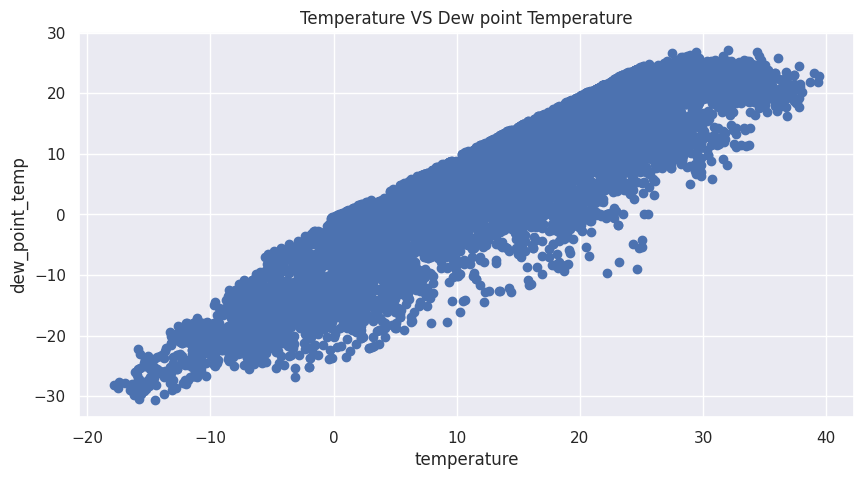

In [14]:
# Scatter plot to visualize the relationship between
# temerature and dew point temperature
plt.figure(figsize=(10,5))
plt.scatter(x='temperature',y='dew_point_temp',data=df)
plt.xlabel('temperature')
plt.ylabel('dew_point_temp')
plt.title('Temperature VS Dew point Temperature')

**Scatter plot for temperature and dew point temperature**

In [15]:
# correlation
df[['temperature','dew_point_temp']].corr()

,temperature,dew_point_temp
temperature,1.000000,0.912798
dew_point_temp,0.912798,1.000000


* **The temperature and dew point temperature are highly correlated (0.912)**.

* **Also, from the above scatter plot, it is clear that as the temperature increases, the dew point temperature also increases**.

* **Hence we can drop the column from the dataset since it will not increase the accuracy of predictions, and will only increase the model complexity**.

In [16]:
# dropping dew point temperature
df.drop('dew_point_temp', axis=1,inplace=True)

#**4.3. Engineering new features 'month' and 'day_of_week' from the 'date':**

In [17]:
#add month, day_of_week columns
for df in [df]:
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek

# {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

#**4.4. Engineering new feature 'weekend':**

* In a city, it is highly likely that the rental bike demand may follow different pattern over the weekends when people do not generally go to work.

* To capture this trend, we can define a new feature 'weekend' which indicates whether a said day is a weekend (1) or not (0).

In [18]:
# engineering new feature 'weekend' from day_of_week
df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x>4 else 0)

#**5. Exploratory Data Analysis:**

In [19]:
# summary of numerical columns
df.describe()

,rented_bike_count,hour,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,month,day_of_week,weekend
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,0.569111,0.148687,0.075068,6.526027,3.002740,0.284932
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,0.868746,1.128193,0.436746,3.448048,1.998056,0.451408
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,0.000000,0.000000,0.000000,4.000000,1.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,0.010000,0.000000,0.000000,7.000000,3.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,0.930000,0.000000,0.000000,10.000000,5.000000,1.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,3.520000,35.000000,8.800000,12.000000,6.000000,1.000000


#**5. Exploratory Data Analysis:**

In [20]:
# defining dependent variable separetely
dependent_variable = ['rented_bike_count']

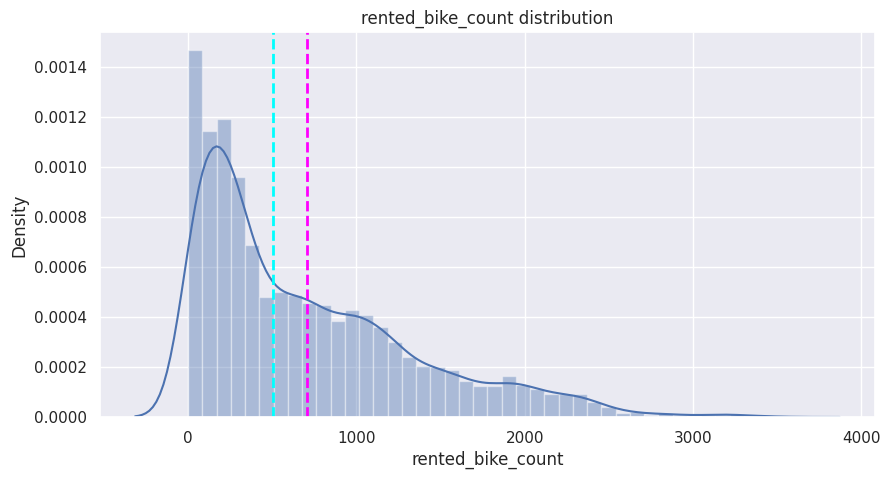

In [21]:
# visualizing the distribution of the dependent variable - rental bike count
plt.figure(figsize=(10,5))
sns.distplot(df[dependent_variable])
plt.xlabel(dependent_variable[0])
plt.title(dependent_variable[0]+' distribution')
plt.axvline(df[dependent_variable[0]].mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(df[dependent_variable[0]].median(), color='cyan', linestyle='dashed', linewidth=2)

In [22]:
# skew of the dependent variable
df[dependent_variable].skew()

rented_bike_count    1.153428
dtype: float64

* **The dependent variable is positively skewed. To get better predictions, it is ideal if the dependent variable is almost normally distributed.**

* **To achieve this, we can transform the data by log, sqrt, etc.**

#**5.1.1. Log transformation:**

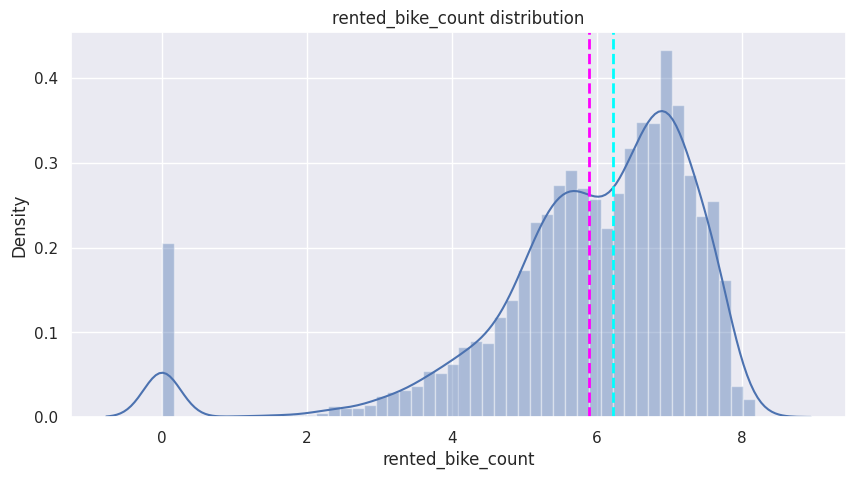

In [23]:
# visualizing the distribution of dependent variable after log transformation
plt.figure(figsize=(10,5))
sns.distplot(np.log1p(df[dependent_variable]))
plt.xlabel(dependent_variable[0])
plt.title(dependent_variable[0]+' distribution')
plt.axvline(np.log1p(df['rented_bike_count']).mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(np.log1p(df['rented_bike_count']).median(), color='cyan', linestyle='dashed', linewidth=2)

In [24]:
# skew of the dependent variable after log transformation
np.log1p(df[dependent_variable]).skew()

rented_bike_count   -1.832199
dtype: float64

**The magnitude of skew increases on performing log transformation.**

#**5.1.2. Square-root transformation:**

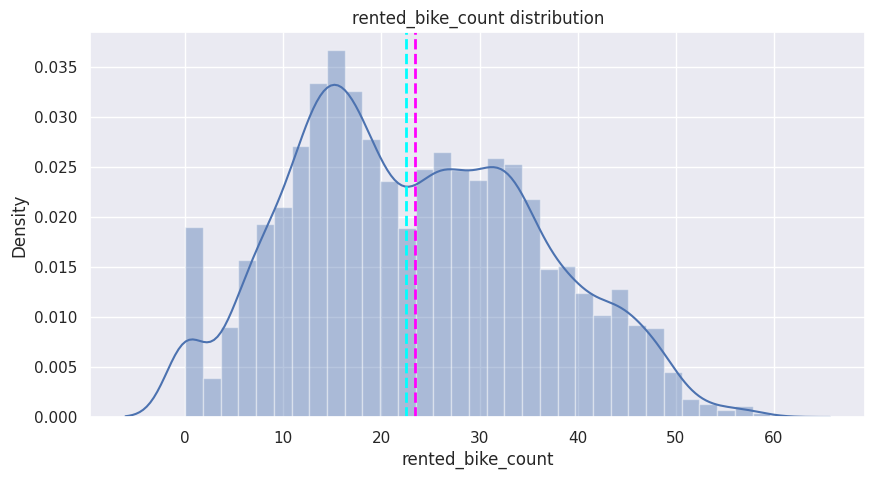

In [25]:
# visualizing the distribution of dependent variable after sqrt transformation
plt.figure(figsize=(10,5))
sns.distplot(np.sqrt(df[dependent_variable]))
plt.xlabel(dependent_variable[0])
plt.title(dependent_variable[0]+' distribution')
plt.axvline(np.sqrt(df['rented_bike_count']).mean(), color='magenta', linestyle='dashed', linewidth=2)
plt.axvline(np.sqrt(df['rented_bike_count']).median(), color='cyan', linestyle='dashed', linewidth=2)

In [26]:
# # skew of the dependent variable after sqrt transformation
np.sqrt(df[dependent_variable]).skew()


rented_bike_count    0.237362
dtype: float64

**We were able to reduce skewness on square root transformation. Hence we can use square root transformation during the modelling.**

## **5.2. Analyzing the distribution of continuous independent variables:**

In [27]:
# defining continuous independent variables separately
continuous_var = ['temperature', 'humidity', 'wind_speed', 'visibility', 'solar_radiation', 'rainfall', 'snowfall']

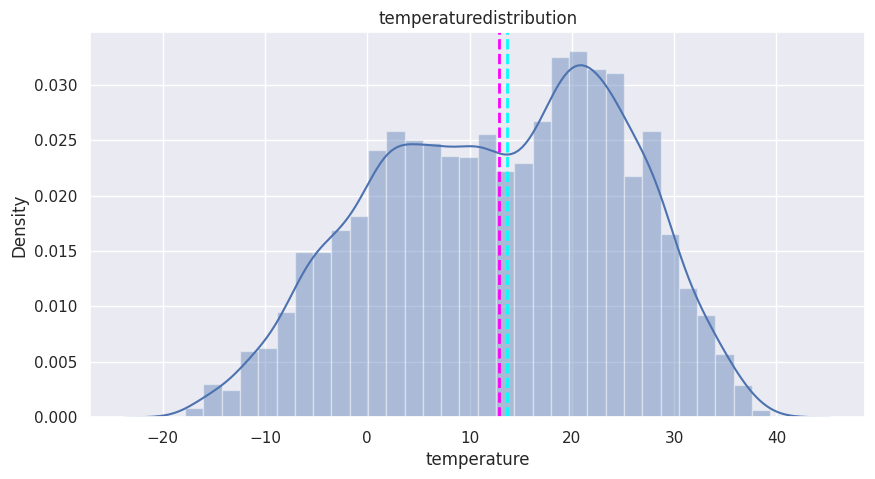

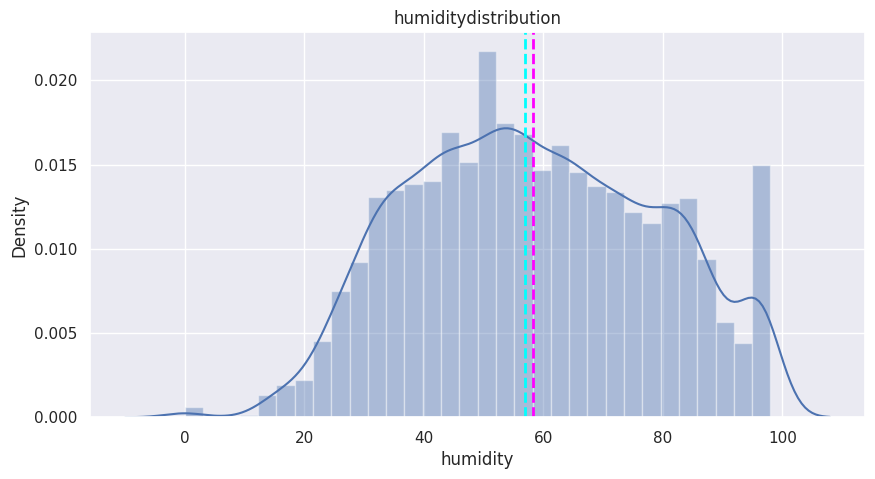

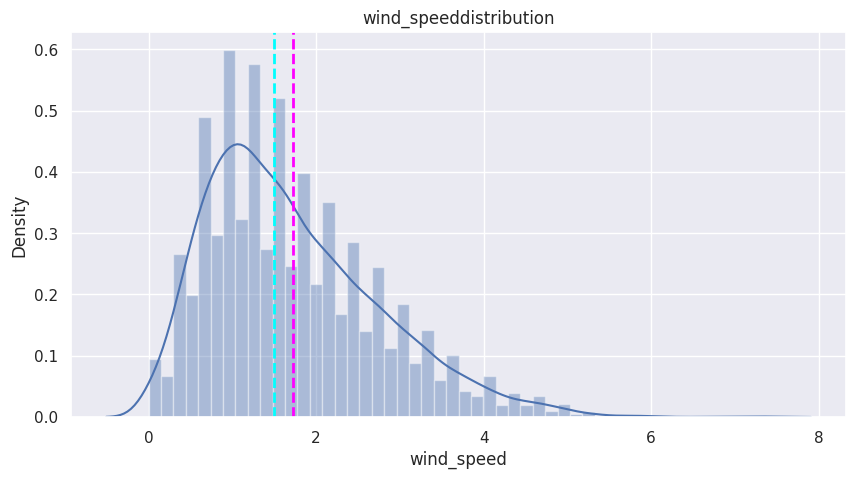

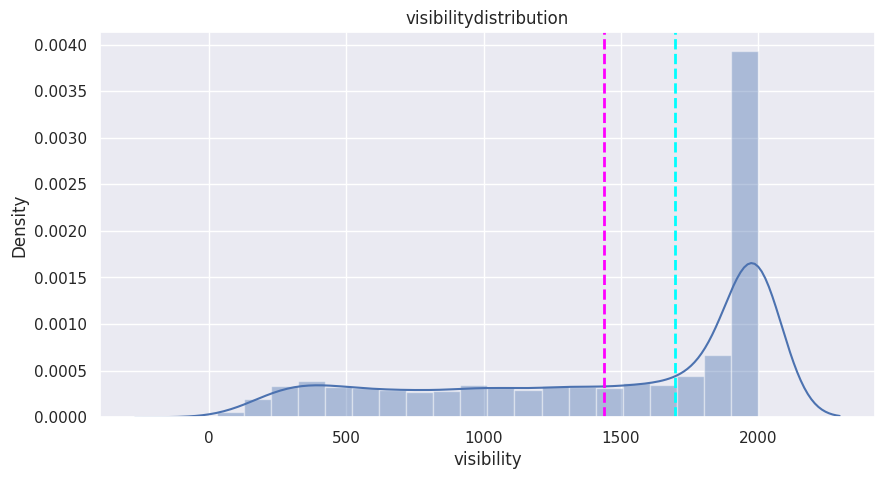

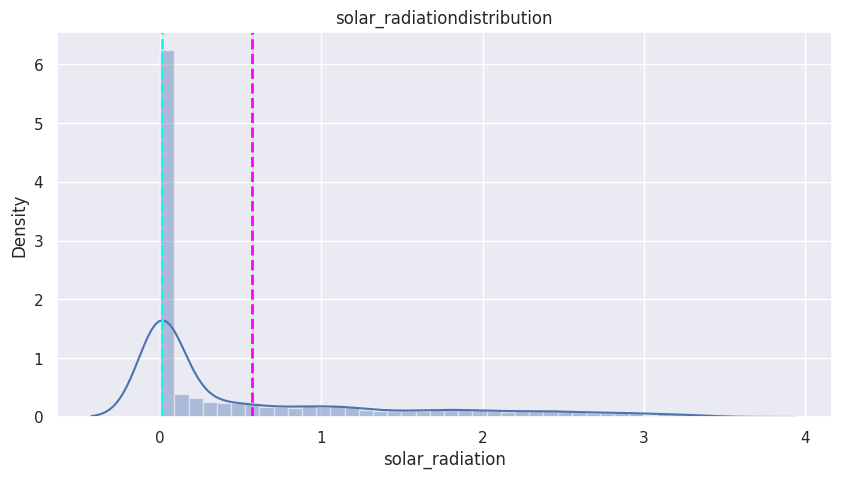

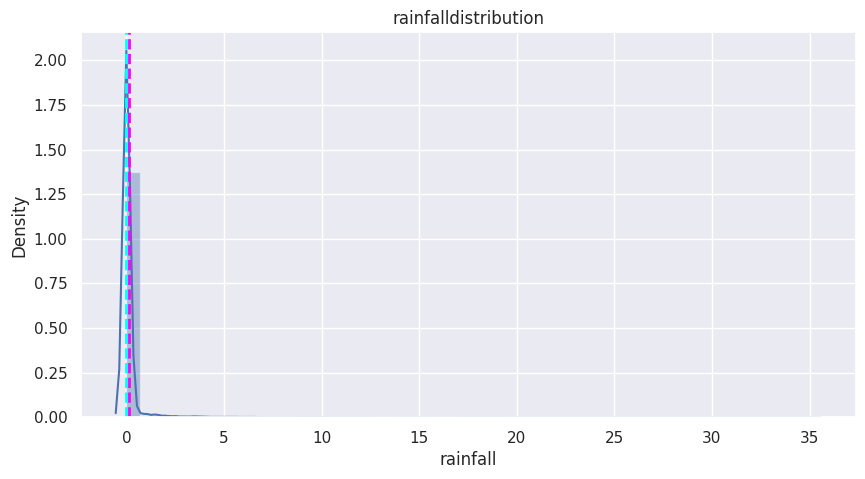

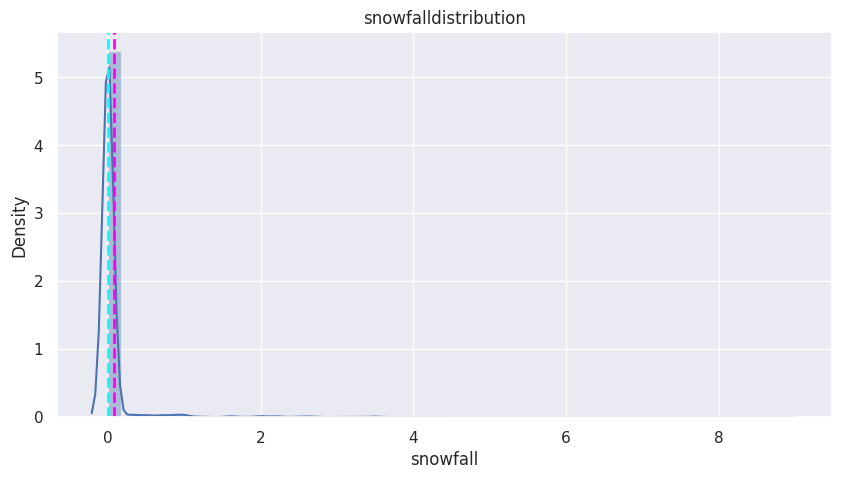

In [28]:
# Analyzing the distribution of the continuous independent variables
for col in continuous_var:
  plt.figure(figsize=(10,5))
  sns.distplot(df[col])
  plt.axvline(df[col].mean(), color='magenta', linestyle='dashed', linewidth=2)
  plt.axvline(df[col].median(), color='cyan', linestyle='dashed', linewidth=2)
  plt.title(col+'distribution')
  plt.show()


**Summary:**

* **Normally distributed attributes: temperature, humidity.**
* **Positively skewed attributes: wind, solar_radiation, snowfall, rainfall.**
* **Negatively skewed attributes: visibility.**

## **5.3. Analyzing the relationship between dependent variable and continuous independent variables:**

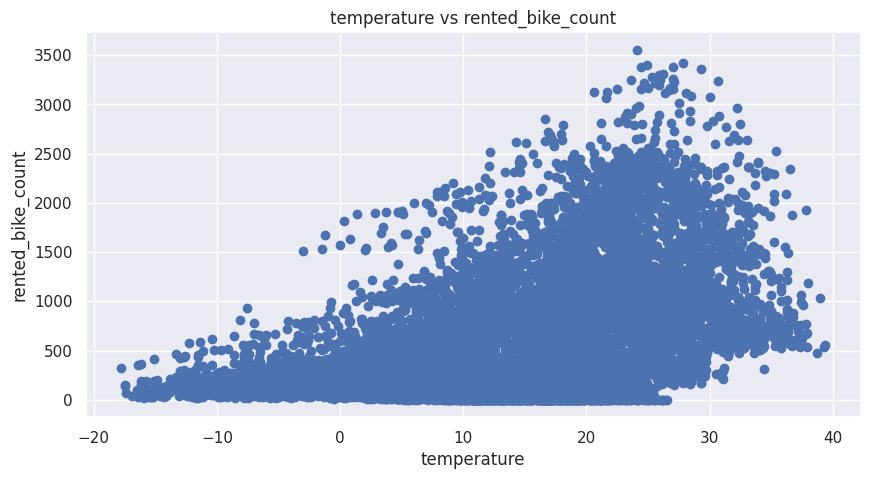

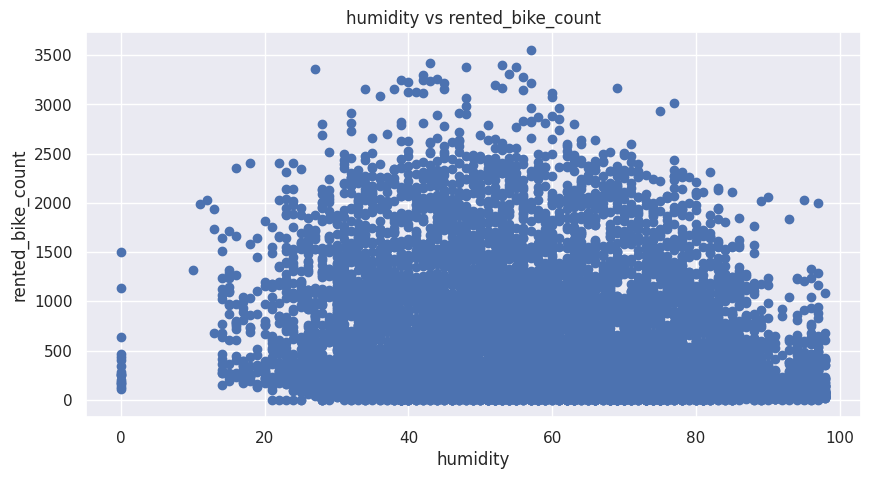

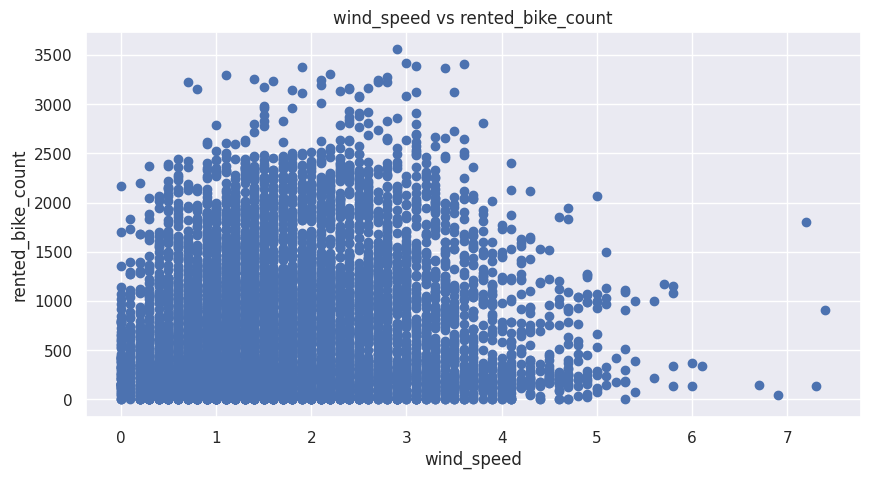

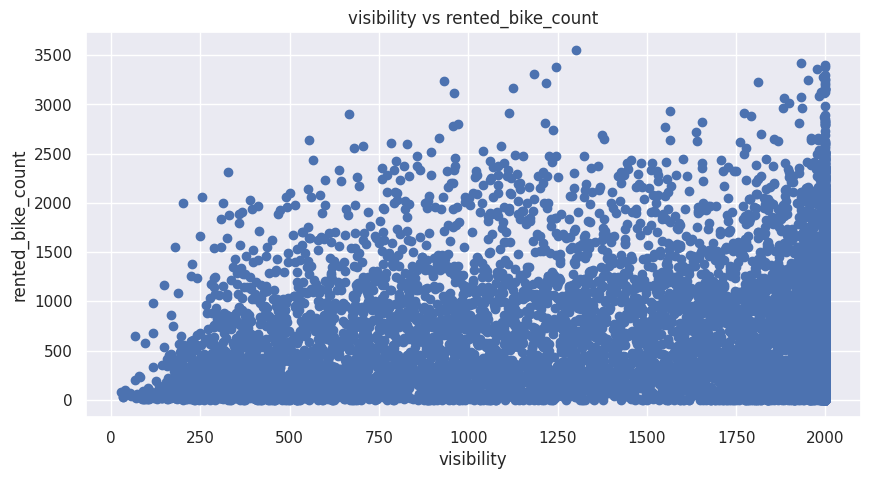

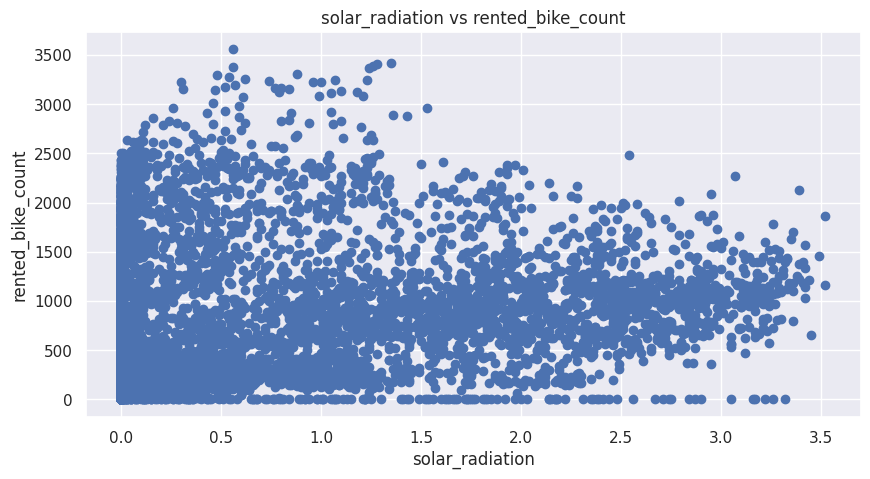

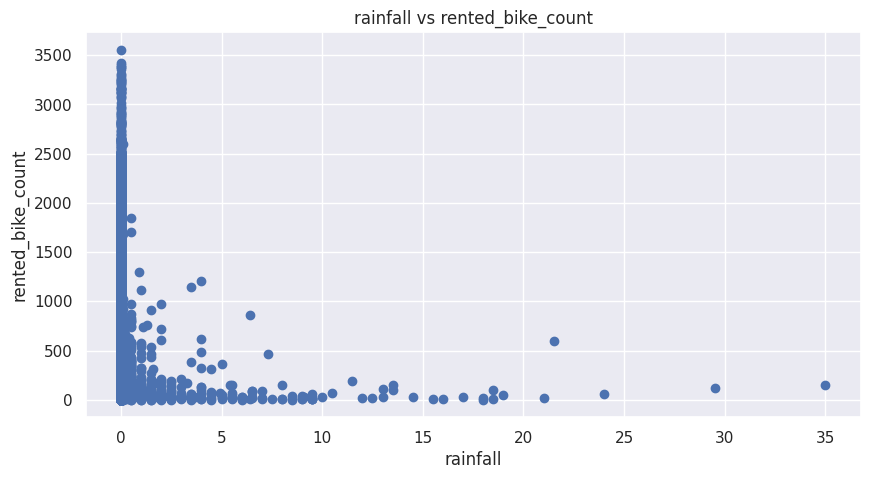

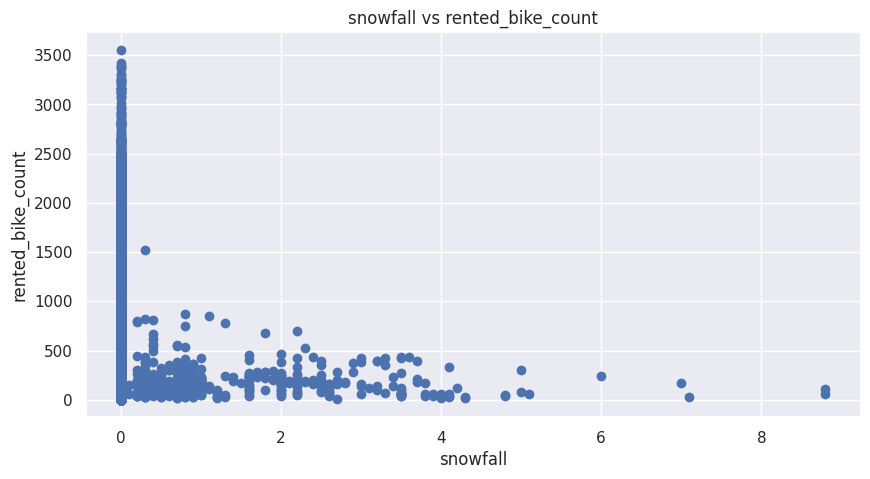

In [29]:
# Analyzing the relationship between the dependent variable and the continuous variables
for i in continuous_var:
  plt.figure(figsize=(10,5))
  plt.scatter(x=i,y=dependent_variable[0],data=df)
  plt.xlabel(i)
  plt.ylabel(dependent_variable[0])
  plt.title(i+' vs '+ dependent_variable[0])
  plt.show()

**Summary:**

* **Positively correlated variables: temperature, windspeed, visibility, solar radiation.**
* **Negatively correlated variables: humidity, rainfall, snowfall.**

## **5.4. Analyzing the relationship between dependent variable and categorical independent variables:**

In [30]:
# defining categorical independent variables separately
categorical_var = ['hour','seasons', 'holiday', 'func_day', 'month', 'day_of_week', 'weekend']

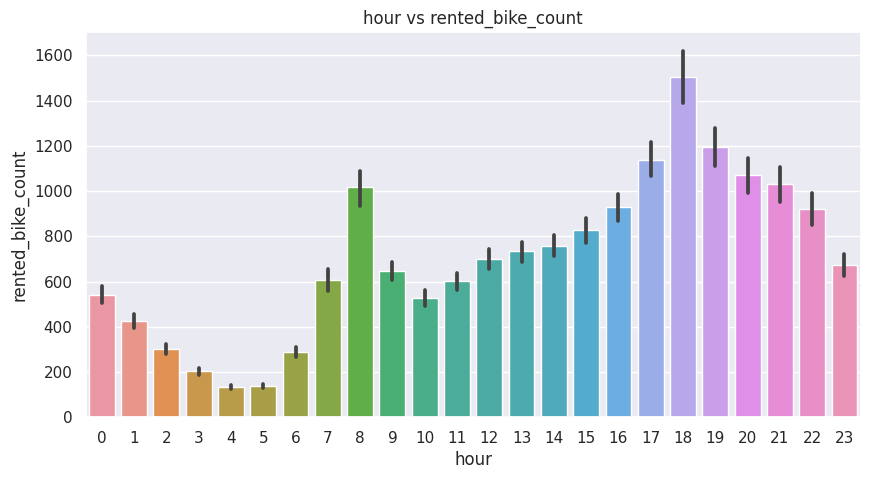

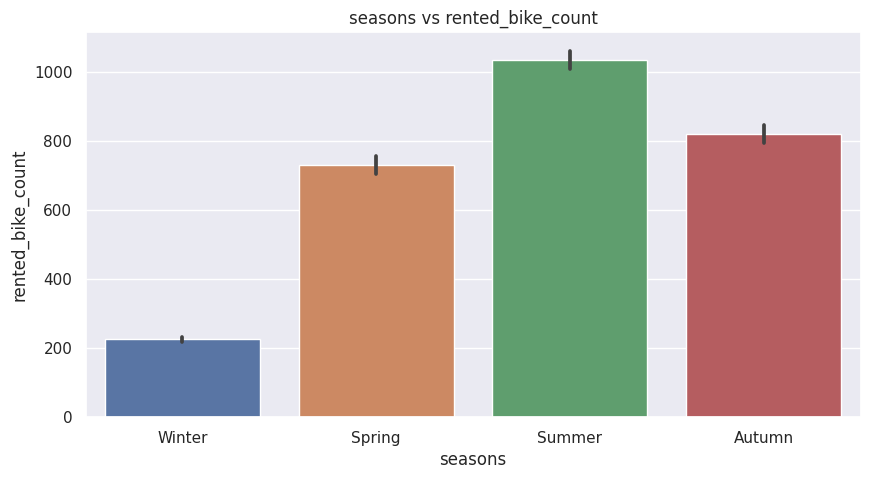

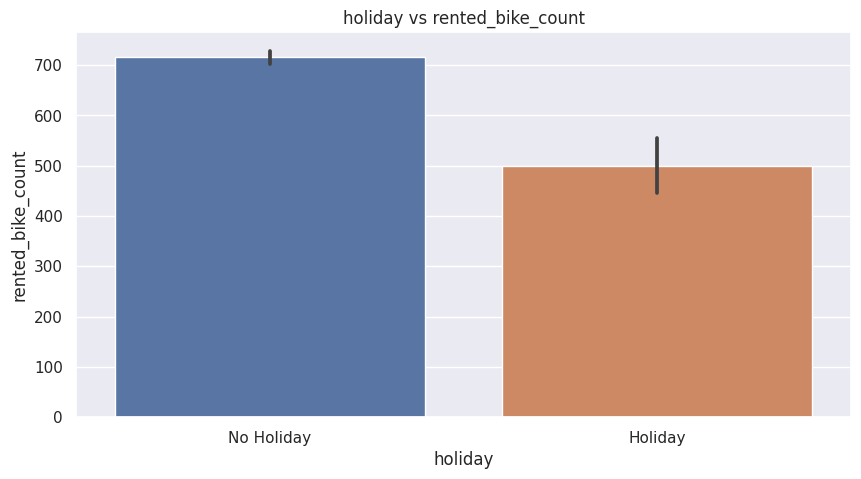

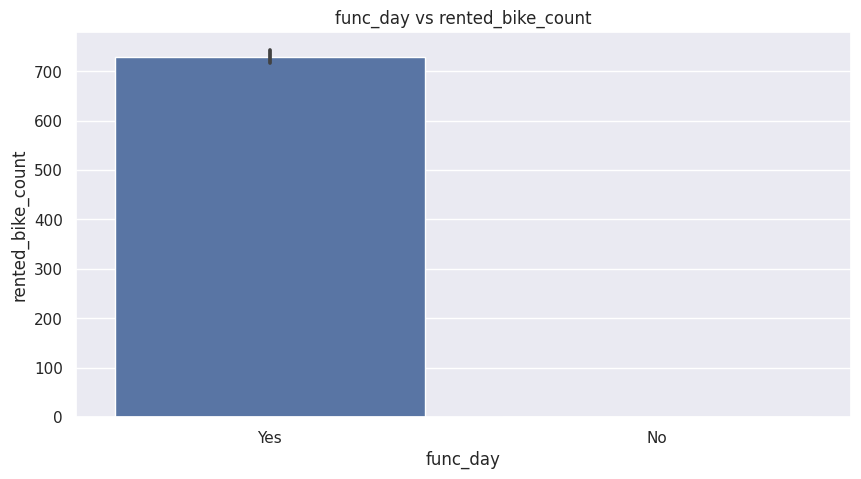

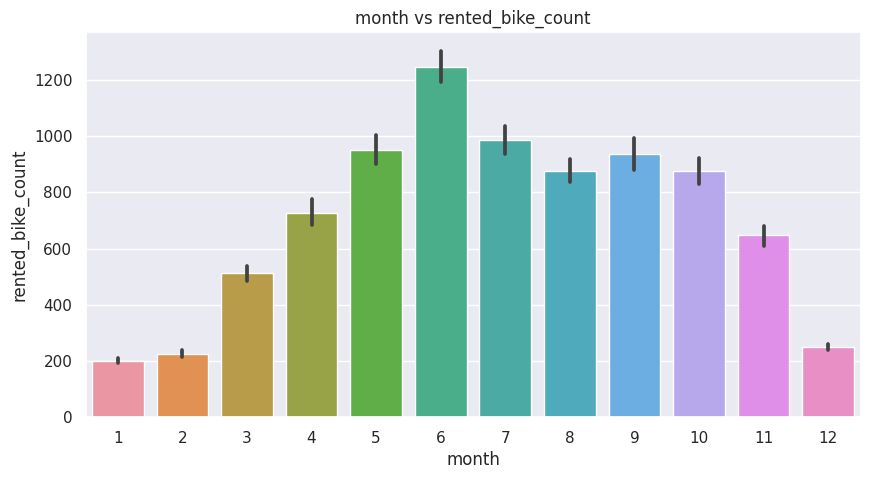

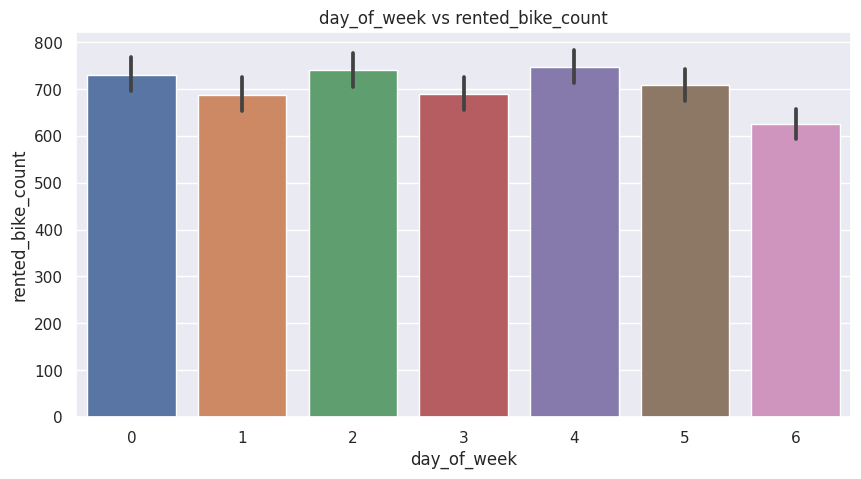

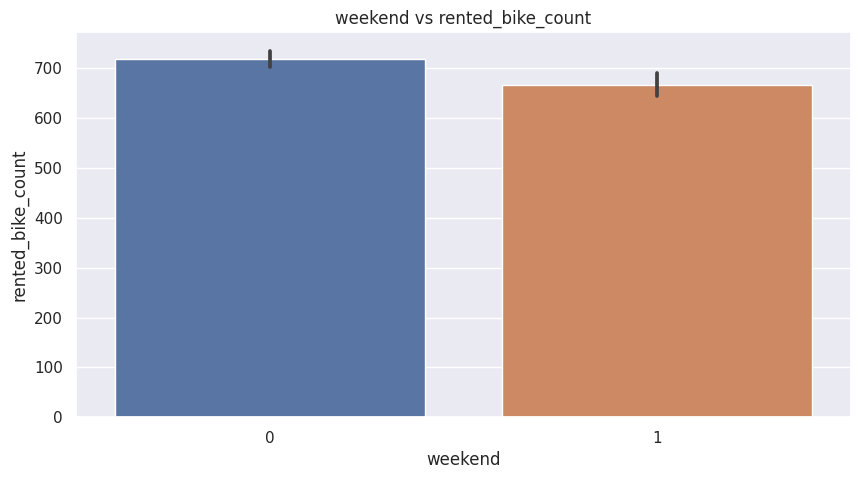

In [31]:
# Analyzing the relationship between the dependent variable and the categorical variables
for i in categorical_var:
  plt.figure(figsize=(10,5))
  sns.barplot(x=i,y=dependent_variable[0],data=df)
  plt.xlabel(i)
  plt.ylabel(dependent_variable[0])
  plt.title(i+' vs '+ dependent_variable[0])
  plt.show()

**Summary:**

* **The number of bikes rented is on average higher during the rush hours.**
* **The rented bike counts is higher during the summer and lowest during the winter.**
* **The rented bike count is higher on working days than on non working days.**
* **On a non functioning day, no bikes are rented in all the instances of the data.**
* **The number of bikes rented on average remains constant throughout Monday - Saturday, it dips on Sunday, and on average, the rented bike counts is lower on weenends than on weekdays.**


In [32]:
# Highest rented bike count on a functioning day vs a non functioning day
df.groupby(['func_day'])['rented_bike_count'].max()

func_day
No        0
Yes    3556
Name: rented_bike_count, dtype: int64

In [33]:
# Non functioning days in the dataset
df[(df['func_day']=='No')]['date'].unique()

array(['2018-04-11T00:00:00.000000000', '2018-05-10T00:00:00.000000000',
       '2018-09-18T00:00:00.000000000', '2018-09-19T00:00:00.000000000',
       '2018-09-28T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
       '2018-10-02T00:00:00.000000000', '2018-10-04T00:00:00.000000000',
       '2018-10-06T00:00:00.000000000', '2018-10-09T00:00:00.000000000',
       '2018-11-03T00:00:00.000000000', '2018-11-06T00:00:00.000000000',
       '2018-11-09T00:00:00.000000000'], dtype='datetime64[ns]')

**On a non functioning day, no bikes are rented in all the instances of the data.**

## **5.5. Correlation analysis:**

<Axes: title={'center': 'Correlation Analysis'}>

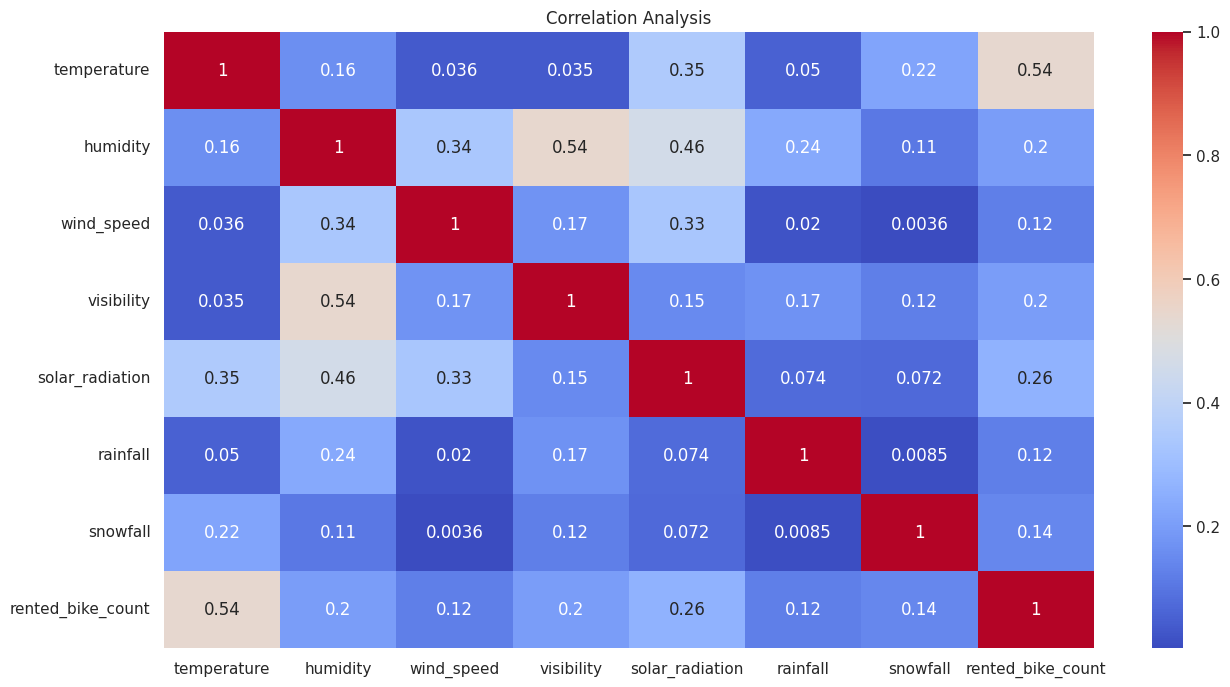

In [34]:
 ## Correlation magnitude for continuous variables
plt.figure(figsize=(15,8))
plt.title('Correlation Analysis')
correlation = df[continuous_var+dependent_variable].corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

**There is no multicollinerity in the data.**

## **5.6. Outlier analysis:**

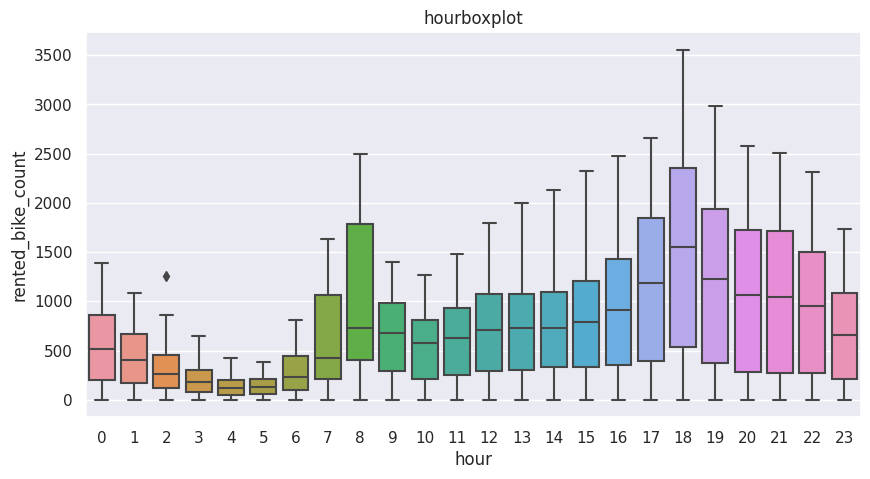

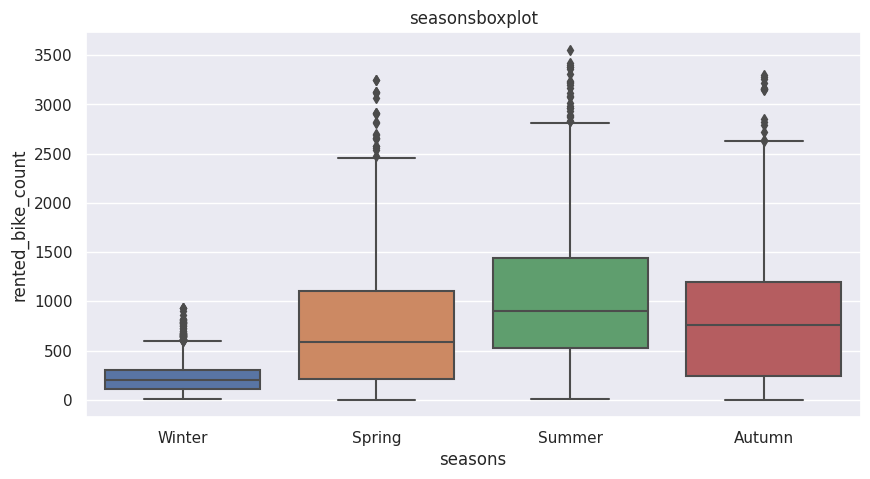

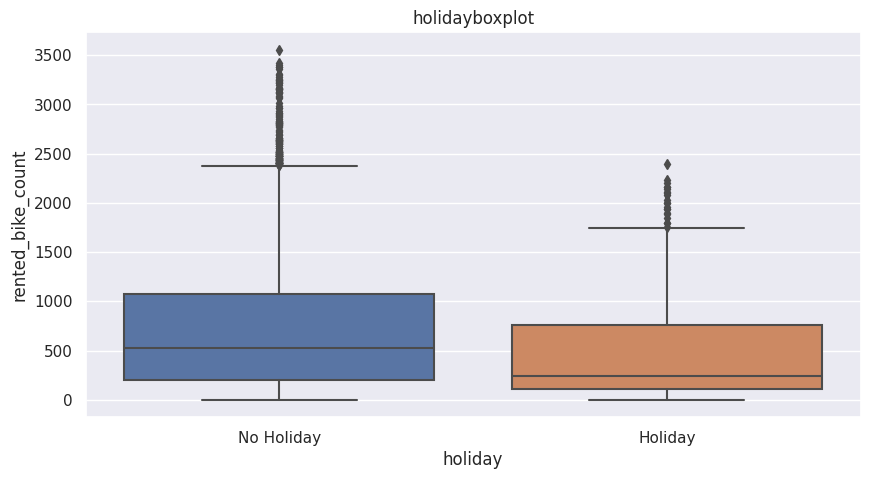

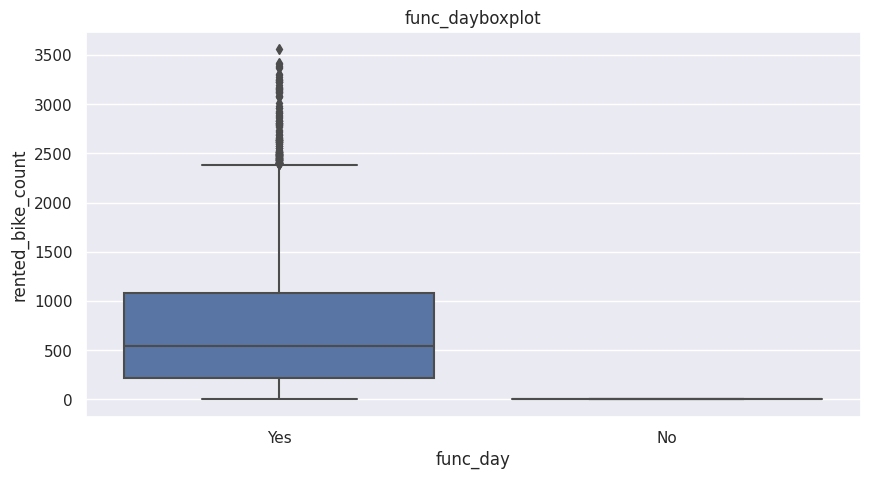

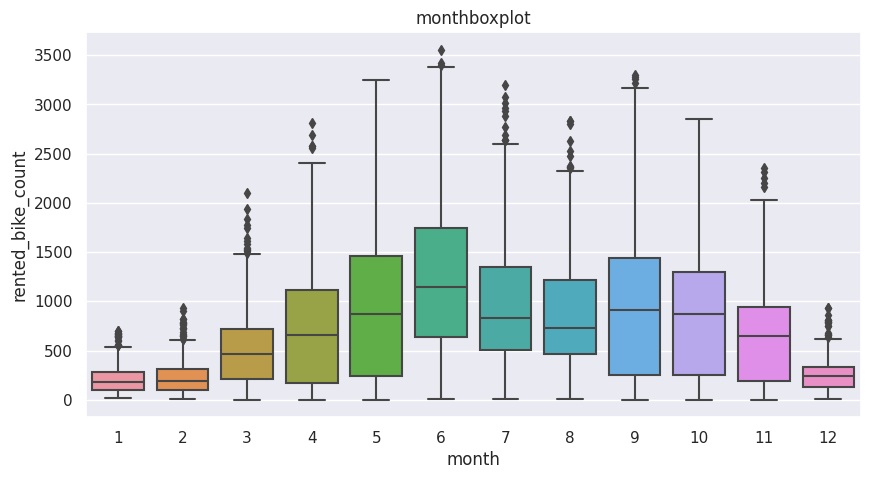

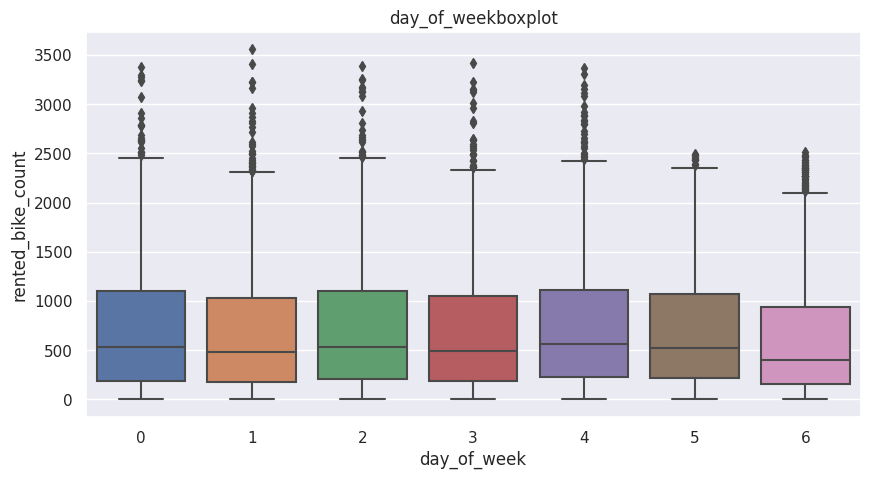

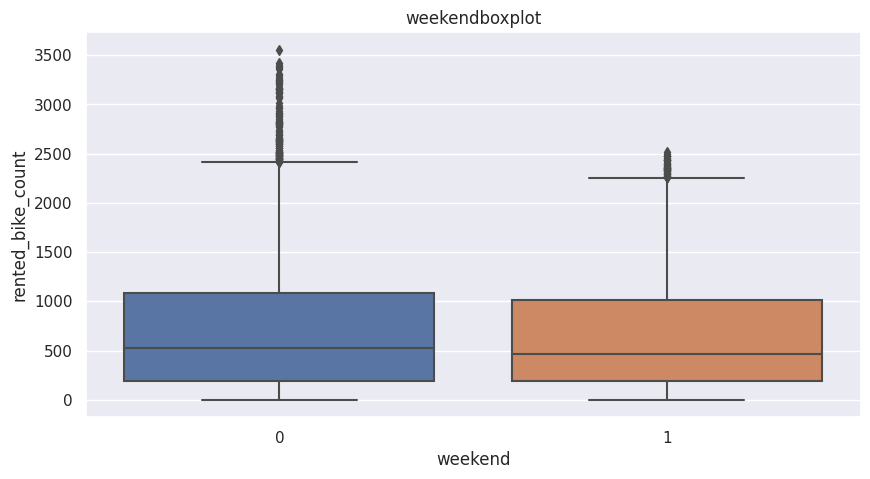

In [35]:
for col in categorical_var:
  plt.figure(figsize=(10,5))
  sns.boxplot(x = col,y = dependent_variable[0],data=df)
  plt.title(col+'boxplot')
  plt.show()

**There are outliers in the data and this must be taken into consideration in the model building phase.**

## **5.7. Bike demand throughout the day:**

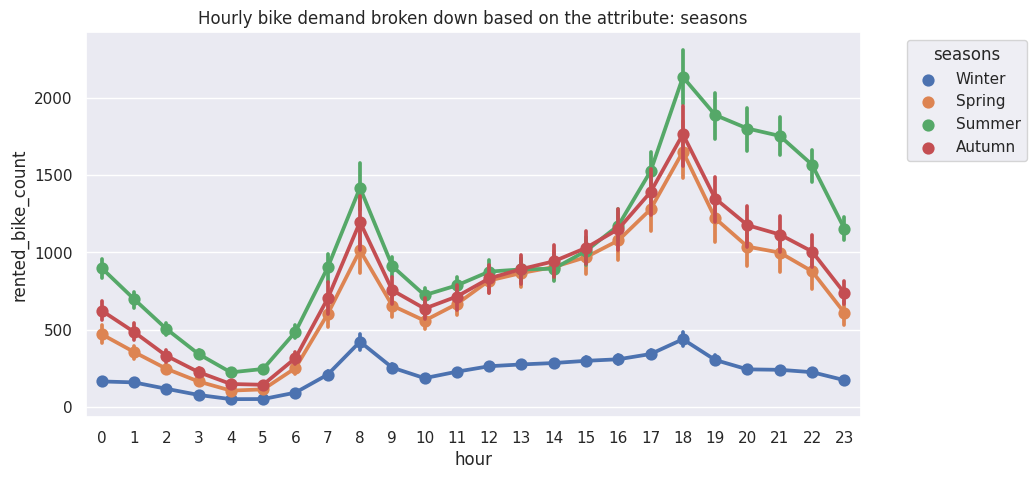

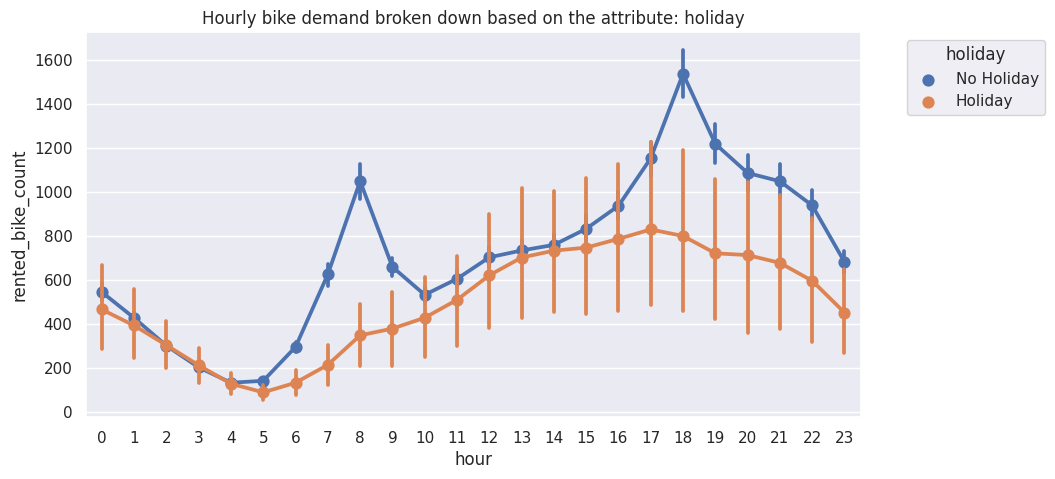

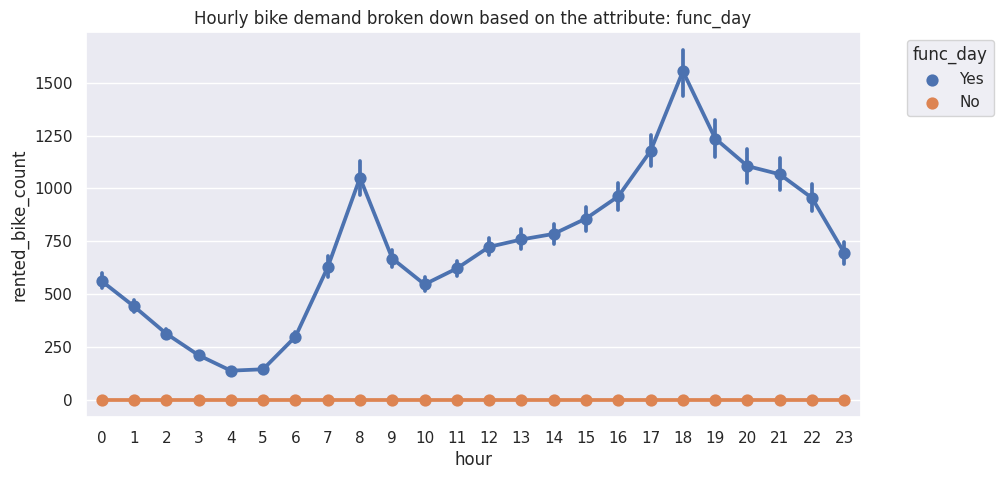

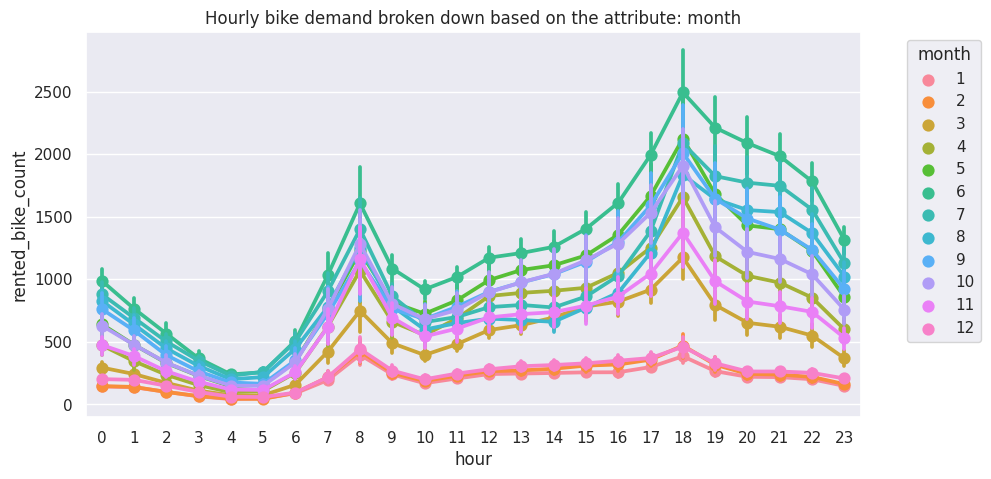

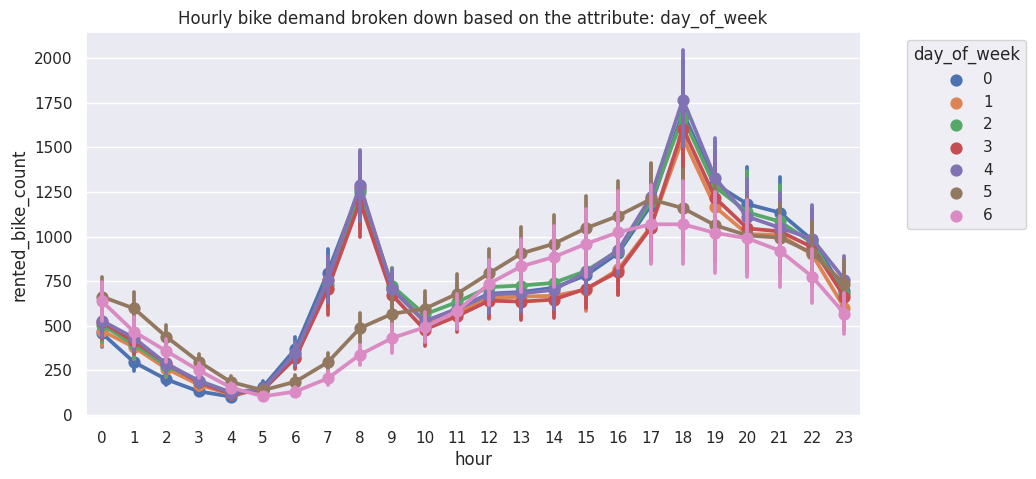

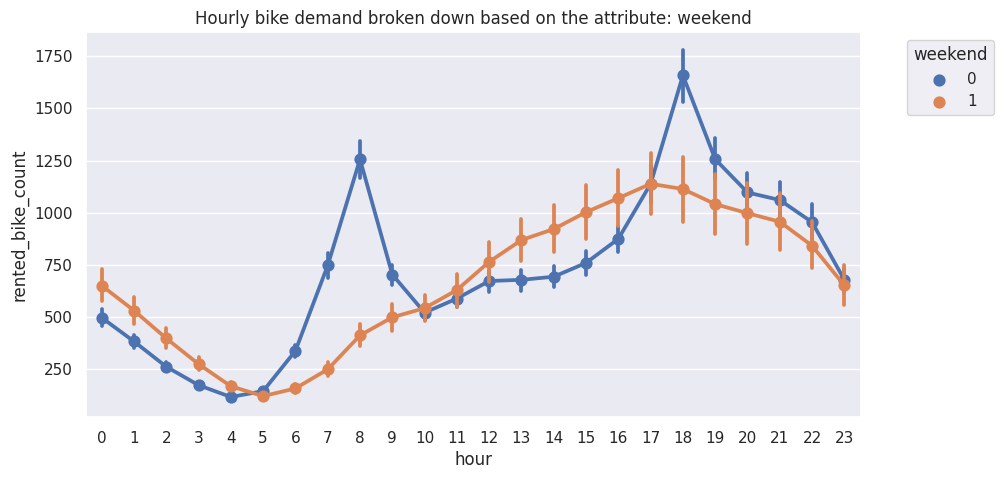

In [36]:
for i in categorical_var:
  if i == 'hour':
    continue
  else:
    fig, ax = plt.subplots(figsize=(10,5))
    sns.pointplot(data=df, x='hour', y='rented_bike_count', hue=i, ax=ax)
    plt.title('Hourly bike demand broken down based on the attribute: '+i)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title=i)
    plt.show()

**Summary:**

* **In winters the overall demand for rented bikes is comparitively lower than that of other seasons.**
* **On a non functioning day, no bikes are rented.**
* **The demand for rented bikes throughout the day on holidays and weekends follow a different pattern than other days. On regular days, the demand for the bikes is higher during rush hours. On holidays or weekends, the demand is comparitively lower in the mornings, and is higher in the afternoons**

# **6. Feature engineering:**

In [37]:
# features
df.columns


Index(['date', 'rented_bike_count', 'hour', 'temperature', 'humidity',
       'wind_speed', 'visibility', 'solar_radiation', 'rainfall', 'snowfall',
       'seasons', 'holiday', 'func_day', 'month', 'day_of_week', 'weekend'],
      dtype='object')

##**6.1. Converting snowfall, rainfall and visibility to categorical attributes:**

* Since there are vaey few day on which there was snowfall / rainfall, it is in our interest that we convert these columns to binary categorical columns indicating whether there was rainfall / snowfall at that particular hour

In [38]:
# Converting snowfall and rainfall to categorical attributes
df['snowfall'] = df['snowfall'].apply(lambda x: 1 if x>0 else 0)
df['rainfall'] = df['rainfall'].apply(lambda x: 1 if x>0 else 0)


**Converting visibility to a categorical attribute:**

When
* Visibility >= 20 Km ---> Clear (high visibility)
* 4 Km <= Visibility < 10 Km ---> Haze (medium visibility)
* Visibility < 4 Km ---> Fog (low visibility)

Converting visibility based on the above mentioned threshold values. Since they are ordinal, we can encode them as 0 (low visibility), 1 (medium visibility), 2 (high visibility)

In [39]:
# encoding the visibility column
df['visibility'] = pd.cut(df.visibility,bins=[0,399,999,2001],labels=[0,1,2])

## **6.2. One-hot encoding:**

* Nominal categorical features 'month', 'day_of_week', 'hour' are nominal categorical variables. Hence we need to encode them.

In [40]:
# one hot encoding
df = pd.get_dummies(df, columns = ['month', 'hour','day_of_week'])

In [41]:
df.columns

Index(['date', 'rented_bike_count', 'temperature', 'humidity', 'wind_speed',
       'visibility', 'solar_radiation', 'rainfall', 'snowfall', 'seasons',
       'holiday', 'func_day', 'weekend', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6'],
      dtype='object')

## **6.3. Dropping columns:**

Since we have encoded the 'month' and 'day_of_week' attributes, we no longer need 'weekend' and 'seasons' attributes since they essentially convey similar information.

In [42]:
# dropping seasons and weekend
df.drop(['seasons','weekend'],axis=1, inplace=True)

In [43]:
df.head()

,date,rented_bike_count,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,holiday,...,hour_21,hour_22,hour_23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2017-12-01,254,-5.2,37,2.2,2,0.0,0,0,No Holiday,...,0,0,0,0,0,0,0,1,0,0
1,2017-12-01,204,-5.5,38,0.8,2,0.0,0,0,No Holiday,...,0,0,0,0,0,0,0,1,0,0
2,2017-12-01,173,-6.0,39,1.0,2,0.0,0,0,No Holiday,...,0,0,0,0,0,0,0,1,0,0
3,2017-12-01,107,-6.2,40,0.9,2,0.0,0,0,No Holiday,...,0,0,0,0,0,0,0,1,0,0
4,2017-12-01,78,-6.0,36,2.3,2,0.0,0,0,No Holiday,...,0,0,0,0,0,0,0,1,0,0


# **7. Data preprocessing:**

## **7.1. Encoding the data to fit a model:**

In [44]:
# encoding
df['func_day'] = np.where(df['func_day'] == 'Yes',1,0)
df['holiday'] = np.where(df['holiday'] == 'Holiday', 1,0)

## **7.2. Dropping date attribute:**

The date column cannot be used to build a ML model. Hence we can drop it.

In [45]:
# Dropping date attribute
df.drop('date',axis=1,inplace=True)


In [46]:
# Defining dependent and independent variables
X= df.drop('rented_bike_count', axis=1)
y= np.sqrt(df[dependent_variable])

In [47]:
# shape of dataframe
df.shape

(8760, 53)

## **7.3. Choice of model:**

**The prediction model should be chosen in such a way that it:**
* Is able to predict the dependent variable with high accuracy (Accuracy).
* Is easy to interpret (Interpretability)
* Is easy to explain the model (Explainability).

**Since we are working with data that:**
* Contains outliers
* Contains many categorical independent variables
* Is not lineraly related to the dependent variable

It is not advisable to use linear models to make the predictions. We can use tree models insted.

**Modeling approach:**

* Use a decision tree regressor model to come up with initial set of predictions (baseline model)
* Calculate the model accuracy using the regression evaluation metrics
* Improve the model accuracy by hyperparameter tuning
* Find feature importances from the baseline model
* Use bagging/boosting algorithms to increase the model accuracy. (PS: explainability reduces as the model complexity increases)
* Choose the model with the highest accuracy for deployment

![download.img](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAzcAAAGsCAIAAABvjc4kAAAgAElEQVR4nOzdd5QcR7Uw8FtVnSanzTkprbQKK2mVLcuyJTlngyPgABj8yGCCecB7PN5HeARjwDgBtgHjnINyzmmlDdLmnMPk0N1V9f0xkqwsG8leaV2/s0dnZ9RTfadnpvdOddUtxBiDD+aRRx45/QYPPPDAB2xKEARBEARBOD3EOR/pGARBEARBEITj4ZEOQBAEQRAEQTgJkaUJgiAIgiCcj0SWJgiCIAiCcD4SWZogCIIgCML5SGRpgiAIgiAI5yORpQmCIAiCIJyPRJYmCIIgCIJwPhJZmiAIgiAIwvlIZGmCIAiCIAjnI5GlCYIgCIIgnI9EliYIgiAIgnA+ElmaIAiCIAjC+UhkaYJwyJOteulm9mavmby5os8sXRN5ocs4h7swONyyM3rHrig76s69flq6LvbD2njyZleczd0Q+U51/HTtMB4w+NnH81SrXrY6XBuiZ9+UIAiCcM5JIx2AcH5ZuWp1OBy97tqrAKC5uWXDxk033nDdrl172to7Pv2pmyTp+DfM4NDQq6++ccklFxcW5I9EvOfSbj+tNZS/tcauSpcAYH+Q1sblNPlc7iJg8I0D5sIU6eivR3URWqurT7eFv1KspiqoJ863BMnlaehUjVQH6W8aEg+OVV0yOct4dvhpR5zbySn3JYx6/9ywxR+NccbOvKkgnAyWpFnFhdOKLvg/AecnkaUJx9izd19fX38yS+vu6VmxcvWyZUsZY5SdvLslGAy+8+7ysrJJF3qWxjhvizHQ2eY4646zTA0fDDM3N4rtdgDQGbzabVCE5ntwrgUDwJYh2pdgV2XIEZOv6DcnOHCpg+z0036dX+wj7/aaLhldkiptGzIb41jm5uXpsl1CXTE2zMg4+zFZUXOEg6m3UbJ1yLw6Q26IMOCszHkoPVzZb/aZZIxGZ3okyvnKfvrA/kRvnF2SRhuj3EbQAh9JMP5ur5lvxVNdpDnKtg2z+V6cY8FbhszmBLGBeW3modY2DFKDsVle+a0eI0tDB0NmpgqZGq4JscooziTmxSlSS5Rt9gNCMMnKy1xnmwgK57k1+2v8usGo6E8V/k2SoqXYrCJL+4iILE04hixLmqYlf9c0TVUVhIAD54wjhEzTfOmV12pqaufOmV1f3zB12pTCgnyr1drW1r5q9RpZlu/+3F1ej2dkn8K/Z0iHqhDL4tGoyVb2m3fkKvtDNEdDHhkGdX5fZfzdfsY4K9Tgrdm2Ahu+vzLmN9hVGVJlkN20lz0ygZc6yH8diFcFzcvS5MfC1s/bokETPlupA/AAl+5Kj/1lmrUuzOJYKbQe02+xy2+qlKWr8EKncXWGvNtvKmDmWhTK4Wd1iV82UwRAMPpbGV+YKn2nKtYQlywY/txiMM4B0IYFtlX95nXV8tfS41PLyK/qE0+0G5ULrb9u0H/SwCQEAYPdk2v+bpKmEfT1/TEANtZu/DNuvd8ebY5BuQu1x9iSLVED4eenKRsGzHv2JfoNSFAgnP1zuuWqDHGWGM1UWTbDEZGlCWcBESxGT31UxJEVjoExHhoaeu2NN197483NW7ZyDgTjpqbm3Xv2YIxXrl7zwosvp6enbdmybcOmLb29fQghyuiGTZtSUnyV+/a//MrrnJ+D8VIfv64464ixpT40xyu/2WMGddYcZnkWbJPwD2ti7/Sz3Qu07fMt9RH2r049qLO+BJvtIQSh1igFzsbbEeMwbEAvV9cPsW97E3fmKV/aF5vj4kNLrTenmC90Gn0J1hJlCk2Ms7/fQRWjUB/lYyz89ixp/aAZNHhTlDsJFFrJa93GfzbyX4wjA0us6cT8bZPuIOjJcqtM9S/n4XXzbTPcZFCnccpf6DQBAwcY1PlLXca9uVLEhO/WsRvSYGCJ9efj5cc6+PpBM0Z5hMGBhHIwTH/gi1+bKQ8bvNBCbt0VpQi/O1NZmCL9ujERN2j3pdaWxZYvFmkxekG+moIgCKOD+JYsHEOSpKHh4RdefBUAGGeaqiKECCGyoui6vmPHrqlTJn/pi59vaWn93kM/xhgDAOf8qisuv+zSS8KhcHt7O+ccoQtvnFNbjJmA5qVIGkbfrI6vGzSHDFZglcIme7ufjrFAkELYAKeM9wdpfYT1cqXcDQDQHGUWbuRblIDBuuLMAvDP6ZapLgIAmxfYuuN8Z4AzhG0EJAwHw9SNabHt/W9HQzrrjrNLUqS78pQ/tuivdhttMZaqIIcEr3SbKqdpqrInYKaruDpoGpxXBakha3O8GAB8CoozOBBmq/sNCyIRg73cZQwZ/O585e1ek3H+QJGGECxOlUhNvDqISx2kN07TVfxyhS3fipf3mhEKj3XQEEi/H4emuSUAkBHq4NqyLZGfjNd+OeGcDsoTBEEQPiSRpQnHME3T5/NdfeXlANDS2rp9+85kXwoCFI/He3p658yuAIDU1BSX08EYAwCMsNvtBgBZUSKRCKUUn2e935TDGcfHN4UZEKnARsZYMeP84Sbd4Gi8nfQkIGDwjgSetT4CnCuqmqby5ihjnE90SABQGWRFFsiz4uYI69DR57JRMkU7GGaPtBjPd+p9OgJJXuwibgnVR1i6ht3S+9H063zAJAVWPM6OJzvJ75oS7TE+x0sYh8YoNYDctCPGEZIlaZIVY4TqIwyZZqFFA4B8K4ma8EKn7pLRIpfpN/i/OvVFKWSqi/ysXs9VaKENA0DEBM7BKaOuGBvm8jdycb4VA0BLjJmyJWHENEKrQ4dC+t+JWrjaeGeAXLyX3OKKPDnNapcuvJxbEARhdBBZmnAMxpjH7V665FIA2L1n744dO5NXMDnnsixbrdZwOAIApmkmEvqRPrMj25xvvWg7hs1nO+nOYWO8U74tiyxOPeUbvjnGHWAUW7Q8K17gk14ZlCREZ3gJQUhn8I1C6XtjVIIBAZIQ/3m9buf6RKcSo7Br2BzvIApG+4JMx/I836Ej8L3q+Bt+6fFSbY4bT18XKbJKCQatMT7VieWjcsaOGKMAU50IIfTpbPnLNRRJ0lwvVwjiHM100NcqHCpBEgIOAMC3DdFiCy+yEQDwKiho8r91mDdlSiU2/FCdGdXp38otBCEZAQIkIwCANQMGk+SJDrIrQAHQHM+hg1AbZhohfyq1rO033us1gyavC7OAwV+ZoTRF+F27Iy90md8bQ6e6xVlCEARhZJxffR7C+YAdnpNvGEeXCuOapo0ZU7xz956Ojs61azdE43FCzuv3zyvdxuU79Ic78OYgfqoLXbPLeLRFP+mWjENjhGZbiFdFALAsTeIAVgKZKsrW0GQneq+fhk32do/5cGMcADWGKQDujMMPauMtzFJkQwBwMEyxkci3HDom7XFWQBJLU8lf2vQIUUudpC3KOuIwznHMrMmGCJM5LbBJALAwRXIhgwMUWhECWJxCKsNwMMKaI/T7tXqcQszkB8LUp6CAwXXGczXMALrj/N58xS2jgGTN0lAyE53rkVpM5e0+c5ef/qpRX+Tm01ykJsQsLJGlYQAwGd85TPNx/K5ceZ6PtMWhOkhf7NQv3S8912n4FCiykVQVpWnn9UssfDwMSuO6EdcNevjkwDkkDEM3zZEN7AiD0rhhfJBBsSZlcT058+bcYJzHDSOuH3M0josneQAZ5xwgYRiGecq5GoZ5kifywZ+dMPqIU7BwDEopPTzbi3NumibnnFJqmhQArrricrvN9s3vfL+6ttZus1LKjmxz3GNHXHecf2VfbJASSETBNECPRSk8WJuoDJ4kwiGdbR2mORpKXt1bmia7uO5VkEfGCoaHyyxBhvPWmbdW0p1B3hqll6RKYZAu3RzpijGixyY5CQBUBZmVQNHhMWdfyJebEzjnvdCqAQqMOSRoi3FTs5baj/nQrR0wNcwzNQCAiU4y0yMBpdkaBoCvlqgXe2DhDl6+lW8KwLZhUyVoihNv020V6yO9cZ6qAuO8woXGO7CVAGB0e46cpmIAuDNPviuDf3ofn7GNT7TjP02xqARVBmiqinMsCADCFA6GaaENYwSTnRJVtHd7ja8Ua1fZYp+twekrE+8N8kfKrFkiS/tk45zrpjmtMP+W+bNumT+rKD1NN03OQZWlq2eWXzRx/DlMd45DGaMfrIobB5g9tvjWBXPsFu2k8XAAk1LGOeN8Yl727QvnpbmcjJ2DyBljbpv15rkVty+ce9mUSRghDsA5rygpumnOTLumcc4pY1ML8z81f3a6y6nJ0k1zKy6aOO5Ucc4aW3zj7JlWVT2Sk3HOy4vyb5k7y2G1fHRHWzhviWsZwjE+c+cd5uFvhJPLJv33T37kdruvv/7ay5ctRQgRgu/+3F0pKSmqonz/oR9ZLFpaauov/t9PU1J8AHDH7Z/Wdf3Eyrcj4vkuo4OpoB+u4I8QmHpQtfy1zfjNpONrgLlktGqe3Skd+taSY8HbF9qAg0MCAJjpkTbOwf0mwpxPdCCCUImNzHBTCavFNvxQhBVYMQD8rFT70XjIPpzW3FOgzvVJlEOOBbdHWYaGVIz3zqIl1mOG5P9qkkVnPEs7FNJfyy2DOh9rJwCQqqAXK2z1EQ4IFWjglhEAPDvD1hZHGrLlWLHJ+M6FDq+CJIQWp8p7HbzgcBUVj4yemKp9LUgB40LN5pIRADw+zYoBHBICABuB1fNsHgUBQLmb7J3DPYqUpaHnZ1gORhiAase8xC6KpX2icc4VSfrc4oVXTJ+iSBIA+MPRP767Yn3NwfxU3/3LFm+qrd9QcxBhcvRIB35kKGvy5qFbwPmhO/nhe0981JF7TEpTnc7Z44rXVR+IxBMIoeM2ONIs4xwjVF5UMCYrY+3+Ws45R+jo9jnnHGBKYb7TYllTVTMhO2vhxPE7G5oYZxgIP0UkR+I/4Zgc0zLB+O7FCy+eNKF7yL+tvnFNVS0CwBhfN2v6uOysjbV1jHPG2ZXTp84dP2brwQaHxbKorHR3Y8uGmoOYkPePCQcOXJWkTy+YneF2b6g5yDgnCHEAhNC1FdOnFOZvqWvwhyOYkOOOgDC6nRd/UIXzRzLfSrJarVarFQC8Hg94gHP+3PMvbd22/aIF8/1+fzQaHT92rCzLeXm5hx7r85280ZGwddgEOCrJSJ5cKd00eJK+NBmjMuf7pzuMYKztmD6kbAvOBjhySpQwHCn3OslxaMuiYx+CAEoPX9z0HN54ygmrBZQctyMNZ2vv37QRNNV5zHnYIyOPDMlecBmjyYdbdsloyrEzMiUEU4+tSTvuqG48GaNkFyAAyBimuA6dCiwEpjpF/5kAnHPG+U1zK66bNb0vEHx9+263zXrT3Io7Fs7f3dSa7nYhhOq7ezBCEsEGpRih5EOS+RxljDGGMSYIIYR000zer5umRAjGKPk7wZgDUEpVWT7yKA6Q7fP++NM3dAwMLd9bxQCAsSMPxwghhCSMOecmpbIkAcDjK9YyzhFCnHOCEDrcPkaIcX7NzPK7L134f6+9LRHy6vZdL2/bmcyl6OFmDUqTHzPKuCpLyaevUyodNRGKc24ypskyAJiMJUeG+Bz2yQV5TT19Dz79XFTXZUIY55oi+xz29sGhmK4DgEVRvHZbz7A/EI3F9MTXn3yWAxCMTUpVWeYAhmkqkkQZs2lqlsfT2NuXbIpyzhlTFNnncHQODkfiCUWSkn11nHNCCEHIZExcCR3dRJYmfFAIofvu+ZzNau3q7sEYfftbXy8sLDjnewkGgy2tbZPLJp1lOz0xDic5eXH/uVj+UhBGPcZ5jtdzTUV5jz/wX/96paG7RyIk0+OeN2FscUZaqtPBOfc67I9/6R6Lqvxt9YbllVUSxtdXTP/UgtkAUNvR9Ye3V/QHQw/dfK1FkTfW1t118fxV+6qX79n/9WuvyPF5IvHEk6vWbaytA84vnTLps5dcpEjS/rb2377+7viczAevv1pT5Ay3666L5/919Yab5lXcMGcGZez5Tdte3bZTleX/ue3mjsGhtoGhG2bPWF99oLyooKq9/devvVNeVPiFpYvSXC6D0uc3bXtj555vXb3sotLxCMEDV1wW041bF8yJJfQfPfeSTMgdC+cumTqZc/7mrr3Prd/COL9h9vSb51VIhPQHQ4++u6qqrQMjBIe7zS6bUvaZSxZIBO9tbv3ze6tlSfrvW2/02Kxeu+2hW6772QuvxQyDc+612TK9nvU1B/yRKOPcpqo+h717OBDVE9fMLL9pbsWvX3t7Z2Pzkilln7nkIsroK9t2Xlsx/flNWw929miqEo7Ff3DTtSWZaZsPNPzp3ZVeuz3L497d3DI2M/1r11z+7NqNb+7am5/q+9GnbmgfGPrVq2/ppnm+TdsSziHxpVn4EKxWy733fPY/H/ruQ99/8OwTqZNqbm59+JE/nn07uTYCJ565EEpRxelMEM6MMjYpP9eiKGv21zT29FpVlWD81zUbfvbi691D/myfFxAan5354uYdBOOrZ05TZWnx5Il3X7pwdWX1ysqqGcWFl02ZpEpSjs9blJ722UsuMijrHg788JbrXVbLY8vXSJh85uL5FlleVFb6lauWbq9vfGHztlljiu9aNL+5p393UzMAvLhl+zu7Kz97yYLbF879+7rNe5pa7168cGJurkPTMjzuqYX5N8+tCMVi/mgkw+vuD4RSnI4Hb7iqPxj6+ctv1LR3XD9ren6qb11VbTAa7Q+GfvvGe+FYrCAtZTgSMRm7b8mi62bNeH7z1q11DZ+aN2tGSeHsscV3X7rwzZ17f//WcongT8+fIxOS7KkyKbu8fMoDV162ofbAkyvWziwu+vIVl0Xjie31TQih17bv+uvq9YnDXXdpbifBuDQn+ye33vjT227+3k3XeB32ruFhxnhRRqpNU/sCofkTxn716qWt/QOvbt/1qfmz01xOfzia5nRghCbl52yta2jrH7xs6qSCtFSv3aYqco8/MByJum3WdI+Lcz533Ngsr2dDzYFIIiFStNFN9KUJ5xeMsaqqZ9/OPA95pveEbjMizfeKM5ogfCC5KV7O+b6WNpkQACAYdwwMtvT1a7Kc7fMYpvnY8jV1Xd1XTJ9CMCYIJwzjhU3b/7lhc7bPe23FdIdFc9msDotmVdXHV6x5e+feDI872+vZVte4rb5hwYSxY7MyfA77DbNn9PoDT61alzBMi6IEotHeYNAwqUHNNftrwvHEsvLJe5pa/rlhy+SC3AWl48ZnZ5qUWhTZoPj/Xnt7U03dNRXlCKC5rz/N5XRaLQDgj0R//K9XNFmmjEUTCUWWato711TVzBpbokhSY09fQVrK4rKJa6tqn9uwNdfnjRtGVE9MKcgHAIuiVLa0rfvDAU2WGWMIIQ5gVZWl0yb3BYJPr9noD0cnF+RVjC2WCB4IhTjn2+oaq9s6raoCAJzzDLcbANLdrnS368jB7B7yA0CG290fDIXisSXTJhsmfWrl2rrunotKx9k1rT8UmpSbgxF6Y8ee5zZuSXM5S3OzASDV5QSAxu6+YCwWiSe8drtVUeaOH9MxOLSzsVkiYvDoKCeyNGF0uj5T+m1T5ABXQU8cukuSfTxxZ65lROMShAuGpiiMc38kmsxUMEIlmemU8YFgKM3lbOsfaOjuSXU6Ul3O2o7OuGHsa22XJel3996ZHOzVPjDktGhOi2VHQ9M7uyo5wHAkunp/9R0Xz//S5Zd67baWvn63zZrt9W6rbwhF4xLBT61chxDYLVphetpQKNLjD1aMKVJleXxO1t+++gVVkgBAkSWfwyYR8s7ufZsO1ANCaW4nB+gPBHv8gb3NLdOLCycX5FW3djy2Yk1Tb19eSopFUZr6+gAgzekAgI7BwfHZWRLBte2dCFCPP/Dwm+8hQMBhUdmE62ZNX1A6buvB+r+s3pAc60YpzUlLzfS6N9fWh2NxWSIx3SAIS4Tk+Ly6afoj0eRotqQMj5sx9ps33m0fGGKcXVE+dVn55F5/QJWlVJeje8gvYZyX4qvr7ukYHJIJiSWMSDwejMbSPW7K2La6Rpuq5vp8oXh8MBSuGFMEAD3D/nAsPhyO2C3a9JKiMVkZf1u9IRiNKefHbC3hoyOueAqjU5qKfl+mZUgMVAuoFlAsDgy/LFXKnOKrpyB8IDHdIBgXpKXGdT2W0CfkZP32nrs+e8mCDLfLY7f1+oNxw8jyehwWrWNwKNPteuS+z3xp2aXb6hr7AkEAqOvqzk3xIYR2NDQZlBKMv7Bk0W/vuZNgvLWu3qIqDT19CCFZIt1D/uSFRZumKpKU4nCkOB0dg8OxRCI5Wn9XY/OKyqo3dux5bPmarQcbCtJSAWBnQxMCUCWS4XbHEolwLBGJJ376/Gu/fePd2vbOqUX5n1t8EUG4MD0VADoGhhFAhscNAIPBsNtmBYD+YAiAE4ztmmbT1H2t7d9/9oWnVq1DCF05Y9riyRNNeqgUiESIRMhAKEQZlwkpSEvxR6ImpeluVygWHw5H8OFpnwTjNJczput7mlsPdHbVdnQhBAnDaO0f8DnsToulLxDECNs1bTAYMihVZcltsw5HorphFqalBGPx4XDEabXkpfn84Ug0Ec/0uuO6EYhGowl9IBjK9XmvrSgfCIbWVNWINc4/CcRrLIxal6ZK781Sv5nLrvTQL2bRd2cpn8tTRjooQbgwIICq1nYAuPPieYunTLpyxtTvXH8VAH95y06f025RlPbBIcp4ptcNAA3dvcUZ6U6r5U/vrvzb6g0IQTSR8EeiJZnpANA16AcATZZnFBfVdXX/8B8vtPUPAsBAMDQYCuum6XM4TMbuufTix798T0lmhs9ht6pKfVdPwjC6h/2cQ89w4MkVa7fWNayvPtDQ3VOSmZ4wjN5AAACsmlaYntrrD9ot2qP33/3AlUvf3Lnn16+/E4rFVUnCGBelp+kmbe7rlwgZl50ZjsWDsXh/IAgADotFU5Sf3n7zT2+/+YrpU575+v1lebmPr1jzl1XrAECWSHJWN0IoEI3G4on8tBQAPqUwb1x25r7WNt00U12OgWAobhjJUbAMwKaqmR7XYDhsGKYiSRZFyfJ6wrH4QDBUmJaqynLPcECnpm4aOT6fREhpTna2z9PvDxKMs72enmF/NJFw22wuq6Whp49gUpyePhgOR3WdctbjD6S7XJPyclbsreoPhESW9kkgOkuFD2H9YE2BNTXPkjrSgXxQk53kVxPf7zwzIzpWJCyfs1Mb57xPB68MQRMQAo+MEECc8hBDdswtBPkNjgGc8qHBcAYHvwHJUkduGclnGiPHOQybnHIAAALgVRAAxCiP0UO/B00OAE4JDRncSpCGgXIYNrhbRkcvv6kzHqfvhyEIZyQRsquxeX31gYsmjv/uDVcDgEHNp1at293ccsvcCgCo7+oG4Lk+HwAk+4dMSm+cW7F4yqSJudn9gWDCMAvSUillw5EIRkg3zbaBwYl52T+97ebi9DQACMXi7QODOxtbFpSOy/C4xudkrauqrevsnjmmCAAWlU1QZPLM2k1rq2qurZhekpk+Niuzqbfvz++tzvZ5g7F4OJYAQE6LluX17G5s7hgcauntv3jS+Az3ZwjGFlVZUVmlm6ZMJEUiX7lyyZs79mR5PcFYLJpI7G9t7x72f/aSBdfOKi9KT/vD2ysqW9qumjHt/mWXLJg4Ltvr6Roa3l7fmOwhIxj3+AOr99dcMWPK/33u9twUb/vA4HMbtrqs1ky3p7G7j1KWrC3CGPc57QVpqbsbW3TT5Jw7LZYsryfZE5aT4gWA3kBwMBjeXt+0ZGrZz+/6tFWVJUI6h4etqup12LfVN0YSiRSH3aIoXUPDVlXJTfFWtXXEEjoC1D08TAgORmPraw4k9yiMeuTHP/7xSMcgXBi2DdfdsPPnW4cOXpc5S8XymR/wb+nr69+5e/eVly875y1zxjuXNwKAlmo7V23+rtl4sVMvsUuz1kee60jclaeoGH2jKn5bFZpqo8U2vHBTOGzyBb5DX4eeatUXbTd+URf/VbM5GDMvS5NPvwx8fYTOWBf+cT39ZaP+WKs504mKbOQ/DyS+WBm7LUdxSOjWnbHqIJvmxmVrwgGDLU6Vdwybl26OXpcpJ9O4pH1Bdt+e2DWZsnbGZeeFT5h3dleG4vETa24hhCjn2+sbI4lEjz/Q0N371Mr166oPyIR4bLZIIrH1YGM0kfA67AOh0La6xvaBwcFwBAAOdHRXtrR1Dflr2judFkttR+f2+kYAoIzVd3dLhIRi8dX7q4fCkeq2jl5/oLK5FRBijK3eX/PM2o2AYDAc1k0zkki09Q/Wd/fsbGhCCBGMD3R2Pbtu01Ao7LZZdzY0VbV1IAR2TZMI2XSgrqmnb0dDU9wwEEKBaOyFTdvWVx+QCO4cHALgoXj8YGePbpq7GpsPdHaHE4nK5jaHRQtGY//csGX1/ppwPLGjvkmWJZOyzsGhx5av6Rwcen9sPkI7G5pCsYQqSQ09vY+8vaLH77dbLLJEttU1dAwOH55oyS2KIktkR0NTS98AIKTJsk1V9za3Nnb3euy2UCy+rro2HI/XtHdyDoFotKmnf1Jezlu79vQFgrJEttc3dg76nVYLB77pQF3c0FVZ3lRb19Tbb1AzLzVl9riSddUHVlZWEYROMo19JGAiTc7LnpCTNdKBjE5IFMQTPoi6cNd1O/5fXawbEHwmY+GjU++X0UcywGv//upHH3/iDw//5qNofKiqb7iqr+D68UQ9B73IK/vM79bGl8+xbh2in9kd0wjsXWTvifNLN0coR+/OsXoVNGtd+MlplqsyDiW1d+6Mtif4L0q1lf30T83x3RfbEwyGKXYRlmc5SQ/fi53Gl/dFnyi3ZSjw0EEjReLPTLcu2xJZEba8WkavTJcWbIx8o1jJ1NCCLcY0G91+seOFTuPhJn3NfGtvnAcZ9hCWY8F9CT5nXeifM20VHjEsTzjGfzz+dOewn51ibbdkzdXkYkqyRJKX2ExKTcoUWcIIGSaljKmyhBAyTJMyjnFynQCuyLJumAA8WbEWABhjukkBAUGYMpZsMLkIFeeAMaawA5kAACAASURBVJIlKbk4gW6YyRJlskQ4gG4YyTL9iiQhhBKGgRFKDpxnnOuGSQiWCeEc9MML1iXvAQDKWHLdTFkiJqXo8AOP3H9ky2RTyVAVieATrifqyUOBQJGkZNEN3TAlgo+eaHl0PADAOU9W6FAkyaA02et245yKiydNeGnL9gOd3fcvW1yam/3Np/7ePjhEKZMIlgkxGTNMKksEI5QwTIKRVVVzUrz3L700J9X7/Wf+1dDTJ503lzslRb19XsX1s2eMdCCjk7jiKZxZfyJ4z95HGhI92GSA0DM967MP+P5rwq0jHdeH5h6X4q/u99cO+KZmnGVTBoNfNiRuzZa9Cm6MmmUu3BjhHNDjLYksDTkkKLKi9/opQlDhOfQpSzC+O0hvz5ErPGTNgOFVUEuUfWpHtJUqLq6/Pds623v853FXgObbyNXpUozy4Xgs20mGDOhNMI0mXupi01y4P87K3dI7vUaqimrDbK/frA7SCXbUEGbLtsa6qJSO9OVzbKVOImHUGKEiSxM+FARw4izC5FD65O+yRGQ48rt0XB/70TMfAQBjrCmHcosjj0IIHUnjjuz06AcigOM20I66iRHSFPlwU8fvEQAIxuTwTo8eyHX0/Sc2dVLHHYqTbn/cnQihI9HKhMiEMMYrm1uXTJ30neuvAgDdNB9bvrpzaDj5vwDAj41NU2SD0jFZGf9z+y0mo48vX9vQ3SeR8yVFEz5qIksTziBKE1/e9+j2cCMy2KEOdsp/2fRKrsV7X8HSkY7uw8Ey9pVnDu7sck9IOcvutMqAuT9Ifz9ZA4CWCJ3tkdqiRk3Q3DBEZ7rJsMFdMt48pI+xoZTDVx7bY7w3wX9Sb/6qMZTg+HelyvI+M4akZybhNYPSgRCb7T1mF4xDdZDtCEup74SIRAjlvypTaoJmhopK7WzDEF3dTzMtOFdD2/30jgz0bAd6pVtvisIlKeTZdl1V5H+MQW/3SnUROslFOEC/fjbPWDgdSikRlauEDwBj1NTb9+DTz1lVFQAYY/3BM8wDkAhp6O69749PMMYHQyGRon2iiBdbOIMf1Dz7xuBubHAM+NAPR4DQ9w48+0b3jpGO7kNzFnpSZ2Xjsz7NrR6gHgUVWrHOeGOEjrdjBcOfW4zxDpym4jwLRgi2D5kzPfKRMb77/CYCeHiS+shkyyszlHsL1CszZE3CD9SYaSq6Pff4L+XDBq8K0W8V4K8XK1GTPT3depFP2j5sOiR0b77SGuV/bjPK3YQC2uun12bKsz3kyTbaEmWzvNL1WbLO4Cs1dKwd35ilDOssRrnnoxpMKEA4HDlY1zDSUQgXBomQcDzR6w/0+gNnTNEAAAEkDKPXH+gPBsVKA580IksTTudX9a/+uX05ohwBHPNDeZQbD1Q9tn24fqRj/HCQhBxFHiSd7Tu/McLSVSRjNKTzEIVcCzI4vN5jfipbaoyyKS5pSOftMTbX8/6ONg7THA19IV++LVtakib3Jvj2YbpxlvxgIfnfOn1/8PiBQQ0RNmywO7PJ98eqpVa+dZgCwP4QH2MnMz1krA1vjWqTHKQjxnQGJXZyXabcC5ZBnQPn+4Js11zpvmz0XwfiTRHaFOVRyieLZdQ/SjW1B+rqRaImfCAYIYJx8ueDbI8Ob/9RByacb8RLLpzSP9vX/6zxJQwIc8AIHf9D+SANf6HyT/XhrpGOdASkqMgtYwCoDFKDQb4FBw0+1oEnO6VtQ3S6G1eFaCdXv1GTmLw2MmVt+L1eY+Mgneh4/xOHgD/cmJizRf97N5vqIgkGl20K7/GbRzbYPGjaCMqyYAC4JVt5ui3RFWO7hs0pTuKU8aIUCZg5zYW3DlGbhFIVWJwqqWZ0nB07ZfTzuvisTYlX+1i5W8q2kNe7jVkeUuoQl+Q+KgghxqGq+kBn5yfx4yAIwkdEjEsTTm7twP5v1/7N5BQzOOV8b5M36r1frPzTv2Z+O0VxfrwBnh0Og3u6HIVexaP9ew2MseFtQyYAZGv4P4qUPBv56QRtnAPbCPpmiVJoIxix/ylhJlMp5xLiY+343nxlmuv9PClNxW/Ptf2l3eSc35mr2gkYDFxHDWcudeCfl2peGQDg0zkyAohQuL9ImevFAPDFQmW8k050kiil3yxWFIxyLOgPZVqBFRVYyTtz7P/oZsDMu/O0OIU3e83fl2myKLD0UUIIANCO3XtVTU3x+UY6HEEQRgORpQknsS/Y+uV9j4VYDDF+upI8CMBgOyPNX933+OPTHrCSc7BK+scEQXwwlhjuzryk4N8b51Fkxf0JHjT5JCeZ5CQAcF/BoYUN7i9UAWCcHX9/zDFLHXzednxXVp4F/2jsoW1W9hvzfDhXez+YpenvjyPL0vDXS1QAGGM/dJCnuMgUFwGAi1IOfYoJgnvyD7U2xo5/NAYDSHEK9+6JXpMhzfOJD/tHzjRNjPGOnXvmz53tcNhHOhxBEC544oqncLymSM+9e37fBQGEMCIYATrlD0JIIgjgrVDl92qeMdjJSy6dn1KmZ0U6g7HuyL/38Olu8vNJJytx9u/yyvg/is59d5fO+XWZ0nfH/ptdhsKHZZpmNBbfvmNXIpEY6VjOGcZ53DB00zzzph+7ZGxxw6CMQbI+mWHGDSNZC+2MKGNxw0gWhDuRbpoJ43x81sInh/h6LRwjwcwn2lYgCZfiTCyjkBlvi/VzONkpDCENyQWWNAwIMGwdOvBe/+6r0md+7CH/m1SvxVnkHdjZlXtFyb8xmcAmoWVp5/LjU+7+SAaNOSV0U7ZYvfQjd3QFVMMw/MHQ9h2758yeKZ1QbOyCwzj32GwzSwr7Q6G9Ta0fzxxDzoEyijHGp90d59xltc4sKcQI1XX1NPf1a4q8oHScJst9weC+lvbT74UxluPzTszNrmxp6/UHj1tzCQGaPbbEqqpb6+oNysRwAWFEXPBnEOHcwoC+UnTVVwuvRggQoB2Bhs/t+q0JHE5co4LgQi3tuRnf0ogCAIxzCV9gg9O9k9N6t3SYCVOWRB4zYhIJnTKK4AL+I8iBR6Oxo9dxMQyjb2Bwb2XV9PIpF3rpBMbYjXNmXFMxvbG7d19zG4OP/KVKHslphQUcwd7m1tMU2TcZG5OZ/pWrlgLAS1t21LzbWV5U8K3rrgSA1furdzed7rEAQDmfN2HsHQvn/fAfL3YN+zEcs4SATVXuvWwR53xHQ6Nh0vNkOSbhk0ZkacIxZEwyVM+RmymKEyOMgZ1kU4QULGdqXhlfqO8i2almLym60P+IXui279ztDwQ5P9l77ALBOXDOTJMenaiZptnS1m61aqUTxo9gbGeJMpbudi0oHZ8wDIuq2DQtFIsBQsnLixghDpBcyoknS/tiDACMc4RQcg0lhBA6nHglP2vJ3xnnGCGEEGUMHfofYJxjjE1Kb7to3k1zKx76x4sAYFKKMUYALLn001GJF+c83e2ilBGCkw3PHjeGc44Q6hwcppQBB4QOxckYkw6vGYUAAQLgPM3l1E1zMBTmnFPGDm/JEQKrqjgt2r7W9oRhmpQRgpOrVx1pRxA+Bhfq31fh48E4w4BO0c+BEIDJqXwhv4tEijbiEomEaZqGYYx0IGfruDWROeeMseraOqvVWpCfN1JRnSXG2PzxYz122/K9+2cUF/oc9kA0CpynOB1fWLp4fHZmKBb78/LVlc1tAHBJWemdi+YTTHY1ND2xcp1h0h99+lrG+E/+9crMkqL7liz6x/rNK/ZW/eCma2RJ2nSg7o6F89ZV1S6v3P/Vq5bl+LyhWOzJlev2tbY9dOuNM4qLEIJvXnP5D/7+vCrLX71qabrbebCz+4/vrByORI9cBkUI5fi8/kjU67BhhFOcjmlF+QOhsNtq7QuEGGd5Xt+9Sy4ek5kRiscef29NZUsbZSwvNeX+ZYtzU3wbag7mpviGwpFANOq0Wu699OIZJUWBaPTRd1ftaW7N8npsmtY97I/rxrwJYz63+CK7ZgnH439ZtT65APyIvjLCJ4WYPSCcHkKA8Cl+0KEatxc83R83Y2KM8Ihho8JJnxcA7N67v7un92M/qOcA49xhsSyZVtbaP7Cx9iDB2KaqJqUeu+2Ht1w3Pjvzhc3bNFl+8Pqr3Tbr4rLSr11z+f7WjvXVtZdNLbt+1vQUh21ibg5GKG4Yeam+DLcrHI/bNbUoI21CbtYXl15i19ShSOQ/b7k+0+t+acsOj91+z6ULrYq6u7HFoGZb/+BfVq/z2e0/vf1mxvmr23bPHFP0mUUXARwaJ8s512S5ID2lbWAgbhiaIk/Oz0t1Ovr8AcpYj9+f7nb95LYbi9PTnl23KRJLfP/mawsz0hRZ+tpVSwvTU1/cvL1ibPH47Mw+f4Ax/t0brp4zruSFTdskjL9+zeVuqzXD7UQIuoaGizLSHrzh6qae/qdWraOMfX7JJW677aSvuCCccxdwL4jwMUAA+FQjhhCMjvJbnPK+rR2KU02bmzvSsQijDaUUIbRz154F8+a43a6RDufDMSldVFaa7fP+4pU3W/sGEcZOq4UyflHp+KL0tIffXP7Kth2BSKy8uCDV5bxxbkXn4PCf313NgGuy4o9Es3xemZCaji7OearTyTjvGhx22202TbWp2t9Wr3trV2WG21WSkb6h5sCGmoPTiwtKMtI557UdXQTjfa3ty/fs/9rVy7x22/++9Pr2usbyooIphXkOTQvH44AQ52BVVY/NtrWuIT81BQFaOHFc17B/MBzOZ6k9w4E540oy3K6H33rvpS07hsLh/7zl+km5OakO+9jszKdWrXtm7UYJ488uvqh9YKg4I21qYf6z6zb9ZfU6hODeyxblpfrS3G7GWFNvX2FaqiJJ0YRe2dy2Zn+NXdMShoHFMgDCx0JkacLp8WRf2on/gU55JfQCgwjyTErrWtXsGOO1pNpGOhxhtDFNEwC2bt+5YP4cm9U60uF8UIxzp8VySdlEALhu1vTrZk23qYrXYZMlUpafY5j0QGenTdXWVNW8u7uyvLggJ8W7el9NMB5TCPntm+9Sxm5dMAch1NY/oElSpsfdM+wfCkfyU1OcFsuuxpbXt++hnHX7Ay9s3nbHwnl3LJyf4XF1D/tjul6ckUYwru/ucdtt43OzAOCBK5YkLjMK0lIMkybHwCEAxpnPYU9xOoZCkXAiMTY7w+ewr62qTXe7gtFowjCmFubHdONgR7dFUaIJHQAsqjIuO8ukrKatU5WlcDwOAE29/WUFuQCwZGrZzDFFKXY7AGiynOZyRnV9MBROGEbn4NCy8smzxhZvb2j866oNJmOnn3wqCOeKyNKEM0AIYX6qLA3gpEU6LjS2HKct1zmwoytnaTE664XYBeE4pmlGYvFt23fNnzdbkS+MRe9NSicX5I3JSgeAsVmZyTszPW5Fktw223AkEo4nkvMGVFl226wIUPeQHzhnnKuSxDhketwGpW39gzaLpSAttbGnJ6rr2T4PQmhbfaNOTZmQ+y67+PLyKTXtXfXdvSWZ6Q3dvTHdKEpPo4z1DPsljK2KMhgK72lqoYztbGgKx+MxXU9+RDmHDI8LI9w97I/GE+OyMw1K9za33bFwbl8gaFJqVdVIPB6KJRjnOV4vAAwGw2UFuXHD8EejCCGXzQoA3cPDhemplLHK5rZgLGaYJmW8PxjKcLv8kWhcN/oDwe8+8/xlUyYtmTpp6dTJ0bj+1Kp1XAxMEz4WIksTTgcBwgjRk/aZoeTkrVFypkopz+p4pz4+ELOki+404dwzdH3YH9i1a++siunn/8UyzrlVVa+tKI/p+k9feLU/ELKqyneuvyrb5+WcD4bCWV4PcCjJTP/29VduPdiwta6BMua0WkzGvrhs8YySol+/9na62xWOxYPR2OyxxW6bpccfMEyzJDMdADoHhwDAoihzx42p6+p+8OnnLiodd3n55L5AECEozkwLxmIdA0NxwxgMhjWf8o/1mwPRaGF6WnNvnybLh+aKAs90uzmwcDwe0w2EUFNPX68/kOpy1nX1JAxjIBickJPptFoCseiisglxw6hp7xiXnanJstduHwqFZ44pNikdDIV7/X6C8bqa2rVVByblZrcNDGZ5Pbkpvv2t7UXpaV+7eunKfdV/emdVVVvH/955i01TR8lZT7gQiCxNOC0ECJ3iiuehLG2UUNxq9pJiySEKpwkfFdM0u3p6K/dXTymbeJ4naiZjs4ryJ+blrKys2tvUxoHLhEQTel6KDyO0+UDdnHElD95wVYrTYVPVrQcbGnv7aju6Lps6KdvnmV5cuLaqprmvHyPksdu+dd0VuSk+hFB/IIgA5aelmpT6I1GMkEFpz3CgICP1ezdeXZafAwDD4QhGyKIoLqv1P65c8sy6ja9s2/nQLdf992036aY5Jivj0XdXr95fnTzvYITG52QxxgeCIYOaALC9vsmhaU6LpT8QNChdV31g7vgx377+ilA0PjEv5+k1G1r6BnbUNy6dVvbVq5f2B4LjszP9kWhU19dVHVhWPuWrVy27onxqxZiit3dV7m5qsapKXyDYPjiUMMzbL5pbkpnutdt009xQc5BxLv52Ch8P8uMf/3ikYxDOX53xwZe7tiRHgRy/PBTGqbLzU9kL5HNazLavr3/n7t1XXr7sHLb5AUlWGYvLnR+7pubWREL/hMyYwxj7/f6c7GxNPV8WvX1nd2UoHj+ujAhwKC8uiCQSL23dEYzGZEIY53ZNC8ViVW3tDd29Pf5AusvVGwj+4e0V9d09wGFPc4tds6iytKqy+uk1GxOm2eMPaIrsD0df37GbMra26kAwFstN8dV39Ww5WA8AJmONvX1Oi2Yytr7mQCSe2Nfa3jU0PBgOE4wp45UtbTXtXa0DA5kej0HpGzv2bD1Yf2QlKJmQXJ+3pX9gW12jIklx3Xh39z5FkVRJ2t3U2usP9Az7q9s7s71eg9LnNm55Z3elREjn0HA0kZCJ1NDT29Dd29jTW9nSGozF9jS1Zno8skR21De+um2XKkuqLK+vPtjc27etvlGTFauqRhOJv67esKepVdRLOxom0uS87Ak5WSMdyOiEjv9wCsJRdvjrbt/5fyZnJ649gCQ83pL1YsX3LeRc9j/t31/96ONP/OHh35zDNj8UThkAQmT0dBOe51auXhcIhkZBvbQzQghhjKdNKSsuLjx/3l7/8fjTncN+Ro9f9dKglFKmSORIt59umpxzRZbR4f8FBDIhRyrZGqbJOWCMZEKS5WoNkyIEBGPzcFPJZTFV+VBXVHIbQIARYozLEiEYm5SalAECRZIwQoduAhCMJYKP7sJPhqTK8qFoZYlzbpg02c777QMQguXDqZVumoxxjFHyrJYMhjGmUwocEEKKRNhR7Rx5agAgESxStONIinr7vIrrZ88Y6UBGJ9FrK5wBgpOvjILQ6CwJO1zTr/vjGQvyRzoQYVRBCMmSVFJSVFJcONKxfCAyIfKx6Yhy1JqkJ/4vRkg9dmIEwZgohzK8I5nNkfzsxG2OkAg5OhM67uZJQ3o/HoSObvCk7SsnW1wVY6wddRmaHNXOiU9NED424vqOcDqnKWl76jUJLmyWNHuo2R/rCY90IMKoIklSdlbmpNILeLUoQRA+fiJLE84AI3TKn1GZpaXbnEWevm0d/JMxUkr4GCiKkuL1lE+bfJ5PGhAE4XwjThnCGaFT/4xOKdMzzYgZPDg00oEIo4Esy3abtWJmuSyumgmC8CGJcWnC6SAAfOq1B/AozdSIRU6bmyNbRVUO4WxJkmTR1Fkzp1sslpGORRCEC4/I0oTTS1ZFO0W9tNF7+cZR4B7pED4pGGOjoJOJc55cCepohBCJkJnTy10u54hEJQjChU5kacIZnKYvDQEa/XVc+CjtMDxvZGdnBUOhC3omCgduGEZvbx9j/EhtI4wxwXja1LLUVN/Ihvex4fyYZZPO5qPDOSB06N8R8UF2nXylzybA444YiPONcAKRpQmngxCcapYAQqP2iucRRiA+uLc3dXYOUUWFpI/KxAnjRjqEcyASiS5ftcYwzGSWllyZY+KE8fl5uSMd2scEY4wATEqPpB0yxoxz9uFLcmKEMMEmpbJEGGP/RgtnT5YwYycPnjImEcI5lw6XZDuLvUiUsaOrlsrklPsVPplG7RUr4VxJXu/8BM0dOApWpVhvZGhf70gHIpzvKKVH/62VJKmkqHDcuJIRDOnjZFC6bFrZb+65w+ewU8aSB+Jr1yybO35ssqjsB6eb5oySooduvtZu0f771ptmjS0xTriU/FFjjH3vxmsWTBinn7Brzvn8CWMXTy6NJvTbF8770uWXmicUBP5Au+Dcrqk/ve2m0tzsZAucc4mQ7914zdJpk0/cr/CJJfrShDNAp6iLdqr7RxOiSWlzcrpWNzsK3VqKdaTDES4MsixnpqdNLisd6UDOlmHSZEcRxuiklWCPJhEpL8V3dUX5kyvWJu+xa5pyuIbtkfUDFFnCCHHOdZMSjEzKTmxckYjTaknoxhMr1w4EQwgh3TQRIMrY0aX/E4bJOT96UYEjezmyZkAyAWKcq5J0zNVYDgY1EUKUsuTGRxYkSAbjOBw8Y1ynJhxeU4FzfklZ6cHObsrYir37JXL8IgdHlj1ImCZByGQMASiSjBBwzhOmCRwIxoRghJDTYiEYxQ1DZlyRCGXs2XWbQtE4wThhmgRhk9Kjj0/CNDnjCKHjigMLo5h4pYXTObRk58kGaIyy1dZPxZbrtOU6+za3514xBkmi71k4A0VR3E7HjOlTyYW/jtCc8WOyvR4AGAqHNx+oTyYcp8YHgqEFE8ZtqDl4sLM7ufRnsn8xYZjTivJLc7M55ysrq/uDQbfNumhMcY8/MCkvpz8YXFd14OjxWJwD4xwjlOZyBmOx/NSU/LSUhGEWpKVUt3VUt3dihBBCV86Y4rbZ6rt7dzU0SYQYJp1cmDsxN4dzvrOhub67J9vrKUhLVWQpxeFYua8qHIsnT1mcc02R5xaNiSQSY7MyNh+ob+0buKSsNMPj7hwa3lhTBxySwZuUZnrcCydOwBi1Dwytr66dlJeb4XErsjyzpIgyalHV1v4BwzTHZmXOKC7kwDfWHmwfGLKp6sKJE3r9gfE5WdFEYvX+6oRhOizaNZOnq7LU0jewqbYOAExGXVbrp+fPSRjG6v01jLMUh8OkzGO3TSss6BgcmlaU3xcIrquq5QAYoWXTJvscdn8ksqqymp0wpk0YlUSWJpzBaStxfCLOEanTs/z1g4A/EU9WOBuyLFs0raJiuqJc2GVcktnV0mllM0uKAKCpt29bXaNx1JizE8mE7Gttp5TetmDuT1949cjVX4PSq2dO+8yiBaFYXFPkhRMn/M+LrxqU3bdkkW6YMd3wOe0yIe/s2idL7+e1nHNVlm67aM7f123GCH37uiv7AkGE0BXTp/7kuZebevu+uHTxzDFFCcNcOm3yM2s2vrd3/4IJY790xaXRhK5I0pKpZQ8+/Vyqy3n/ssVx0+wZ8i/fu//oxjVZuX3hXM6Bcbb1YMPN8yqumD41putWVUl3uZ7fuBUAGOcZHvf3b7zGbtEMSn12u2FSm6amOh0um7UoIy3d5Ux1u7bXNcybMO6BKy6LGwbBeMnUsl+++lbbwNDtC+dqshyKx1McdodFe3nrzvuXXTohNyuW0K+fZZcJ2dPcihC6YfZMWSJpLqcqy2/t2nPjnJkbag5WtXXcc+nFgWgEIeSx2XJTfH9Zte72i+ZePn1qOBb32K1ZXu9fV68Xp6RPAtE3IJwOOu3aA6P+imeS7FJTZ2QhkaUJp8UYlwmZNbPcbrONdCznxpHRUR9wmBTn7PlN20oy02cfHkzGGPPabdfPmvHWzr13P/L4/Y/+JRyPX1MxnTHOKFtRWfXZh/+8rqp29tgSxnjCMBKGcWQUGgdIGCZljHEe183fv7n8S3/+a1zXx2Snl2SmTynK+/FzL9/3xyf+unr9NRXlKQ775dOnvL2r8rZf//EbT/2dcz4hJ0s3TbtFe2LFmu8986+orh87/5SrkrS9vvHu3z+eMI3Fkyf932tvf/6PT/76tXcWT56Y5fMwxkxKF04cH4rH7/794599+LFdTc3zJ4xdta9qT3Pra9t2/XPDZoSQrhsWVb1xzszt9U33PvLE5//4RHNv/01zKjBClLEdDU2f+/1jL2/dWTGm2G2zTi7I/cXLb97520f/38tvRBLx5PKg9V09d//+8de375pRUoQR1k2TMkYZ0xR5Q83Bz/zuz48vX33ZlElZHs+ssSUvbt521+8e/c7TzzX39smEiCkGnwSiL004g9OOSxPOIBg31zcGKIfD0/YBEBnjU0szPsJRbsG4ua4xMC7NOjb1/UqqusnWNAR8VmlGnuM0j+Wcb2oJDsZ4rlMqz7EDwL6uSLPfsBK+sNitSGd4zQcjxsbm4JQsW4FX++ABR3S6qs5fnKJNzLhQ8xvGmSJJ06ZN9nhGT6U9fPgjjj/YZ51g0tzX/+7ufZ9aMHtfa1tyrmKqyylLZOW+KkUioVjs9R27b55boSlyTNf3NrUAQHNvf7rbleFxjc/JAoDBUJhgfPQcR4xRXyDQ2NuXMIyuIb9VUXNSfFkez6/vvh0B4sBlQmya+vBby8dlZdw4e8ZNcytSXU6MCUJoOBzpHBiW5ZO8cROm2dDdizHK9HgyPa4fffoGjBBjzKqqHruVAcgSeWvX3rb+wXkTxl46eeK0ovz1NXUEY4wQwTg5+IwDd1ksPof98RVrEQLDpK9s3fH1ay53aJpJ6e6mFs54S9/ArLElhkl7hgM/ufXGFzZt29vStr+lPd3jMind1dTMOW/uHZj2/9k77/gqqrSPP+dMuf0mubnpvSeE3jsIiCggClhQV0Vd27u67zb31S1uc3VXd911XXtfu4j03kF6TyG995vc3qad8/4xEEIL4IK0+X7y4ZM7d+bMcy7JyW+e85TMDI49KrwYjNvd7g1FpQae215RdcuIoTERlvLm1vmTJiRH23aUV20oKmWQkcmpCAAAIABJREFUmlarcZWjqTSN3jljv85rJC6tJ67iDkbPWrNt537JvkbfzA8qgdMDUv3WCDDzzynWi6rS9jX6bn6/4tVbUnNjkroPNnuFm98tfmhEfO8qLSiR+Z+WV4WNkxOUdY8PCEnKfZ8cOejRZelDRb8cAnD6WCtnUNpV772xIHpDpev2T2s/n5dxXirtSFtg1odVz02Nv3JVGoOZQYP6JyUmXGpDLiS+UNjlDwCAJxg6R7cNg/HyfQfGFOTcOHiAmuzJMQylEBIlNZhMrTGBAGRCwrKsxr0SQrMSYp+cMRUAShqad5RX9kyYRYBCkqQQcqzENrLq9Q2Ozs+27kAIU0oCgtjl888dNXz2qGEhUVy658D4PnkYAQIUlmRRUU5dpxAgQmhQEBCASadz+v3vr99CKADQsCg1OroYjGRC8pMSfzbrJo5lNheX7aqsZk6p400BWIbBGAfCx4Le1JpnCAihIUFUbcYIhSXpH0tXzZ88fu7o4XeNH/3Z1p2rDxxWCAmJ4qlrKUIQkiRBkhBC6vOd1Wj4aNNWQDChMP+mIQO3lJS9vmp9QBDOUUBrXLloKk3ju3PNrQ+EOnY1GxMsrOlca+XXuwRQpJl55oxoVbUgDHRq/nnovO9Ag0sAogxINPc82OqRFAL9Es4igxx+SSaUCfsoGAFgd4OvsjPEUiE/1WrgTi/RSlsDc/5T+cgI+40FsKvex8hCn7jz06AtXglkIT/2SpVoAGCxmC0W89nPu0JQRcMbq9a/iTYAAAUghJyLIGAw7vL5v/x21/xJ48OSRCkNCAKDUWyE5YjPRymk2m3+cFhSFOiRLsCxzN6quntefh0ABFme0Cf/JC/RSTcOhEWe4/bX1HV6/XER1qHZmRFGw6T+hS8tWralpNxs0I8tyO2+sBej1WmGBJHFzJGmltqOzkijYVxhPoMZSgEBun5gv2/LKl5dviYsy7+YdZNRd/TZgxCiZr8igLAkyYqSFG2r63AAQHK0LSxKgiQBgp7aCyNU097x+88XUoD5k8ZPHzpga2kZpXDaZ11CIdJotBqNrS6P3WqxGg1dPr/LH3x1+ZpXV6wdV5D31K3Tl+7Zf6SpBV/5SSoavaOpNI3eQAAY1OfHk5+lEWB8jcU1RhbG+Bo8jt3NCRPTzzEkr8IRMjD0nTvyYi0nCLuXNzWtr3DOH5H4woYGPcu8Pjerb4LZG5b/uqHpqyIXg9FdA6J+OjHZyDOdAelHC6sPtApDE3X/uCUrxsytLO36/er6x8cmfbC7zR1W/jIjo9EtvLi5LTOKfeeO3AQrX+sMGzj84Z72Hy6o7R/Hv3FbbpSRPdziVzCnisXDLf7HFlQ7w3ROYcQz16ca+eMLfb0zzCKIMYAoE0LpN4c7jRxjxpBpNwCApNDXv21+bWenhaN/nZFxXU7keztbf7mioTNE/7y+Jceub/IIqVG6zVXuO/9Tlmk3vnVbdoKV9wvK69+2vLunEyP6u+uTZw+IYTEKisqLG5s+K/KOTeYTrLyeRZl2gy+s/GVDY49PIMXIY1dQrncJWdE6i15br75XupM04XzqI3IM8+2RivGF+WrmQavT1dTl/NFNU19buc5mMc0aPuTjzd8qJ2o+pLbYIhSOFYlFJ960591ZBhc1NMzXjZ8/acLSvQfuHjc63hZ5+PMGhSjZCQlNXa45o4ZnxMXoOJYC7U2iAQAAg5mqtvagKD48ddLHm7+dOqDvmIK8g7X1AEApDYtSss2WlRCXmxg/ZUDffdW1hBBBkpPt0XGREZRSjLArEChpaHpk6qSQKDIYzxs3emNxaViUem5BEEpjrJZf3TZr2Z4DzU4Xw2CH1y/KMjrxQzh+PiGRJuOdY0d+sW3n7JHDHF5fm8v969tnlTe3HqipN+l1nmDIFxautd2Ma5Nr66+sxnmDes0euMaWCMTguNEp/ga3t8Z5jpfUdIYIYp9dXfuTRdU/WVT9k8V17+1sBYDdjb4NdeF3drZOzrFtq/P9c0szAPx6Re2bO9oeGRE7MsX4mzUtn+3vcAal6W8VHW4J3jUgYkmp62eLqwBgW613V6vy3s7WCVmRNV2h2R+ULSnunJRpXlElfLC7DQCa3EKIcgFRmZBu/LI08PKmJgCo7AqxREyP0h1q9l//ZonNxE7NMT+3sfXDPSfU7D3U4jdwTGa03hOS27zi8tKufgkmSiEr2gAAf1xT97PF1XP7RnIMvuOj0jafmGbTJ0fq9CA+PCouy25sdguOEGyt9U7IilxW7vtoTxsA/N+ymqeWN9xaGDko0XjXZ9UrSp0A8MqW5t+ta70px1jTFX5xc1ukgU2K4H+78oRP4JN97QDw7q7WQa8cKW4NXLj/SY1z5dxLWNNjbQYQQoIsf/ntrkBYwBiJsvLWmo2CLP/9gbt/fdstaw+VrD1UzGCsHNN/lFLl2DYoOqbY1CNqpeDulwCglp9odrpfWbZqbJ/cNx6dnx4X8+qKNV0+/zc79946cujrj87PSYyrauuItlgQgHLmIv7q4BgjdyDwz6WrMuNiXnvk/nGF+a8sX93l9amTX7HvgD3C8spD986fNOFQXYPVaGQY5khTy8S+BfdMGCPKMqWUEPLJ5u31js4XfnDHc3ffdrC2/pudexHG3WWO1Tl0+vz7q+t+OWfma4/cPzov581V69XLj51zdI6qMsYYdXr9Oo579eH78pLi31qzsdPn31ZacdvoEa89cv8jUyd9uGFri9N16g6sxtWH9myqcRbOtEYjgGskx7MnOpshdmTKObaZ94aVys6wAOwbB8JHD7H6XwwhskIqO4IWjrw2Nycpkv/iQJsvrMgK3V7rjTHzE7OsP52Y9JeZCs/Qz/Z17G4R1/8wb1JuVLUjuLbc7QrK9a6wHkl/vTlveJr1myKHM6S8fUeupNAP97T5BYVQKGoN9InG79yRq2Pxt3X71pQ7f3NDWrUjnBWtT7MZHvy8QhDlj+blRhm51Ueci4o6HxuT2G1zrVPIjNbrOVzdRddXuNt90r1D47bXebPsulav+NKmlvuGxv/ppvQNFa7Jb5Z+W+OZMyDGytVnRRv+OC3NFZTqnOEsm+7dO/NcQek/e9sColLvFN7e2f7AUPvzMzJcIXlT9b5FRZ3DUy1/3dB4S0Hk32dl7W/0DfvHofQEk57FW2s8PT4BmcMAANFG7vY+xmNbxhqXIyzDrNh/iMGYY1kA4BimsqXt8bc+CIminucaO7t+//lCs14HAF0+PwVw+gPPfPxlIBTWc9yGotJtRyq6H/k4lt1bXVvc2OQPC3/6alFIFBGg4sYmSZYxQv9avkZSFD3P7a6q/dFbH3IME5YkXyjMc+yag0V7qmowQiFRAgAG47AkPfvZ175Q6CQ1gzH2hULPfvZ1UBBYhkEAR5paf/b+pzqOFWXFEwzqOO6Fr5cKshQUxJ9/8KmOZWVCgoJo1uswQmsOFu2qqBJkWS3qpuO4Tp/vr98sizAaAMDlD8iEsAzz7GdfB0XBwHMHaurKmpoFSfpm597NJUcwQoIsewJBjmV/8+mCoCAYeG5PVU1RQ6MgyX9fvCIkiOlxsQpR3l+/+d8r1kqK7AuF9Ry3vbzySFMzxzAKoU6/X5No1wiaStPoDdR79sC1p9IAICLvaPPszoC0qLizyhFOsPIzC6MzT5ERXQGxtis0JcP6+NjuoHI8KMnY4pVK2oKz+9szovU1neFOv5Rh0zMYJmRF/n1H15B/HLq1MOqZKSlDU62bqz1AyW9W1v1lQ9OhloArIHnCcll7sH+8fliqtdkt1DqF2wfYY8z86iPOIGEyo3VdAfFIe/DuIbFGnqEAETpGVEhYUiodwbQofUhS9jV5RQK3f3gEI6hxywZO7DaYULq7zluYYDLyeHud7+N97f0STDFmnlKabtPvqPOGZNhc47nhjcPOoAw6ozsku0PygWbf9bk2hKDNJ7X65AdHJph1zL5GX1CiebHGbbVuUaHTC+0AoGexhcfOgFTaHnCF5JsKogDAqmcNDO2faDLrmJ6fwNNTUoalWgFg/oj4+SPiL/r/q8Z/AQIICSI9MRvU5fOrcfEswwiSFBJFAMAYYwBCiMsXUB3yYVEMiWL3hQhAkKSwJGGE3IGgelR9CQCeYAgBIIRYjD2BEAWKEFL1CkKoy+cHOB7ppeZ4njYRklDq8ge6o/ZZBvvCYW/o+GjuYBABMBj7QmEvpepNnT4ZYyQrxOH1qZeqU2YwlhXF4fXBsZf06PiAEBIkKSxKGCOMj1uodgI9ZgPqnrInGFIUhUFIz3OEUofX293e4PiUATSJdu2gqTSNs3Atd4jqhUMt/vs/qzzYGlRdjS9vaXljbta0E9MC2n2SS6AzC6Nu7WfveXxbjVtU6JiMCACocYb9CpsRrUcI/e2WrMEplq8OO78p95e2lW19YpA3LNuNTE6MAWOUE2uMNbEYQbNHmJIbhRCUtge8IhTEGQGgzBHCQPrEmZs9QkBUMmx6AHAFpSaPODzVHBBJu1+ckBVBAfnCSma0ISVShxA8OtraL07XbZg3rNS7hTkDY8KS0uQR233iH25M84Rli55NsOp21PkQVQrirNEmPsNuGJmORqRZyjtCAZH2TzIDQGVnUAGklv840OQnmMuw6Q80+VlE06L0AODwi+0+cXofW7tPQgCZ0QYA8IuKBExalB4hOP4JlPlL2sq2/3hwtElbo64MTo2AwD2UBEKIOfH9bvF06oXdR3pKNzjxyLERTrj0VO3SS5nDk9QbRicUFzqhCslx2Xf0X+ZoynaPyLneJ3jsnVO8eid/CBghwNgVCKw9VBwURJZhep+yxlWPtgJq9MbRqrZn8KVds8V63CHlh19UHGyXQDlagbPejR78onLtI/16lthodAtAAQEUHY+pQqlRfL1LoJRm2Q0AUNTix6BkRuv/b1ltWUfoi3vz7x4SO/u94g2VblEhiRG8vjX0+txcA487/ZLdzJW2Bd0hJTfGCADVnWGgSka0AQAqO4JROsiNNWyu9hDM1bsEANhe6633kp9nRdZ0hVwhJSfGaOJxhIHNiOLem5cHAJ6QHGE4vgh0+ERPWI42cSEJU4blsXJzof2lTY0xJi7KyCVaeUrhgeEJt/S3+wTFomMA4N9bmwngMelWADjQ5OcQVbVXVVcomidZdkOrT5QpanSHh6SYFxxyuGVufGYEBaCYaXAJALDyiFMkOCNa//Sy2iPdn8C7xesrPSFJcYeg0SNlRPFmnZbLpnFNgDFuc3v+s3Ebz7JaoQ0NTaVpnIUzxZ9dy760hYcde1pEkIWjrxGAIrYE9G/saH3l1qzu08rag8Abn1zeCqg7Qh+tuDetyhGimEmJ5AGgqDVgZOjAZEtRW/AvW7tuequ4T7xxS11wZmF0UqTuwREJnx10zXqvJMHKLy11//vWDKueCQOvKrzi1gAgrFYmO9jsM/NMlJEtbg0gStaWOx/+snJpqbMwhp03OPbLAw7CmdJteh2LHxuT+OQ3Nfd+Ut7hF490hD+7J3d0RoRq3OGWgJ/wiRauMwjAm0anoFSbbnutN97CYQTX5USNTLM8ubh2XaV7cXHX+Ezr23fkOQIScPrXdrSHZHKkPWjicF6sgVJa1BKINrFRBm5cZkSOXffzpfWry1wf7uu8Jd9yY4Gtwy/FmZhfrazf3ej7z94OICTTpnP4xRe2dt30dnGfOOPmusDNfaOTI3UvbWj8xRrH9keyRh0zUkPjqkcNd7vUVmhcFmgqTeMsIEAYTpModS173jdVuU/4SNRvibK91kPp8W0Tm5Gdlm3o9rcBxhYOBiSZq7pCt/e3JVh5AEiM0M0dGBuhZ380NjHKwHy4z3mwJXT3oOjnp6cDwMh069f35b6wobnWLT89Oem6nMiDzb5pudb+iSYASIzg7x4YnW3XEwp9E81jM1mMkM3Izh9qn90/5sWNTeMyrH+dmRFt4sx6Zma2fkiKBQAeH5OkELqw2MUgeHFmekHc8SplGKMbc4y5sUZbQJqWpb+rn5VS6JdoHphoAgAjjxc9WPi/i2oOtYUnZkf83+RUHYvuHx5f2h7sCCoKodl2ffSQGKueVQjNjTWOTLfyLIo18+se6/+zJbXFDvGxUbF/vCmDZ3FypO6dO3L/ua0tKJJnpqQcaPKn2gxDUq1WffcnYH9hRjoARBnZWdl8uu14EwUNDQ2NawdEz5yorKFR7K17qvhdGcipOg2xOEMX989+j+qYC/nMV1RU8sbb7/z7lZcv4JgXnKlvHF5bFQBFPOEoZtMimepfjWCu2Z1gjSuQJ97+qNnlJopyqQ3RuFJhed3dY4bfOnLopTbk6kTLE9E4CwgA9yhldNLXtUlalP40jRcQijXxWmc9DQ0NDY0LhabSNHql16q212y+0ZTcSERP8T0gPDUv6pr8PDQ0NDQ0LgqaStPoDXTUl4ZO94Wv2eyBGX2iJ2aYgDMcT81n+exI/D/jks52qYbGVQvt0VHq8oRSqnaguljjH+twpaFxodBUmkbvoKO9oE4BI0CATmnveU1g0jFv3ZE3LdvIYAS8ESgaEMm8mGJIMGjVIjSuRWRFmTqo34v33xVpNimEqKvCj2fcMCovR5Yvl4g3SinLMLeMGJJit0WajH+6+7a0mGj5PEUVodSk0z1/zx3psXb5xGA+CoAB3TCof5+UJIWQn8+aPmPoIFGWzzRUL8iKkh5r/9Ndc20WMyEEABRCbGbTCz+4Iz85UdKCCK8ltBxPjd5AAAwgAHSqGFM9apfApsuDbLvh6/sLttV6nSHFzKGh8Uaytb5tZ1P8uLRLbZqGxoVBkhWFEgDACPFsb38sKICB43MT46cPGfjhxq3q03+UxWTQ8erSISuKqofUGmCUUklRMEIyIacdXCFE1SIcwzAYE0plRWEwVq/iWVa1jTtWlx8ABFmmlJ40mijLhFIESMexlFKrwTBz2KB91bUAEBthVbtI8QxzkgGEUkVRAJBCiY5lEUKCJFOgLMYYY4RQbISVZ5iedqpv8Tw3a/jgt9dukhVl+b4DnmCIZRgAkBRF9bGpo512+oQQ8ehQjDrxmAgrAhSWJI5hWIbxh4XPtu5ocbrUeamXMxhzDAMAlFJRlikAgzDHao+LVw+aStM4G2fY17xWG0Qdx8gzU/Oiul+GRqc0Lq80JUdatMpeGlcFg7PS4yIjAMAdCO6vqVMI6eU3ngJ1+QPX9S3YdqSiuq2dYxhCjm6ACpLcJyUpJyGOAmw7Uu4OBK0GQ//0FIfHl5sY7/QHdlVWQ48YV1khyfaogelpAHCgtr6xsysmwpqXmNDQ2TUwPbXT69tZWTU0OyM+KrK4vrGhswsjRCi9rm+B1WjwBIJbj1QwCCGEJFkZW5Bns5gCYWFLSRkADEhP1bHc+ML8fdV1giRFmk23DB/iDYZ2V1bTYwYQSqPMprQYO0YoNsL6bVmFPyxMGdDXpOcrW9pKm1oAQPUXSrKSkxjfNzUZAMpbWsuaWoflJBt1upG52e0uDxxrYCBI8qDMtNSYaFkhW0rKAoJgM5v6pCR1ef3ZCXFtbs/+mjpKaUyEdVh2JgIobWoub2qlAKIsx0dFDM1KV88BAJbBhNJUe3R8ZKQvFMpOjKtr7yyqb2AYRs+xk/oX6ji2xenaV1WnCbWrBk2laZwFrUPUOWKINUUPjHPsaTYmmhid9pulcQWjqqubhw8elp0JADXtHYfrGmRFOaWZ03FYhjlYV48AzRs78oWFS7uPS4oydWDfB6+/jhLCc+yUAYUvfL0UAJ6YfoMgSRghk1736oq1Gw6XsMe8U0m2qKdunRFlMiGEbho68LefLoixWn500/Xtbk+01cIz7KqDh4bnZNnMJofH++znC73B0OM3TBpfWBAURSPPFaYmv7t2E6Ewf/L4GwcPCIqikecHZaS9tmr9oKx0s0E/uX/fxk4nQmjeuFHRZrPZoH9l2ZpNxaWqAYSQuAjrE9OnyoriD4V3V1b/8PqJo/NzFUIopa8sW13V2g4AMiF5yYlPz5mpY1mMMSHk6Y+/7JeaEmkyjuuTe7i+4YYB/Y40t5RvaL11xNB7JoyRFFnH8RMK819YuCzKZPrZrJu8wRCDsUHH/2Xhsorm1p/dfGOy3aYQSgj57WdfS7Ji1OnunzTObrHoee6PXy1q6XI9csOkvy1emRAVef+k8f5Q2KDjeZb91/I1OyuqHpoycWR+jijJBp7/94q1W0rLWUaLaLoa0P6WaPQGAmCQ2uXolLeu4RzPMxHZN1YXacDcJXiK3VTl3tPgC4jKXYNjc2ONHX7x1a0tWdH6+4bH13SF3trRJlM8Js10a387ALR4hDd3tAYlihAek2aadWKb0XPELyghSYkx8xd6KhqXC90xVecSXIUAFIUs2LH7r/fOG5qduaO8EgAIIZEm4+1jRmw8XPLOus1RJuPv5825efjghTv2UkK2lpa/uWbDL2ZNH9cnd+3BYkJlAJAUJTcpXs9xD776tqSQmcMGGXheIVTPc1tKyhbs2P1/c26eOqDfLz/6XJSlF+6dlxIdDXYYXZD3wsKlOyuqxuTl/GTWTdvLKkOieP3Afq8sX7OhqGRQRvrTc2YOyUp/d92mnIS4FxYu9QZDEQbD3qpa1YCRuVkbi0q75yIrxGowvLZy7fJ9B0fl5fRLS/n5+580djrnjh5++5gRLy9ZSSgBSm8ZMaSkoemFhUsjDIa/PXDP0OzMjzdtG5iR+sHGrXsra6YO6CfIcmyEdc6o4Qt37v18244kW9Qf5s25YVC/HWWVlMKKfQe/+HbX7++cPSI3MxAOJ9qiHn/jfac/MGPoID3HyoRaDPpFu/Z9s2vvH+fNHZad+XXHHkGSCaWSolgM+vfWbVp9sOh/Z067bfSIyta24bnZzy9YsrOienL/PixmtJJAVw2a1tboHQSAz5DjiZD283MiDMeYMyK///6m+5p8v1tVOyjZ/MUBx8ubmxVCn1pS8/eNjQVxxs3V7lH/OLCstGtTpfOeTys/2NUGAOsr3H9Y07ihwrXiiPPxBVVlHcHzvaM7pPzvN1Va/d6rG3S8y/g5/UezDFPd1rHuUPGd40ZZjQZKKaE0NsKq47iVBw4xGDn9/oU79xSmJht4LiSKeyqrZUWpamvnWc5utQzNzhyanVmYktzh8drM5r/ce+ew7IwtJUcqW9s4hvEEgvtq6mRCury+g7X19Y5OdzDU4fawLM5PTChrbjlU12Dk+V2VNaUNTX1SkrLj4xo7u3ZXVBt4vqiuYU9lzYD0VHULUs2HCktStwGRJiPDHH+4whh5gsGadgdGKDMuJiEq8m8P3P3VU0/OGzcqIy7GqNMBAIPxhxu2biktH9cn/w93zU20RTIYox7jAwAhNDnaJhNl3eFinmVbnK7lew8OSEvhWMYXCu2rrlUUUt3WYdbp3YEgg/EL9945oTB/b3XtoboGjmE8wdCBmjpZUWraO2xmE4OxmkHLMkxFS+uOiioG4xX7D+l5VseybS73L2fPvHPsyFaXe0NRqdYA9KpB86Vp9ApSQytOlz2AznHpvhahCgUE349cUwj839LaWX1jpuRG/c/YhD+vbYyzcB/udXx5b/6AJPOwv+2fnBP54d35HIN/vLDqg91tPxgWt6fRNzXHuvqxAe6gXPDCnrqucG6M8aWNjTubhBFJuqcmJSOEdtZ5/7a5icX4uZvSMqMNdc7wr1bUiQo8MjI2NUr/+NdV2+oCdw2JnZQTdXYTNa5MwqIUFEQACIniWU9WwQgt3r1vZF729QP6ygqhADzLUgqBkKBqF1lREABCSCYkJEr4mJopSE745eyZAFDR3Prs5wv/tXz1/MkTfnP7LR0e79+XrJIVJSzJoqKolRoVSo/78SmYdDp/KKQQwjIMIJAVhUHIpNMFw2GJKKp4khWlp3sJAfQ04KTFDAESZVmQZATIajTWdThW7DvEYKwQ4gmGgoKo2j8gI+V/brweIbz6wCEdx53WfWXgOFlRQoKgzlpSFDVtXpTlsCyrd+VYtrnL9Y+lqx6cMvGp2TO9weC/lq3t8vsl9RxAcGJ4MALwBkOyQhBCikI4hsEM/tfyNQ/fMOnBKRMowCebty/auec0lbc1rkA0labRG730GECaJ/bMOA+1ySE5bkzK93CvjVWuRlf4riGxADBvcPwrW1t+v779ibEJtw2M2VTpaveLK27uxzEYAP45O1uQKaFwuMUvKOidna2l7eGCOOPwNMszy2vf3NF2XXbkn9a258UacmMMM98pyo83+0T66JcVX80vfPSrSmeI6Dl036flr83N2dfoy7XrTbwWoXx1ooqWN1atf3vNRgAglKhJhWe9kMHY4fUt2L573vjRYVGilAYFEWMUbbU4WwOU0KToqEBYUPMiu8fjWGZvVd09L78OAITSsCitOVS8vbzKoterW4TL9x6AHgvRCXYgcAYCOUnxHMOIsqznWLvVWtzYFBIlm8Vi4Di/ILAMjo20VrW2q74oNcKspwGn/xAAACAkiBRg3aHigCDERlgLkpPUi3UcN3PYkA83bl2+9yCh9Lm7b+serHt8APCGwnqOizSbWrrcFGiSLcoXCssKQSfenCLYeqT8QG2djuWenjNz5vBBH23cdvJMj0EojYmwcgzjD4ejTCYGY28g2O72/ubTBQxGP5gwdvbIoWsPFflCYc2jdhWg/Z3VOAv4jFVttai0M2KIN3urncFW//dwr4WHOrPtxlgzDwAYgYlnYvTkqUkpAFDUFki08smRuqXFXUP/fmD8ayUvrKt3BsQGl1DrCv9mRd3buzqSInSSTD/b1/7b61MWzi+4MT9qbbnr030dCVZ+w2P9/jUro7wj1OwWPCHZGSa39Yt+/bacKXlRGTbdj8YkjEizfg8T1LhUCJIUFISgIIRF6dyv4hhmS0lZc5crxW4DgFaXq93lefSGSRmxMUOzM2cNH7K7qkYh5CRXvEKIei9/ODwiN+vZ22+Ni7AadLw3HHYHAr3UymUSaHrkAAAgAElEQVQwPlBbnx4bc+fYkbER1ltHDE2MjippaC5tbLZZzD+YODYuwjp96MD85MT9tXUSkRFCqTF2nuPOXuoRAWbwgdr6VLv9jrEj02LsP5k5be7o4ZRSBEApJYTGRkREmkzzxo3qm5aiY1lJltUcTKNOR4GyDK5zdAbCwsPXT0q2R40tyJ0yoO+uymoKJ6ydsqIUpiT96a7bkm02s0HvCwsuf4Ccec4KIWkx9hlDB6XHxMwbP6qksZlj2OfuuW1gemqE0RQUBHcgKMuKtjpfHWi+NI2zcKaNzaPZAxqnw5hoicixOXY2pUzPwRfT4STIZF+Tb3xmBEJAAX6xtOZQS5BBdEet57ZBsTyDBZkCgM3ETu9r/9fW5lEphnq34ApKe346ODvGuLbcOf+z8u11nrBMxmdFAIAnrCRH8BWO0NAUK8dgV0hSCI00sK/Mzv7P/s7/XVzzozEJozMi/IJSEGe6ePPSuBw4r5gGdCwYCyEUEqUvtu3ok5LIMjgsSm+v2/TjGTe8/uh8AFi5/9Cq/YejTEbcI+ite9sRABiEqlrbpw3u/8ZjDwDAobqGb3bsjbdFMj3O7zYMI8RiXNPW/u7ajY9Mm3znuFGBsPDm6g0Njk4A9Obq9f9z0/U3Dx8sSPJ76zeVNbVyDG51un9xy/Q3V28gCjnJgJ6oR1iMK1vb3l6z4ZEbJv9g4tjGTucLC5dKisIgLCnykt17n5wx7ZYRQ5x+f227IzbCKipKbXvng1MmioosKwQj7AuF3li9/sczpr39+EMA8PWOPVtKytJj7D2nz2Dc4OgSJOlfD98HANVt7c8vWGoxGvApUz4WV4fbXJ6Rudn3Xje2orn1483buvz+qtb2382bgxFy+QN/X7wyKIrdleQ0rmjQZd7QQ+PSUu5vfK7sEwLk1J8TzDLJvP13BffpMHcB71hUVPLG2+/8+5WXL+CYlwQlJNcvKY/qGxtVGHPx7hKSlHGvHJwzwP70lLR3d7Y8sqD2rbmZXx3uDAryhh8N2tfonfDq4V9PTbsuy+oOy7d/UPrJPQVNHuG5tY1v35Fj1jGLi51LizsXP1g4853i2wbG9ok3/WhBxTcPFG6t8Xy63/Hq7Ow/rKlPiuBHplm/Ker88/T0P69vQhT+d3zS/C8q3749O9HKGzicG2u8eBPUuNg88fZHzS43+e/K2VMAi17PMtjlD3RLqNgIqy8UDomipCgRRmOkyQgALU6XQgjPstEWs8sfEGXZrNfrea7Ld9zxrBBi4Hm71QIATp/fHxaMOj7SZOzy+WVFiTAaMUYufwAjZLOYA2EhJIoyIQlRkTzLipLU6vaohV4lWYmLitBznKQorU4XyzCUUovBYDUavMGQQce5/cFTDaAAPMtEmUxdPr9yrO5/fFQkxzC+UMjlD/IsY7daXP6AIMtxkREcw4QEUVRkA8d1eH0mnS7KbPQGwxzLSLLiC4dlRbGZzRaDnlLa7HQBgI5lo8wmdTpWo4FjGIfXx7OsWp3OEwh6gkGDjldtUKfMYOwJBqOtFofHO3lA3+sKC15avELPc95g0BcKY4yB0vioSAbjkCg6PF6W+f6iEVhed/eY4beOHPq93fGaQvOlaZwFjBAgRE9po4LRNd174KwwBjZhfNrFjinQc0yazcBhtKfB94cNHQ8Nj3lgZEKEgXvo87LNVa5JOVEvz8r86ZK6365UjCz6/bSMidmRTy+r9Upo1rvFFJh4K//G3Kw+8abnp2c+9FVlUCR/nZE+OTeqMN60ucZ70/sVI5J0/7w1mwJ8edAx8fUjyRHsJ3fnRhpYmcLHe9sbXMLk3MjfTUu/uJPUuOxBAN5QCCjFPfw3rS63mjGgRlB5gyEAYDBSw/BbXW6MMELIFw57Q6Gejh+1JUCDowsAMEYsgwVJanW51TwAdzCo3ogCdHi83bdod3soBYSAOyZQOJZxeLzqQVW1IIS8oZA7EFSzOE9rAAIQJVm9Xbc9bS43pYDR0bqyrS632oVAPY4QIEBeCDEYBwTBFwpjjCilqpeOYxhPIODyBwCAYTACEBVFHQEh5AmGKKUMxrKi9JgyI0rKqVNuc7llRWEx1vNcQBA6PF6WwaqdFKFmpwt6TFbj6kBTaRq9cSx74ExVbTWZ1huGBPPFvgUCSLJyLR6xb4LpwE/6ReoxAMweYJ+cO1LHYgB4dEziXUPiKABGYNExAPCXmRnPz8wEoACIQdSsYwHg9kEx0wqiKECEngWAeCu/5pF+QYkaOOAZDACbnxgQkiiLQc0YqHx6MIvRc2sax2qNFjQA4NjjXM8jPYUXRggzp3/31AtPPR8hxPTY5ew+/yRtd6pVpx48PvLpBjz1dqcdp6eA63ndaccHAIxPPu/U6SOE2BOmDAw6+RwGY0ppc5dzd2U1UMox+Hi1FABW2+K8GtFUmkZv0O64tFPkWM/oEI3eUZ+qL9LgozMiNle59Cw2HNt5RgCRhuO/2lb9CQ/WFv3pf+utJx7nGBTR428Gz5wQX2fRsSWtAY6BcVmaStPQ+P5gGeZQXcP+mjqeZbUV+FpAU2kaZ0Hd1jxtt3WETlNHTeMkRE+460Bb3OiUi5RGcOfg2DsHx16MkXunIN70bIKWQKCh8X3DYKxlBlw7aP/TGr3Rva3Zy5dG72AdG+4Iukodl9qQC4yW4auhoaFxsdFUmkavoKM7m2fiUtt3BcDqWfuwRGdRh+QVLrUtGhoaGhpXEppK0zgLvbjTNM4RS0akIcbo2NNMibZFrKGhoaFxrmhxaRq90XuOp6bxzx370MRAo0fTthpXK7KiUAoce7FqQMiKIisEABgGcxe50gQFUAg5U8qk2kWewVhSFPhOUyaEiPLJBepYlkEAajG572K0xlWK9tOgcRaObmyeUi8NIXRa9aZxWvR2o96uVX/VuDohlA7KTNNz/M6Kqgse2E4piLI8KDOtX1oKAFS2tu2qqGYZ5uKtPhzDZCfEVbe2n84YajHooy2Wqrb24dmZOp7bXlZ5Xu0yCaUp9uixffJUTUaPVeU4UFsfFsTcpIRNRaUSIdraqqGiqTSNs9BLt3WN74cvDjieXdscDguIZadkWV6dk63WQjsrh5v9j39d9fYduQVx5y0QKcBTS6oXlfokUQCGe2l68tyB3zGTNCyR/U3+KCPz4oamF2/OijZpy86VAQWAo01HzhKDSggZmZtts5i/Las4SaV1D9I9BFXrwFLac9Rj7c/RSWVrKABCcP+kcdMG9fcEQwjB9CEDl+zZ/8W2nRhjdIbx1XGODqiecOztHu8ePaSa032tTMjMYYNykxKeX7BEdWsd7byCEFCKAO67blyH11fS2JweG2M26L89UqFeT880zRM/PkKpzWIeU5BLKbVbLSxm2txuhFC7x+sNBPqnp24tKRMVBY4Zh047+Cmz1rha0ZZLjd5AR7uqn6EShybVzhOiEM+RLlOqlbfqzv2qFaVdDJCfTkz2Ccqf19bfNsA+Nd8myoRQ0HMYABSirtcgKVQVcJJCEEI1XaHKjmBKpI4CCDLlmaOtVyWFshgkAjyDACAsEXWcnvgFZUWpszDWNCk7BjAenGJRz0QIujWiKBOOwYJM9BwWZULh+FthmWCEeAYphL62raXcEfzbrMwddd6iVv/E7Mj/7lPU+J7gMFZ/YigF+WwtpCRFkU7ZxZMVhWdZhmUohbAoMgzDIIQwVgjhOFZWiEIIRkgmRM9x6iAcy/a8l6wo4wrybhw88M0169cfKgEENwzs98T0G440tRyqrQdALIM5jgUKIVFkMMYYswwjyjLPsgA0LMksxhzHSrJCKGUxxhhLhPAcqyhEUhQGY45lCCWEUIQQyzBEkqLMJh3LsgxWNzf1HAcIFIWIiqLnOJvF7PQH9By3cNdetT6t2jxex7EAEBYltSguy7KSovAsS4EKktwtXlmMD9U1PPr6e6Isz5803m6xvLRkBccwan2N/TX1AMCzjKwQjBDDMoIkA6U6niOESrKMMSaEIIx5jqWUhkWZZbTYk6sZTaVp9Ir6JHtaf5q243n+YIx8dS7BGYwfn3aOl4gy2d/sf3B43JPjk5rdwt82NooK3VDpeuCLKneY/Hx8/DNTUv+4pn51hYcBUu2UFtybl2rTT3m9CCgZnBoxKNns8Euz3y/d1hAemsh/M7+PVc/Ofq9EAXSgyTujwGY382/u6nh7buacASf0G63oCLR4hI/vyR+UbAEAQunz6xqeW9/EYfTBnTmz+tnXlrt+saQ62sTZTdy8QbFPLqqRCH3vjpypeVHPLK99Y1engaEfzcvZUef908Z2CyP/akqqVcdUOEKaSrv8UT03j944eXh2FgBUtrX95etlYUk6r609hZDUGPuPZ9yQERcTFMQ3V6/fUlJWkJby0PXXOf3+gRlpRfVN/1i6ssvnH1uQ99i0yQzGW0vLUuz2lxYtdwcCag8ojmGmDCjcVFyy9mCxUcdTSjcWH4mLjLAaDAqhibaIx6dN6ZeeIivkgw2bV+0vijKZfn7LTUeaWqYO7BcUxL8tXj59yKCRedl7qmr+sXRldkL8DyaMaXa6JvYtqG13/HPZ6obOrmfm3ry7smbZnv35yYmP3DB59YHD0wYN0PPcM3NnPffV4jkjh90xbiSDcVVr+3NfLR5fmD8oM31gRhqhVFEUe4T1lWWrI03GeyeOm9S/D6WwePe+L7/dxWD829tvcfoDQ7IyvKHQi4uWVzS39uw3oHrpGIwxRjzLcgwjyfL4wvwpA/r++avFj9wwSSYkKz4uJdr27rpNCKGHrp/o8Hj/umh5VUt7pNn4yNRJI/OyvcHQa6vW7aqovtiBehqXEE2Da5wFDOhMX5pKO28Qih2e5Ktzh9r8Zz8ZAAAa3WKLR3h1W+v1rx++7vWiODPXJ8701/WN4zKs8wZG/2dPu19QdtZ5Kx2hu4fE6Vi0vtL988XVKZG6h0cnfH7I3T/R/NSS6lav8Om8jFav+PaOVmdQ2lLtthnY2f1jPtzTnmjlUyP5vQ2+k+57qDngFuHBzyvH/7v4J99Uf7Hf8YfV9c9PT79vWNwzy2uDorK73lvWHpxRaPvB0NifLqp6cGTCxOzIv6xv3F3v+9fW5l9OjJ+aF/XWjpbhaRYzS5+bnh4foSMAjW6tHMkVg1GnsxoNVqPBotef77WEUpNe94tbpntDoT99tXjVgcNPzrghPzmJUJqdEKcQ8o+lq7LiY8cX5tvM5sdvnLKp+Mhrq9YNy8mKjbAeH4VSnmWjzKa91XVqkL7aGfPjzd9uKS0z6vgnpk81GfTPf730sy3bH5wycURulkKUBFtkv7SUV5atbu7qenrOzU6//98r1g5ITx2UmUEIzU9OjI20/nnBElGW/+fG6/UcZ9LpdBynxodFmUx1HY5dldUVLa2fbN4+riBvzujhb67a8IcvvjHpdLNGDNldWVPZ0rbtSPnaQ8UWg8HI6wDgrvGjh2RlvLxk5Wsr1944eMCMoYMIpdEWS25i/D+WrXK4vXeNG3UuW5M8y6oftVGnG1uQt+bA4SV79t83afyI3KwXFi71h4Wbhw2mQO8YM1LHcb/+dMHnW3fef934lGgb0ZLHr140labxX6CJtPNHH2uyZtk6drVQ+ZSMjNNR2uanFG7It1V3hYGSlY/2N3A4M9rw6b72D/Z1JUbyYZmUtgeenpR437B4FgjPoF313p9OSHxibFK6hRJCdzf4fj0l5ZZ+9uuyIkraAg0uASP48/S0BAs7OSdy/oj4kCAlR568A7uz3ptlN4zOsPZNMA5IMq0qc07MjnhibOKdA6P9gtLpl3bUeW/qY/vJhBS/QGo9ynNr6hYe7mr2CDFmLjlS/+f1zamR3Ktzc2PNnA6TW/rFcBiFJcV0ytaqxmXL0XgsAELPWwQohBQkJxl03Osr1+0or/zPxm07K6om9+8DAO5A8ONN29ccLN5fXWe3WAakpzq83o82bVtzsGjZnv09FxXVl2bR64OC0PM4yzCU0tSY6KRo22sr1247Uv7l9t3L9hy4fmBfjLBCyKJde1cfOLy1tDwkSp9u3b72UHFpY1NshIUC9YXC76/fsqW07M3VG+xWc4zVohBCe0zQ6Q80dzm7fP6ShiZRkd9YtX7Z3gOiLPuFcFxERKvL5fT7GxxdNW3tCCGFkEiTaXBm+rvrN607VLxi36H31m2a2LfAqOMVQhbt2rd6/6G1h4sjTaZzcXepG6wAgBHaV127cMeeFfsOKoQs3LF3w+HSDYdLoi3mSJNxcGa6JxjMSYgz6Dg9zw3KTJfJWfajNa5ctB1Pjd5ASG30C/QUQYYR0qrPfzeiB8a3bqqTAiIfcXYXxb4mf2qU/vW52esrXD/8osLA4aXFnV8c6Nj65MCnltRk2w2NbgEAzeobe7DZFxBJYbxRlEmcha/oCIVlUphg+uxAR3yEDgB2N3hn9bXvafDmxhriLPy3tb5hqZY2nxgUFTXsrJuwTA63BKbnRfxzdrZ6ZFFRZ4yJB4CddT6exRSgwS08PCoBABx+KdvGf3lffo1T0DEoKJH/3J1X3BZ67Jv6dJveyOFMmz7Bytc7w+0+qTBeS3S9YuguCfEdakNQSm1mk8sfdPoDRl4nSlJTpzMrPpbBjD8cDgiCjmUFWdJzbFxURKfXJ4iSgeebna6wJPXsIC4TEhBENWpNhVBqNRjCkhRhMAii1OZyG3leUpSGzq7C1GSWYQRBcvkDep5nMOMOBARR4lgmLMlAgUG4zeXu8HiNvM4VCIQlyW61dAs09RuMEIMxRkjHcSUNzY9Om/SD68YCBaOOb3N51bcYjFmGAQAK1MjzHMvWtTv0PE8pbejs0vOcnuNkRen0+nQcL0iSGnMmK8q5B/u3uzwcy3IMI8pyl9+v5zhBkhRC9BxnNRr6pab0SUlCgPzhsCcY0nIIrmI0labROwjB6RcApO14fldYE5c8LQudQ8wvpbC12tMnzgAAI9OtBg7/Z0+7Vc9IgN/4tmVPU/Dmwuj9TT6Ljkm36RYedlj1zNBUq4lnn1xUA4DCMh2TYS2IM/50SX1yZFtXQJ43OPY3K2sHJFmCorKvyffj8cl7G3yCTPNiDD3v2+wWStqCqghTmZZv++Xyuns/qVhV1vXT8Ul+QW71iAOSzAAwKsP63Nr6lza3bqnsem565vu7aos7xMnZViurRBrYrdWeGi/ZXOXu8IsxZm5MphaUdgWg/tVfse/QgZp6AHAFAmqA/HkNIikKy2CMkEIpQsik1wmSTI8BAAiQQqkky90dgRXlBKcdQigsiq1u98CMtF2V1aoLTSHk3oljW1yu0sYWhBHLMGFRohRMep0gy6pbrNv5p7ZIocf8/hQox7IYIQoUI6TnuJAoCqJEgVIKagg/pUdPlhR5zshhqTH2FfsO7q2qnVCYnxAVBUfHOY7qiuNYVvWEGXU6RVFkRQF01IzvJqF6+i/VcEB1HNVZ+NyCxRUtbar4Yy9+ATmNS4i2+6BxFnpt4qmptO/IuUg0ABAUkhtrmDckDgBMPPPk+OSgpMwZEHNb/2hJofOHxWTZ9RyD5w2OZRlk1jEPj05MsPJ/vTnTqmNGppofGBGfG2t85868TBsXFpXP7y3IjzOmReln9In2CcrNhdGDkk2EwuNjEmwmrud9JYXMLIwe3yPM/6FRCb+clNwapE+MTXhqSkpQIjP62vJjDQAwNMXy2m05jhB9bEzSvcPi3rwjb3iKsdIp/Wxi0i397Df3jR6RYmQw+mBX2xPjk2xG7cnwimF3RfXCnXsW7tyzufiIcg4VvBRCwqIUlqSwJMmENHU5oy2WodkZ3lDIHmEZnJlR095BT8kXr2l3ZCfEpcZES7I8Kj/HwPM99x9lQnaUVU7qXzgqNzsoiCFRGpmbPb4wv8Xldni8HMOMLcgNiqJZrxudl1Pf4VDl0ZkghCbZIguSEwNhYXBmBgC0uz2CJCXZbLKiFKYmq3maMiEYIUohJcZWVNf47rrNDq9vSFYGgxGllKh5qYoCABiQNxRyB4JT+hcqhADAxL4FbW5PSBAvxuKIADyhoCcYumnIAEqpzWx8+YG7h+dknTUDV+PKRVsxNc7C0aq2pyw5CHX3jtL4joieMGIQZz5jVQ49i1+/Lbf75SOjjzq33r0z99STHx+bqH5za3/7rf3t3cfTbfqv7uvT/fKlWVnqN+/cmQcAdw05TRW0/DjTp/cW9DzCYvTMlNRnjr0clmp9P/V4lPfs/jGz+x9NEbWbuP/cnd/91uTcqMm5Ua9ubeZZfP+w+DPNVOMyhGMZDs7dSYOG52a9/OA9quOnuq3jo41bd5VX/XjmtJuGDIyxWgVZ2lh0JD02Rsex6qrBMQzPsYfrGmrbHb+7c7bLH8hOiOtwe3vqOBbjb49UFCQn/XL2zOq2DoQgLca+paRsV3m1QpQNh0semDxxbJ98q0Gv5/lXV6xjGazjWNUGBuPuvVqOZdReAgql9183fuawwemxMYt37XN4vKVNLfdNGpcWEx1hNKjLndPnHzh6xMM3XFfS0HTH2FHpcTFRJmOSLUqQJEqpOxCaPmSgw+sFoDzHBsLhZXv2/89NU3OTEjBCCVGRLy5arhCi4ziMsWqGKv5OhWWYnm6wboM5llV3VBFCOo5Dx6aj4zl/WFi8e+8Pr5+UFhtj0ulkRSlpbMYXupKwxuUD87vf/e5S26Bx+eKWfHtdZYAA6NEtzu4vjLGFMYy09WHQhXS2d3Q49u7fP/3GaRdwzMsW56F2V4nDmmO7usNK/IKyrsL1y8mpMWbu7GdrfL+s3H/IFw7T888POAm1SllYlHzhsD8c7vB4K1pad1VUC7LMs2x9Z+erK9a6/QEdxwqSfKS5VS2l1ubyVLd17K+pM+t0vlCovLlVx7Gbi4/IxzZYEUKE0t2V1U5/wKTjfeHwmoNFX3y7Sy1UdrC2vssXMOn4Drf31RVrWpwujmURQmVNLf6wwLOsLxyqaG5FABzL1nd2sQzOS0r8cvsuk16/4XDJ8r0HGIap63CoLZu+3rnH5QuUNbe0utwsw4REcdneg2FRYjGuau34eufusCSVt7R1eLx6jnN4vE1dLofX2+Doqm5zVLa2RZqMnmDwnbWbiusbOZZlGVze3OoJhniWCQpSWVMLObFgLwDwLNvp9dU7ulRZyTKMPxyuaGljMdPQ2dnicrMYI4RKG5rDksSzjC8crmnrqG5tb3I6LQZ9c5frzTUbXP7ABe/3cF5ghu2fmlSQnHgJbbiKQf/9L6fGVUxNoOX1mm8Ioqe2CccsE89FPZk1l8cX8k9vUVHJG2+/8+9XXr6AY162iB6hYWm5fUhCZEHM2c/W0LgIPPH2R80uN/mvt8y6+2yqqGXAAECUZUIoINCxrCq5JFnhORYdK4Q7LDvzjrEjPti41R8OPzh5QiAsvLxkFXNKSIAkK+qWolqH9tTjPMdihCiloiyrwWcKId1tMSVZkQkZmZv10PUTf/XJVy1ON88yR1sLAIiSTIGyDKMoinpQkGUEiOdYSZYJoQip1WupjmMVQiRZYRiMALpbl3ZPn2MZVTMJkswxGGOsECIr5LTuNFlR1DxW9WX3maIsY4TUODy1Qi86aTqKoigEEPAse15F7C4GLK+7e8zwW0cOvbRmXK1oO54aZ6GXHM+r2f/zvcBH6OxDEjv3tZiSIzgLf6nN0dD47rAMw54uhv2k/FB8rEY/wNFo/QZHpzcY+vv8uwGguKHp7TWbTru0nGn79aTj6hah+r0aXN99GihAABRCGYwNPNf9FgLoNqm7w3p3VmlP+1VxyGDM8CeLyFOn3z1mTzNOvarny+4zu296xumcuFWqcRWjqTSN3ukl8gwhwFpc2n9JRF60r9blr3dH9f2OXTI1NK5cMEKeYOjvS1e+u34zAATCgtro6WLci2OYssbmZz9b4AuFL+0WoYbGuaOpNI3eQAC99PHEmkT7r0EYJUxMR4z2SWpco2CMFIV0en1wrFbZxbuXqCiCP4i1So8aVw6aStM4C2dK5dTyOy8UrFGLqde4plHbk38fNwLQinFrXFloXl+Ns4LQGb80LhhUIaInfKmt0NDQ0NC4jNBUmobGZYHkExuXV4U6ApfaEA0NDQ2NywVtx1OjNxAABjhtV3DUa2aBxvnCWXXGRLNjZ1PKjFxtU0bje0OQJJbXEUW+1IZoXKmwvE4thqJxMdBUmsZZOWOOpybSLiAII/uwxIbFFa7iDlv/uEttjsa1wuM3TgmJklY4U+M7gzBOjbZdaiuuWjSVptErqLfsAS0w7cLCmXj70ATXofaI/GiG1343Nb4PBmakXWoTNDQ0zoj2l0BD4zLCmm3TRxswq9Wr1NDQ0NDQVJrG2TjTvqbmR7sYIIx00cZLbYWGhoaGxmWBptI0eqe33gOaVLt4yEGJKlRrG6WhoaFxLaNV4tDQuBzxlHe2ba4jipY5paGhoXHtovnSNM7OaT1mWgvPi4o1J9pd1uU63BE9KP7SWrKnwVfWEZzVN9qqZ2VCvzrocAu0MFY3PivyQt2i2SOsKnOPz7TkxBzf7XX4xWWlTqKmHiKcYmWn5l/IPLKStuCOet+swqgY83GHpUzokuIulwB943QjUi0AsKHSXeuWbTqY2TeaPVuFlAaXsLbCPTknIt2mP3dLOv3S4hLXiFRT3wTTd5uLhobG1YrmS9PQuBzhzHzs6GTn4Y5As+/SWvL3TY1PLqwMSwQAfrey9q6vWj7f32E3XciuVusr3Q99XV/eEep5cFe974EF9Q8tcTy01PHQko4Z75e/tb31At70w92tP/yyqjMg9TzYFZB++Hn5Q4vbXlxfDwCOgPSDj0sfWtz2/LqGXgRaVWdoWUkXACwudjy0oLbWeX49JPY2+h76pnFPg/c7zEJDQ+PqRlNpGr2BANAZUN+41AZezVjSIiNybe4yxyW0gVKocwpZ0YZYC//Gt83PbekaEUsWP1DQJ/5Cen1qOkN6Gs6MPsH/VNsVxl8Q6lwAACAASURBVLL4+CD9H8dbfz3GZOHhze0tknLByno1e8RUK441nxD51+oVeRZjwaO+XFvm6gzInOgtjDcyZ3CkrSl3jn7lsCukAMDOOq+VkXPs5+FIA4Amj4DFQLbd8J3moaGhcTWj7XhqnAUEoNW7vFTYhyVS+VKGpnnDcrNHmJAVsaK068eLaidmRHxyd26kgQWAzoD08yW1Kyu8aVb29blZQ1Isxa3BOe8XP3tD2rd13nUV7vuGxi445PjxhOQ3t7e1+OQXpqfeOSgWAFYdcT62oCqswP1D7L+dlm7g8J4Gn1XPxlt1PW+9u8Fr4uClmzMNPEMpfHagU8dhSqmo0L9taHxleweD8X2Dbb+emmbg8Jpy108W1XSGlDgT+9qcrLGZEYTC+7vafr2qnkHwqynJD49KZDA60h588IvK6i7hR6PjqjtDaTaDVX/CGljpCFn1jKgQSQGF0K8PORKsvC8sZ9kN6qfx7Kr6Tw86Y4z4lVsyJ+VG/WFV3fObWsMy/dHXVUkRfJtPyozWv7uz/c1d7X3j9B/fnR9r4dt94h/WNCwocnKIvjQz/baBcQyGrv9n777j26rO/4F/zh3aw/KQ94hHlrM3zh4kgQRC2JtCB/AtlJZCKS2l9NcBlNWyCmWWFQghhISQhBDI3tt2Esd727L2lu44vz+cTYgZDhk+75f/sK7OPfdIsqVHZzwnJN23uGZZVXhmgV4rcFYdn5uoa/XHf7+0bnmFjye4fXTKfVOyjRqWk4VhejTWl8YwZy9O4Hjdmfwq5QjGgzGl1Re/5b0KCvL4rNwMqxZAIKrc9O6BVQe9f52eGYyrt807EJXVek+00hl5fFXDa1udvWzaqKzu7ZBf2dh6w3C7rKiPr2qQFPppufOKtw7OHpB8y/CUx9a0LdzbISlqvSeWl6g1a49GJHFFbfDGFMLf8t6Bm949MOPlMm9EeXhGnkbg/rW6+Q+rOu4YYx+bY/jHly0ba3yVHZHLXi2bWJDw1CV5hJA7PzwYiiv/2dDyi/mVvxybPrUo4f8WVG1rCIQl9dq39rcF4o9Mz3p1c+v21nhOglbkj+sh29UUTDGKOTatPyrXe6LranyDM4wKRWGyXqX0lwsqX9/c+siFmRadcMt7B5whaWJhQkGiNklLH5+dl5OgbQvEqz2yJyJdMzhpZXX441KXotKfvX/wtc2tj1yYNa13wk0f1Hx50APgD0tr39za/rvxKY2e2Bs7PXaTaNMLv1xQuanO/+85uXMH2J7a4Pz8gOdHfrkZhjnbsL40pgunyJfGxjt/NKGmACdy+tQfe3Z5kzcWkdVVtSG7nvCEflXpHZVrAbChzr+8KvLq3OyfXpAeiSv3Lq6rc0WbvFEq6AFSdv/QnATNrfMqeKiPzs4fX2Bdtt9V545FJeXJr5pSDeS5ufkA3trWumy/Z2qRrdUfu2FY6rEBky8itwfiYVX48KAEyCCYlqUbmW2iFAJP/jIl5eHpuasqvfPLfM6wFJLUCOWNWu7ifok3DrcHYkpcVh/9omFyoeWhC3MaPNF3d7StqfJWu6J7HfLCmwrmDkpu9cf++pVzYIbphMdb54n2tutbfBIF/aTURYGROeblBzwFSbrytvA7u91/uTDrzrEZKSbhqreqSltCEwsTJEkenGm6Y2xGrSvS5ImV9LL+a27hnubg8+uaFJXuaQl9WhH4y4XZd47NmDMgtqjUufyAOzdR99pWx93j0u+dlDU8yzzppfJ+aVaV0t3NQZtRl2vTXXuF/ak5FGzXJobp8ViUxjDngHCLP1DtyZpdpDFruy7dfRq88SgVc63cuzf2eeizule3tP2iJN1mENfV+AD10VWNL25saQtIKq8Nx5XKjghPpSfn9C9M1sVldWdToF+yWNLLEokrde5onk3nCsuVzognoo54aocKtEY5f1RuD8S9UVpw/Fwud0iudUVvHZH6k5FpAFZXef+8qv3Zdc1/mZl343D7J+XuEf8qDUbjeiJnJ2gzrNp+SeKTm/0f7t19aV/r45cWlLZEnCFpZzMd8fTOqKQootkZktqC8WStMjLHDCDFqIEcGZxxXNQbjqu7moJzByZRkLVV3nkRx4SCBIEjepHPtOkW7e0A4V7b0vZJmcsdlqHRhyWlzh2pdEYu7GMD0OyT/BK5YlAygApHRFa5ohTd6iqvAGVKbxsArcjpBC4Yl0tbg6pKp/dLBGDW8ZwiDUo3mnXC7OKk5zY5S54rvbDI/LeL8joDYoZhejIWpTFdOnmXGWG9aT+ixCGpUUeodVVt9sW9Oc2PN1Ghzh0ROTw3t2BsL+ulA5LuXdL4abnrppFpvoik55RZxSl6kRg0gpZHtk23vTGQY+bH5FoAOEOSMyRfOTiZ50hrQKpxRScXJhAgHFdH5pgvyDXxhFwxRDMsQ1/viaoUJ6SuaAnE4yqZ0TthQoEVgN0k/vWL5jZ/fGu9f/p/94kc/dnotI/2Oi1a0ttuSDaKG3897KUNza9tdTy3zZ+f1DI0yySrdEKBpa/doOHJtQI/tdD65OrGZKNgMwgA2gMxHshKOG7pQEcw3uqP9Us1Skqo1is1+mJ3j8/c2RRINglJBtEbkQUoM/vabQZRL3IChyEZpu2NQcpxgzNNAPa1B0HVzjUQO5oCHM/l2HTra/xanqabtQAa3TFPRClMNrT6JYFTMy1aAO5QnPJijk3LEfLs5YUTCqwflXreL/W3vX9w06+HGLXsLZphejT2FsB0gY14ng14jZA+pVfj0sr2TY1p43NIV4m7ugUF9reH0w10fIEVwOz+iQ8vq3t9S9sNI9KKUgyyrP5iTFpxurHWFemVpHeHpWpnZGC60azjAbT64/6oUpSsB1DZEY5ItG+qIdEgWHR8lkV8bHa+rFJXSEo1a36/pEbD0eyE4/oIDzrCBGj2S2urfQBeWN8ic5phmaYvDnp8UXXT3cVj8qxL9rlzE/WVjvAF71X8ZmLW76flTOtjG/tcmTssZdm0IkeGZRofnpHnjcg8R8xaXruec0aoOyTxHFlW4U0xCfbjt3Zo8ccjkppoFBL0POW1aUZlUoF13k5HhkWjFUivJL2sqNcMSZnS29boiWXbtABeXN/MUXVUjhnArsagWUNybDoA1c5IL5uQnaDNtmlDEurd0YJk3Zvb2lVOnFhgLWsLSVSocUWGZpkWljoBmmnV3PTuAXdYXnxb/ysHpzhe3HvQEerGBa0Mw5yjWJTGdIWAnCwiY1k4fmSCQcyY2ivUHPjRnvhgVFlb5cuwajpXGhYkG+YMSHq3NLSywn3TiNQXN7Zd/r8DA9P0Kyp8v52YPmdAcpNfvmzgoXQSNc5oXDB29pAdaI9A0AzOMJl1wl3jMh/8rCEYL691RSIy/fCWfntbQzqR61yUcMTaah/VmX67wgHiAgCqjkzlrhqSsuyAB1AfWtagqkq5l5tbKPaxGyw64d4ldV9Ve5t8kkVL5g5KLkjS3zIy9fHVraWt4a0NwewE8f2b+185OGXeXu/cN/cn6vmdDjrCftx6BQDbGgJxos20ampcArTGqUWcSStsrfdP620DMLs4aUSW6ScfVI3ONn5e4b12aPLzVxT5Y4oq6O9fUnfX2LR97eFkg5ifrI9KallbKM2sNWj4mX0Te9sNP/uwamCa7tN93rvHpY3KtdgMYopRuPvj2nk7HYvK3VqCwhTDgDTD75e3jH9+b2aCdlND8N7x6QmG7kxKxzDMuYh/5JFHznQbmLOXTwru8VWeNBsHx3EGTjcsoQ9PunMAzuHo2L5z56yLZnZjnecNQS/qU40/WoAckdQGb2xyYcK4fCsAQpBoEGVKjTwmFiZc3Nd2oD0Up/w1QxJ/OS4jJlNvjN44PDkvUQ+g1R9X5fg1Q+2JRrHeE9Vz9JqhdpOWL8mzJhr4ep+cahIfnd1rUIaxxhkdk2uZVZx4bPq9WnfUbuAGpfCDUvhBds20XvqXruqdZBL7peoNAnHHySX9bX0T+d7J+gv7Jl49JCUQlbxRNUHHPXd5wcgcC4CL+iXGFbUtpPZP1T06Oz/HpitOM1pEBBV+RpFloF1zQZ5lXH7Csc9ljStq1eLqIXaRJzFJuXVEcopZrHPHpvWxDck0aQVuzoCkOlc0JJOL+iU8MDXHohP6phoC4RglmFSYoKh0TJ5lQoE1JqtVzujkwoRRuRaLTrisOLG6IyxBuGOM/U8z8ghBklHsm6LzS6QwUTt3YFJ+ku7SAcmTChMKbGJLUFFU3DIi5Q8X5rIvQgzDEMqWETHfrD7c9r+GzyihVD3x74QX+GTe+rO8S0WuO3tkS0vLX3rl1ReefaYb6zz/qHFFDkka23fLnsowDMOcW1i+NOZUyOH9Ok/6w/56zpSIM1S/+EC49QxvHsUwDMOcVuxzlmHOPXq7yVqU1LyyNtIeOtNtYRiGYU4XFqUxXfimjjQ2Z+YM4gQuZUyWKcfavLI67vlue3szDMMw5woWpTGndoogjYVqZxLhSOq4bHOBTVXO5EafDMMwzOnDMnEwXWP50s5OnMClXpB9plvBMAzDnC6sL41hzgeRtmComS0mYBiGOa+wKI1hzgdRV7j58+pArfdMN4RhGIbpNixKY7pAvhnbf+DskdA/JXFQauvqOl+F8+vJ7X6gJeWu1za3RiTlD0trb/6g5oX1zd1bP4BATGk8fhlEWyB+76LqA+3hzpvzdrb/9fN6qatJeFUdEeVbP/x5Ox13fFy/ozEAoCMYv+ujqqdXN3Z5+mtbWt/a2nbk5oZa/4Of1oTiyilOKW0NvbKpleWmZBjmu2JRGtOFUwRiLEY7exBCkoenJ4/McG5tjTnDR457IvLmev/mer8zJH2/mjfX+R/7on5cvvWehdXz97qd/vBDyxqe+LKxmxoOAHFZvf2DihO2rVRVvLG1bXO9H4AvIv9pWT1VIfKnesv69+qm5Qfc/Lfb5FRR6f+2tr283benJQjgjS1tL2z1rq3ynfr0qKQ+9VVTsy9+5Eh7IM4R0rmJ1jeJxJUnv2roCH7Pl4BhmB6LrR5gTuUUKznZ6oGzUOIAuyHNpE04tCfB0n2uPy2rr+qIAOiVpPvLzNzLBiZ/pwpllf5hae0Nw1LzEnWrq733jMu4e0LW3z6vX13lvWdi5kNL63qn6C8fnPx/H1Y+MDV7S31gT2u4wRO9bmjKjSNS/76yvtkn1bqid41Ln1WcVOEIP7Ck1itxvx1nv2RAkiskPbCkpjBZv/yAJyqrW5vCkwoTfpGsP3LpBL1QkKSr7AgD+HSfKxpX7hyXvrHW94fP6jKtmqfnFKSaNRtq/X/8rD7LKv57bsF/NrQ8sc4xLFW8cYT9mTXNX9VFRqRpHr+kl8hzT69ucoelg47wDcNT5xx+BpwhSaHQxb0RKckbkd/e7iiyKKNzzSrFc2ubF+7397ZxT19WYNTwb25t/99u38Qc7Z+m5zT7Yq6Q1BaMT3mp/NYRyTcMt+9uDo7Otby/07Gp3s8RVDljz1yWn5eoe/KrxmVVkav6m/5vXGZuoj4q0Vp3xG5mW3MyDPMdsL40pkssE8e5RJdsIAIHYE2177p3Du5qiwfiaiCu7nXEb3j34NJ97u9U25cHPc2+2FVD7QJHhmWZ/rCs4c/L624vyfj0FwN9YfnjUqdJx1e0R1ZWeIwa/pMy5xeVPk9EeXRVoyskLdjdsaEu0BaUH1/V0OCJXvZaeVtIthu4Oz486AhKFY7IW9vbVx70FKcb2/xSf7u+t91w7KX1IleYotvVFJIU+vKGlquHpngj8m3zKvqnGUvbIk9+1XjQEbnyjXK7SVxb6//L8rpIXJEVdWpv2yPL659d29wvSXhzm+N/29pVivm7O97c0pZs0gzMMB6pv9kXy7RoeiXqBY58UuqiQN9U4/Bs87J9rr+vrO+XrFlU6ly017lgj/OBJTU5ZvLkV42f7XNXOyMdIbneE6MqfeyL+hZf7NVNrYGovHBvx7Pr2zqC8tra4Ee7O55b2/zBTkdxsviPLxq2NwT0IlFU1LlZZjuGYb4bFqUxXWAx2rkoJqt/WlYbkAjkGKgKqkKOhxXy8LI6X1T+9vUsLnflJ+mSjSLPkdev7fPAlKyXNjunvLC7yRPd7wjHZHVakW1nUyAvUacVuGpn5OFpmU9ckheOK+VtIWdIenJ27kMXZnqjypIylz8qz7+pzytXFWgFbm9zYHdzMFEvvnFd3xeuKOxr111WbJtUmHDspQnBgDRTRyi+4oD7oDNye0nmolJnpVtaU+mp90g7GoMvbmjOT9LNv6Xv1l8PuXdy9qg8S5YRt4xMW1Lm/NP0nJevKrpsQOKaKm+bP37QEX5wWs6LVxblJx3tqyttCWUmaO1mTZUz+t6O9uuHpbT5Y33shkSjmG7VbagLSgpVVLy4vvnGEfa3r++95/4RY3tZ1lb7i9MMH9zc76K+llSTpt4Tk1XaP824rz1yV0nqf6/unW4kAk8+3N1R55XXVrlbw1xFR5gAFBC+3VAswzDMEWzEk2HOQ2Wt4R0NARw7o50AirSnRdrbEhqfb/02lUiKuqspNCrHRAhe2tiiF7iHLsz5+ei0fo9tW1vtq3JFhmQYk03irpZgcZoxKtNgTB2UYapyRrQ8aQ9IAOmXZvh4r9Oo4doC8XSLNsemq+qIhOKKTuT3t4dH5JhybNpQXOkISYMzTV9vQGGy3hGUHl/VML23rY9df7AjOjjD8PPRqWEZvWya/25sGZJpApBiFHmOzNvp6J1iIAS+qDoqxwKgxRcrSNY1emOE4KL+iSdUXuOKWnV8H7t+SbnLbhIHZhjXVPuseuHKN8sLU4wFSZqXNvgzE7T17tgdJRkA8pN0hGB3S2BivlUrcItLXePyrXtbglkJWoVSd0i6dXRatTPsiUi9U/Qt/ti1Q5OLU/VRhYzKMVe5oqG4nJ2g/Z4vJ8MwPRXrS2O6xjrSzjmN3mhYJjh2VSEFKFV4XUcg/s3nHYcClFKbXgBQ3RG5b0nt/F2OBaUuQpCXqNvTHPZJeHljy0e7O0bnmquc4daQ+tb29mfWtozIsXQE481B5b+bWv+zsW1cfsLYXtbKjvB/N7X+cVlDVoK2KEW/vTEwPMsMoMYZrffEHEFJVk5cA9krSdfql7Y2hn81MQvAgDSDPxxPNGrm72hLM2vyEnWlbZFn1zUX/X3LjsbAlvqASriopKZbxNe2Op5b37Kxzn/lYPvGWl9Wgi7dclyEpFJUdoQzE7QWnVDhF64daq9xxtIsGpWiwRMrTNaG4qpe5Pul6hON4uqawP1L6sY9u6vaGT3QHh6Va/aEpSpXdFiWeUOtf3CmqaI9bDMIfe2GbY1BvciP7WXNTtAqFME4/bLC2StJv67aV5CkK043gmEY5rtgURrTJTbgee4xajiBo19LlUKgKhrhVKsRj6XhubwknUIpgN9Py53W2/bzBbUPLa19fHZ+SS/L7OLE/Y7otoZA/1TD5KKE/e2RYenaA+1hd1h+ZEZujSs6Idf4VaXXpOV/MzFzWh/bnWMzfreseV9baN5N/QhITFbG5lsBJBmFTKv2y0oP+Vpil8JkfR+7/tL+CZ19ZreOTr+gl/X2hfUjckwjc8wPXpgTlZSHlzfcNT5rSKapf5p+d3MgJKkvXln0ZaX3T8sbHpudP7ko4WBHeFwvi1487r0uHFeCcbWf3VCUoutrVS4dkLS/PTQ8y5xoEG4vyXh1q7O0NZRr09n04hOX5n+6zzV/t+Mfs3oplIo8NyrHXOuK5tq0/dL0gZhSkmdp8sUHZZgMGr6qIzK5MCHRKP5rbuHqKu+/1jTdMyGLAPN3Oe4an3XqdaAMwzBfRyjL4cN8s8Zw+3uNKyihX0/BxQt8Em+5OXeWyHXnuHlpaflLr7z6wrPPdGOdPVCDJzbq6R3tYRXqcXm8knW6BSMTRo1J12dYvk09v1tc7Y8qL13du/OmrFJQCDw5clPgiKJSniOXvFKWaOD/d0M/lVKOkDHP7JpYaH1sdj5wNFaUVcoTQghUShWVHkmroVJKvh6jAQAUlXLH39d50c7fKYVCj97sbEnnL0fmgUmKynOE+1r1igqeA6WgAEeOtu2Ex9VZGwCeIyqFSqnAEZVSSsFzpLMSWaUcAUfIsa09UuaFdc2rKj3v39xfI3Trt2KqoupdSG5Ah763gRMBwF+NhiXIng1rYXde61j1SxBqRJ9bweu7LswwzA/D+tKYLrDVA+eiHJv2xpFp4I/P+8BrZvcz97VqHGuaW7+ojXkiXdYzsSBBK5AjIbrAkSMhGg6HQTxHZJXqBO6i/skAOEICMcVm4Kf2tp2Q+VjgDkUwHCHHZj7jviFE66z8hPuOnYNPyHE3j6Q64zly5LjIc18P0QB0Xp8QdBYUjrnQkcd1pLbO37nDl+PIoSOdlQiHo8BjW9tZptYV/eKg55+X5HdziBaow7Lp2HQzyn6NXXdg5ZWIuQGgcTm2/wahpu9WW6gZle9C+TZD4RQNS9Gw9ITon2GY04StHmBO5fAeAyeJyA7dxZytHpiSvac5+EWNejiiphNy9Y/NLUw1a8ItAf8+V8wZ0dq66A6ZVZw0qzipy2sJHPnw1v5Hbpq1/LLbB/3QB3Be6JWk+/inA7q50rgPX92E4HpkXgf7aDQuR8diHHgNg++Hr5pSCzHnAQCVQXiAgCqgFEf6vKkMAOTwTXc5XTWHpF+EwmuPKUBADo/PUgUgINyh4+NfOslxcvxHSecRSkEVdGtfO8P0NOz/h/khWJR29koxiQtvK351c9vaaq+i0nH51ttLMqw6HoAhw6xPN5HDL597bzsPTpdl0iayMaxzQdU8+Naj8B6MeRqEQ8HV9KNBpPZjDLyHOncQbSKMWSh/AXv+jpmfw1JIl04jCX0x8RVEOrDtj6ifD8Ih+3KMeQJtG/DV9UQNIvQSteST4v/Dzr/hwLPgjBj1TxTdSGM+fDoZ2RcRrQX7n0HR/+Hgmyi6CSMewdJpsPaGaEHNa0gYhanvQZtI/bVk013oWI9+98JfR6PtZMZiFqgxzPfG/nmYLnxTIMZGPM9+Zi3/m4mZv5mY+fW7jusH5Yin1EHLHKJNaxuUasw0/3hNZL4rqtKmlUQ1YcA9IBwAGNJx4WKoUcR8JNQIayE4Ae2bEA1QbSKJuYhrD1JGAATb/oT6xZjwFlxl2P8UqkciezqypqPmY1zwKMm7DFsfpPteJGOfR/MKrLsdqSWEcPBX07qFiLXBkAtdMgK1sBTQqId4DsBbRvvdTfJuwoFnaeMKkjeHfHU99ewjFzyNmoVwr4b9YhaiMcwPwealMV1godh5L3GAPeeqvkmjMziOi3kO7QEqh6RQk0/5LilwmR+DEoW7jNqGwZh15BhJuwAZkxHz0LAD9gugynCXIWkwMaYj3Ao1CGsRALj2UFELVcWwP+IGN/rcBnM+KA99Kvr8AryWlj9Pim5G35/RAb8FwrR9Mw21Qo0QyY2ZK3D5DkpVSngkDoS/GoobGdPJ8IeRNxcKRwhHW9fDt5kM+zP6/JT2uhJKGNY+Z+yJYpjzAvuWw3SJ9aad/ziBtxTYLAU2qqidRyIdIeeWZqpCm6DTZ5hsxSmke+e/M9+PIhHJR3XFhxZ1ApBCCFTDkEnDbUCIWgpJ1IVAFfIuBwh8B0EFJA0GgPwrsfdhrLscu4dj6EPIuwxyhDp3EmM2NBbasIxAQv1CzF8HKQQtoERIqAFEwsAHkDIKALwV4HUwZpLGZUAc+VcDoN4KQlWY80nzKigGZE4HAI0VcZDTt9SUYXoGFqUxXfum3daZ8w85vPTSnGvVWHXhtoDkikUcQWufZF4ApdS1vU2NSEKCVmPWignaLtcfMN2ME6BJIIFaKFHwOgDY/Rj2/Q2TlxHZDwpq6YVwM+QoUkYDQPtWKhiJKQdUxeD7iH0U6hei/N9YdwdSSxD3k0gbsqYBgByCCuRdAVMu4bXgBJI5BWUvABpkTT909WAdMWRAmwB/NVQjbMUAiHsPOC2MGQg1gzdCnwwAkXYA6FzHwDDM98WiNIZhToYQrU2ntekAUIWSwwk4OA0XdcQizjCnElM/W2eUFu0IO3e2ikaNaNbwesGcl8BpeABSMK7KKsdzIBD0wpEQUJVUTvxhPXMUR7r90BlcEgCgKqUqpbKqxhUicIJB7CwsheJQKQgBpbxe4EQegCqrSkQCCCgFRwSj5lCqM1kFwJ2dfYeCAVlTUf0iNv0WubNpyxqy75+wT0PWVGz6LXgjMWXT9s0ECiz5iLSh5VPo7dClYMNdcG3G9BVI/xfCTlr3CagK70GCEOxjABBLAQCkjELfnyJQD30KBAN1lxJdGjWkEwBRF9zlsPUBEeGrpDo7MdihKvAeoOY8aBOJxgzFh1Aj9Cmo/YhyenSeyDDM98WiNKYLbLyTORKiEUISB6cmDk5VJUUOS4L+0KAbp+UFgyiH4hFHSJUVfapJo+EBuPe0R5uDClU1gqjNNqaMygQgh6WWVbWEggicIAgJQ1J0diOAQK03dNArKRLP8UTHpY7L6YyT2jc2qQFJVmStqNXmGK19kgDEPJG2tfWH/gYJ0iflaqw6AO5SR7Q+IEkSpxIhWZcxOQ+AKistX9XSiKJSquFF67AUc74NQKQ10LG5haoqCOFELvOiQkEnAHBua5GcUZWjGlEjpuoSB6cCUKOyv9pDeCKYRF4rahP1nU9LZ2LwHy8rDSEo/hWaPkfDi2h6kSiAdSjGPgdOpI4tEExEnwrCgQO23U81duKvRuo0CHqkjUXlq1gyHpZ8dGxA75uJIQ1yEAKw7ylEHRj4G/S6EtvvQ90CtG9G+lRc8CS8B2DMIBozAETaSbQWphkAaMdOqk0gohlRD3WXk9QLIOhpzmyy/9901dXE2pe0r4a5CLrkH+lpYZjzFIvSmC6dIk5jeihO5DXWo/sdaSzatPE56AxZKMjhfLC2ASmxDDMopZJKDu+PxAmcMdcqB+M0rvIch8OFiUA4HS+o+N7AzAAAIABJREFU4AgH7dH8sJyGIzoBKuEE/sjcOF4rGHMTjmxUymsOvZXpEnVUVg1aXtCLnP7QQY7nkgalUpmCABS6lEP7aWpt+sRhqYQQUIAnvHiohTq7kRM5KRTniUAOH1RV6q9yK3FFicpEJWlTc41ZFgCBak+43i9YNLxJ1Nr0+lTTaQ/YEvrg4lUo+xcQgZCIIQ9CNEGVkX0x0Voh6EneHAz7O4JVpPBWtE4mtv4AUHgDdGmofReqjEF/IIPuB4DcS+B9BLF6mPPBiZjyDnb+P0Qb0fd2DPwNeC3pNRcpI8BpAFBeS4puR+H1oArJvwLmPICAEFJwDU0tIQBJK8GEd0j759Q6DN4qmHoR7Ymb3DMM852wHaKYU2mOOOY3rfymHaISect12TPZDlFMD6HGFVVWVUmliiqaNJ2juqFGX6DSE/VGuTg4i5B1cSEAqlL37jZNgk6TqBN0Iq/rAd+H/bVYfRNSS9D/l2hdg7W3oOQ/6H/HmW4Ww5zbesB7B8MwTHfgNDz3tR3TjdlWY7YVAJVVOXIocQlVadwb8+1zSVFJn2hIHpNhyDjfs9AZ0pA8EvueQNkTIEDeNSi87ky3ifmeWPfNt/HjzHNgURrDMEw3IAInmjWdv3MClzYpV4nJciAedYSPLJXwHXRFGoOGXLPGptNYdWfpAoXvR9Cj5BkM+s2hm4b0o7lCmLOeLxze19hS3tDU4va4Q6FQNAYWqHXFZjJZDfpeqSkDcrJ7Z6bpxNPyB8+itB5k0SdL0tPTBgwoNhoM3/4s8g3zz47fR5thmOMQjgh6UdCLnWsjOglGDQVt39AgihpdtiltbDa48+vfyJRzplvAfDcqpV+W7vt0+64Gp5sQjlIVYBHat+IKhQGys77xw41bi7MzrywZNaRXbrdfhUVpPcje0rL353+UkpI848KpI0cMT021n+kWMUzPYsw0GzPNqqRGWgOKrHaGaHJYcpe2a616fZpRk6A7021kehB/OPLyii83HawGIaqiAMqZbtG55FAoqwCE7Gtp/+uHn1wycuiNE8cKXHf2kbMorQf52W0/Wbt+w+YtW99+d94nny4dNKB4+rSpubk5Ot2pPhhYJg6G6V6cyBlzrMceiXtjgSoPJ3CcTkiflKexaruogso00gFKiS4JfFeFGeZkPKHQs5+u2NvQolIVX1sfxnwHlKqyRAhZvG2XJMm3TZvId1+gxqK0HiQjI/3aq6+89uort27bsW3HjnVr12/ctKVvn6Lrr7umqJBt5MIwZ4ZgELNmFCgxOdwSiDhCRyarBep8HE/06aYTp691bMeex+HcQaiK5MHo/ytkTj0D7WbOZapK31m9YW9jqyJLZ7ot5wlKKVR12e7SjCTbrOFDuqva82juKvMtuD3unbt2bd2+vbx8HwUKC/Lr6urfemdeLBb/XvWx3jSG6R68VjD3stlHZwlGEQBVaajJ59rUUju/3LmpJeaKdBajDcuw/CI0LSDBWoTq0bwYK+eg8u0z2nbm3LN+f8Wa8gpF+n7v/MzJUUoppfM3bKlzOLurTtaX1oMsW7Zi+covOjqchJChQ4fcfOP1w4YN+eKLr96d90EoHNJqNSc7iRBCTjq6SQhbP8AwpwvhSOrY7Lg7EmoJhut8RMdpk/SIebD1AchOHOn+iANCiG55gKRNgLn7Zy4z56VoXFqybRdl79+nAVXVoCQv2bbz7lnTuy79LbAorQfZsnWbIAizLp45dcqkVLu9M9fLgAHFMy6cqtOxqS0Mc3YhhGiTDNokg6045VBmpvYNxFN6YjkZBK1oWIziu3/8RjLnol21dVWODqqwtQKnhSrLmyoqLx8zIjOpG/beYFFaD3LrrbdoRNFuT+F53u/3a7VarVabk5118003fNMpp1giQNh4OcP8KI7suAXHVvCA/LUSHODc8+M2ijmHba6oIoSw9QKnCVXVqKLurW/sliiNfc72IIm2hDf+9/bnX6wCMP+jj//93Asej/dMN4phmG+NfMP3agol9vXYjWFOIhSLV7U52O4CpxUB9tY1dktVLErrQb5as3ZPaZnJZAKQnJy0c/fe5Z+v7PIsAnLKH4ZhfizJw6GcrH9bgactv+ajGm+5UwrEwD5/mW/mCgS9wdCpE9fKihKNS50/MUn69iFdXJZVVT3hoEppXP623yJUSqOSdOTq0bj07c89e6iqWtPu6Jaq2IhnD1JWum/0qBHjxpYAuHTWrIa6htLSsmuuuoLr1hR8DMOcLmnjkDQc/h04dmWeAKrLNY29gToMrl2tnv2O7IuLBEP3bVajxKBKEAwgHADEg6ASOBGi6WgZVYIShWA8VIYqkMPgtOBPuibp9FPjkGPQmDpDWqpKRImC151806pDjTeAnLhJKwCAQgqBE8DrvnZQPBeT1UVisagknSJKU1T1gj5F44v7CBwPwB0Mvrd2YyAS47vaJ4NSeu24MXvqGg+2tB5JGKaoapotYdqg4gUbt8Zl+dR7X6qUpiZYbpgwViMIkqLwHOEIV93avnDLdlVVf5x9M7sFVVVfONwtVbGP554lHArHolEAVFUlRWZfuRnmXKK10pJ/QcyABuABHtAAmkSM+acutyBlZFreVf3sozJ5nQCAUhr3x7qoMNJGW9egdQ3Cbd9YZv2dWDwOcR8AWrsI83Px6Vjauva4MnufxIIs1C48dLNmAd7LQu3HP+SxfluqTAP1Jx7cdB8+yELL6kM3y/+Dd7LQtv7kNZQ+g7fT4C4/+b2e/ZjXC2XPHXfQVYr3emHfSz+k4WdKVJIoyCm6x1RKCzNSe2ekd97sn535yLVXWA26zk4yRVVlVT1yOgUUVVUO95/RYw7KqqoeTpZ7pHzn8SPlFVVVKZVVVT1cgIBwHCEEw/Lz0m02AJ1T6FRKlcPFDlV+zEM44UhnnYp6JnP1RuPdk4iO9aX1ICUlo//z8qt//dujBqMxGo0drKy88fpru+xII+Tkiwg6v9WwOI9hfkwkbRy9aAVKnyKt6wFKU0aQAb8iqSWd9/Ja4ciuBnJIallZI5o0iUPSdMkGwh//P6xKOPA6yp4hoUYAMGaj+Ffo/4sTp74pceoqBa8nWhvat2DdT8AJGPcaSb3guGLeClA/rXqX5F8BEOrZT2J+2PqepifhuOtuvp8Muf+4LCRUhr8SnJ9WvU8yJgOAuxRUgaXg5JUU3oj0SbAWnfRO2rGLSM4T9ycN1EF2wnROpj5RVJXwPNQuFniu2lP2+hdrOZ6kWq2PXHv5lIHFH27cKhKSZkvgCXEFgjFZJgAhJCPRRilt9/pAyOe7SmOyzIEkW80ang/FYp5g2B0Ifrp9l6woikpTLGatKETikjsYFHneZjbHFdms0/kj0WAkwnFcu9f3jwWLFUV9+Jq5a8r2f1W6X6MRrAa9Vq/TCEIkLnnD4TSrVeA5TygUiUkcRxRVTU2wChznCYYikgTAoNEkGA0UaPP6KKXnUCfc17EorQcZW1LS0eH6ePESRVYIwexZF82YPu1MN4phmO+GJA7AxDcO/f7NxUSTJnlkhm+fs35xhSnbmjY+WzAeHX+kpf8mO+4HgM5OjWAFtvwSchCDf3dcLVIAwQbkXEyDjVhzPQSeTnj/xBBNlRBogAzi2IJQC4yZxLuf6tOIIQMAIk7sex5Qaa+rSOLAQ6fUfAjvHkCPfj+H3o5wKw68joKrEKhDx2b0v5uqMil/DoSg4Dok9AUAVcb+lxFrBTGg/x3QJqJmAd35EPFXUFMOsfaB/tDGxDQeJMFmKCBtaxH3QzQS30GY86BLAYBAAw6+AvC09y3E3AuqhIallNcR+ygAtGU1caxC6jSAg3MHiv8Pvgpweqq1kV3/AK9Dv19ANCFYB6JBuA07/wRjPvrceuhxhZqx/2XwFBmzkDoGAPx1qH4XhTfAvZc6d5PBv4VrD5o/A+GQNg3pE77TS/9jEnhepxFFgXcGAit2l/bNTAcwZ9TwW6dO4AhZW37g35+ukGT5ypJRN00aRyl9bunnK3aX/vqSGUt37IlK0oOXX2I1Glo93r/NX8Rz3B0zp/553keD8nLunXOR1WBw+gN/+eBjpz/w0NWX8RyXZ0/e19j8jwWL/ZEIR4hOFBVe5TlOIwg6jUhBRxTmX1MyOi0x4cVlX8iKcvfF0zWisLOm9vGFS4PR6Myhg2+fMVkjCNurah7/eCml9O7Z08f27Q3gnTUbFmzcRum5NFp6Ahal9SCiKFx15dzJkycossLxXEpyciAQFATh1N1p5Bs+CL7pOMMwZwlTjtWYZYk6Qt5KFzl2UlGgDrsfg3o4RAOgAhzorsdI3hxY+xwtGWmHFASvJ6tvhr8e05cg62tf7cJtcJdSXRGibjR+TopuhGc/MedBY4W/CquuQcwJRcb+VzHrC9j6Y++T2PEQzIXUt5+0b8TMxXDuxs6H4KtE9dtUm0xSx2PzvZC8VIqQA2/iki9hzMIX18K9DdoUeMtQvwgzPkXjMhKsAWeGu+zYniESakSwipoHIthI2jfAfgH8VUgeAUEP5w6sug5ERcxHqt7H7K/Ai9h0L9LGofdNdP+rZOPdsGSibhVVw4j6SfEvSaiR8hqy+3FE2hDeB1XCkAcQbAAnYf9LUPwI1QIUfW6jbRvJ2pugxCHosftZTHwd+VegfRO2PwRfFWrfJLoCqrGR3X+HMQ0xN3b8g075gORfcZpe/e7Cc5w3FNIIwoDcrNkjhjz83oJml/uOmdMm9O9T1eaYOXTQI+8vNOl0fTPTtYJAKVSVThtYvLWy5r21GycN7Nc3M72ipU1VqU6juWnS2JV7ypZu331VyaifTpv45KLPjDrtun0HXvjs899dfklhun1bVS3Hn2R2IEeIViP+8Z35cVl+4PJLnlz82f7Glp9NmzhjyMAtldVXjR31xMdLK5pbfzZ90vTBA8obmvJT7Q+89b6sqDOHDjLrtb5w5Nz9uGJRWg8Sl6TPln3ucDgEnqMU0VhMUeQ7b/85Wz3AMOcrwhF9mkmfdmimvxKVnbs8VnmRTnLhhKV4KojiQePyY6M0GmwkVEbNPKheED20VnxdqInGnKT3LdR3EA1LkTuLhhqQNZPwGrrpfgQbyLU1CHeQD/ui9mMY0lH6LxTcjAn/JV/dTGs+RMRBwi3gCRqWYNTfSMo47H6URBy4tob4q7FgIK3/FOmTSMMijHkKA+9Fxw44t4ETMfqfaFyGtHFk2vzj2hOogxpB/jVo+AwNn8HaGzEHrIWgFBt+RVWFXFeN9s1YfAGaViB1DFSJZE1HzE22PQhbMS5dh9qFZMuNNHkOCIdgA6FxOvg+kjoWH/SBcycohb8aYiKmvgtDBhYOwcH/ofB6bHsISgRzdkJjxUdDUP4c7TWXRFogEjR8hlFPIfkCbHkQumRcth2qhLp5xJjRza/3aUAp1QqCrChpCVaNIEwZ2J8CNpOxf3ZmVJIPNLdurqjieW512T6O4zqnx9Q7XTdPHmfUad2B4Ipde5MtFpWqdqtFUenCTdtdgcCCTdt+N3dWaoLVFwyt3F1W5+ioaXOY9fpvmkPDc9zB5tadNfXj+/U26bQlfYpGFxUkWcxajdjodBm0mrH9isb0KUwymwbmZm+sqBQ47o4ZU6vb2rdV1XiCIeFkkd+5gkVpPcj6DZven/8hx3FUVQnHq6py0fQLBeH7/w2cu99OGKaHIoiHZal+i+6kH4c8qOfAsf/XJFAHEodMMfT/oewF7PsPOufANa6A5AEoUsbQQCMhgH0UsY+k6++ijSsQ98OSj6iTtG+APhX1ixEPUI6Du5Robbi2Cq1rUP0OIi1ElwTBAF8VeGDowxh4D0ItcGyipjxSuwBRDyWEePcjZxZ4I3Y9CNdu9Pk5+t2BztFJqZUmjzzxjchXDQUkbSwEA8qfR9IQQIalAP5qOHeS5GGoehfhdnCgvkpizAZi1FJIOnZAdqL4nxD0sPamYYKEQipFiK8SKZNI9kUINlIlRkw5kENwbKVJJcRWDADmIjXSwXn2k44tKLoJhjQASB5K2zYSOUJ91YQQjHoMfW8FQPRJ8K2hHxaTYQ+j1/UQdDhbdc7W5xQCYGBudocvICuKrKo6jYbjSJvXW9XaLvAcpRQEBITSQ1G/RuDfX7/JHw6PKioozsn61ewZH6zfAhzN20TQueElCIGsqoQQgeclRTlVvg8KSVUFjiOESIqqFQVCiCcYqmpt53lOVlStKBJC3IFQnaPD6Q/c/+a8W6aMtxgMd118YSAS3VvXcO4GaixK60F27NjZu6iguF+/svJ9s2dfvGTJ0pzsrFOP1pNTjniyfGkMc27htULWlHS6uRD7T7aHgQpoj8+WHqiFyGHAnzHsj3CVom4RfAdhzKKrridmNyTQMZ+QUCMlhJhzoU8HJ6D8eUIIbP0QbqdyhESasOEeEEJMqUgahPbN2PUnOHaBALKLpl1MRDPce0HsKLoOAPy1kGMkVIcN94DjiDWLmguItRAzFmHzfah+G7Xv4YKX0fenxF8NgCR8bda/7yDltMSUDU0C3fk3cuC/oAKsRQg1gSrw7ceGe0A4mHOJtQDBWoAQSx5tXU8UEbYB6MzcAcBSiJgTUQdShgKAt4JQLyyFiDoRcyNpEADIEcQ9nDEdEQeUKJKHA6CqTCJOoksCIfCUUTGH5F9+qG3jX8JWC2lcgq03onoepr5/XEKTswYFzDpdui2BEAzMzR7du/DP8xZqBC4UjX2wfnOH3z9z2OBwPN7odF0/oWRgTjYIpg8e+PqXa1SVguKWyeNbPJ5nliyfMrD/zGGDtKIAwOH1c4RcMnLo0u2754weQanq8PmPjOR0+VHSuVKhwx8IRKKfbN1Z53BOHtCPUtrq8QYikUWbd9Q7XVMG9VcUpSAtdfrQga+vWiPw/N9vuCrFYj6nM/iyKK0HCQaDA4qLJ04YV77/wMjhw1RF+XzlFxMmjOPP2S8ZDMN8V4SAZE/APoB8bZG2AqSNPe5IoAZiLgb+CgCKbkDzh6h8F0N+TwbfCyUIoidpY2nDp9Akw5wHfSpJH4+WD8EbkDQEgpaoEgY8gGEPHa1wyRT4d+LCxbAU4P0imPOhxOAph60YOjsAiAZQCUP+ikG/PdTgqBt7n0DGVFyxm9Z9QtbfTOs/JX1/ivYtgAXJw058hME6asolhnRY8pE4CN7VVJNCbP0RqIcqYeTj6PfzI2XputuJYIXODjkMqhx6Rpw7oKHUXADXXqLGYM4HAP9BUA6JAxBsAI2CygAQqIe3jPa7i+iSKQVRJXR2QLq2IPsyxIPEV0HtF0BjBYCaBZACmPAGoi6suAxNKxFugbX3D3o5Tw9VUWePHDp75FAA/kjk7dUbah0OAqzbX/Gvn95ICKl1dDy16LO6DueasgNP/OQ6CvrmqnWhaEzgOUVVD7a03jdn1u8um+2PRF9ctjIUjWoEIRSLvfnlut9fccl14y9o9/qeWbJcUdQjadU4jpzQZXDsEUIIxxGeI3WOjmU7dv/1uitEQWhxe55evKyuvWP5ztK/3XCVKPDNbs+Ti5a2uD1JJtPbv74TwIYDB7dV1fD8OTyrh0VpPYgt0eZyuc0mUzwWX7b886am5kg01sVXGHKqTBzkHP7LZ5geLLWEpl1IOlaekB0X6TNJxqSjR+I+dOyEOQ+CHgDSxlFDX3LwTRTfhaF/PFRGlYn3AEw50FgAIPtiNH1IBRPRpUCXTFNLSOWbyJhEG1eSaDtG/YOqccIlgNfQzfcTIUIS+yHioJEOkj2jsz5q609SRqHiNaSWoH4JlUJk4K+w6zHsexHjX4McRiSI1AsAUN9+wmvg2QfBAF3y4Tb7EajlrAXgdQBBzkXwrYbGBm0iNAmwDaQHXiaJA2j1B+B1ZMjviXMP9GnQ2UjyEIiUlr9AYi5S9hRUPTFloWEpKIfkoQCopwLERBJ609rFhCOk4VNkT0f5CwBHCq6BrS+xFuLgK0gajNInocgYcDeiDkTd5EiOj9Y1qHseMRfSxlPIsPYh+rTT9RL/AALPL9+1d1NFVefNaDze4vGKPE8pXbBhy+YDlRzHeYIhbyjMc+SD9Zs2HDioUrXJ6SbASyu+DEajoWjst2+8q9NoYpLU4vbqteLTi5eplO6tb7j3jXd1ohiMRNt9fr1GfHLR0s6UHK+uXB2Jx4+MS/Ic98rnqyOxmMDzAN1ysGp3Xb3A8xRYumP3nroGgef94YgrEBAFYen2Xbtr6wSe94fDrkCI48jTiz+zW60A2ry+WDx+Ts+9PoebznxXJWNGl5aWtbW39+5TOO/9D9esWz90yGCeYx1pDNPDiEYy7nlYR0DozIsLcFDIQLfxPkoMR4tF3Yg5qbngUBI1XRLyroDchsp3j5aJdFBfJbX27kzNTzOnQciEOQ9aKziBTHgZWis+G0/2PArBCClEhvwecgBLJhMpANUIwUTD7YRXkTSisz7CazHhVcoLWFqC0meIoKe8HtM/oZyAZVPJ6hvQ+yek+A4AyL4YCGLFXHj2H21PqAXhZprQt/NLJMmZBSTCUgBBB9GIKW8TJYClJaTiNSIaacRBo04kDQKnQeZU9Lmb1L+LrQ9BMEGXBlM2ArXQp8KYBQDBehgyoE1CoJbqeyHvMnw2Ay2rMOF12EdBMGLKO1Bj+GwcHBsxdQHsoxCoh8gj5dBDw7A/IuNmbPsdFo8hcQ+Z9Mah0PYsQwBvKFzb7uj8afP6RJ4HQAgBIfUdztp2hz8cEXiOEKJSWtvuqHc4QQghpN3ri8TiPMe1eX217Y5Wj1fgubiktHq8lFKe49o83tp2hzMQ0Ai8oqqtHq+kqIQQh88fisaO7U1z+HyhWIwQEEIC0WiHz9/ZNp7jGp3u2naHOxjsjOo4jhw+EhJ4jiMkEpc6Gx+TpHM6RANOmYCYOc/U1zd8uPDjuXMuTUlOen/+Rzqt5orL5xqNhlOc0hrtWNzyFSWUfi2HMy/wCbz58oxpAtedPbKlpeUvvfLqC88+0411MgxzEjEPrXiddGwFCE0ZFeAucZVBlyqmT847VECVIfnA6SAaDx1RYpCDIMKhITwAVKExD3gdEU0AKKVE8gM4WkAOQ4kA5OiMt5gHAEQz4j6IBhABkh+i5bjtm6QQ1OhxZ8UDoHGgc+ZcZ05tirgbhINoPdqxr8qIe6lgIELnOxtFzAtOgGg+XHMQagzgoLUBQMx9aOunppUQzUgvQTyERWOopYhc/BmkAKgCjRUgiHkBQJsAKQhVhjYBMTcIB03CMc0OQo0dfX46ny7RiiNvklRF3AMAnPZMzUjbWVP394VLFSnedVHmh1n04G9+eCVsxLMH+WD+R46OjqzMDK1W+4uf3dr1CcDJBzu7vothmLOe1kaOzP0CLIAmIyIHjvnw5gRok447hdeeuHMl4cmR0cbO7hbN8dk6BAOE478KdoZHAHSHKz/hKgBEI2A87ojGfGIZQk5yIidAl3zMGxM5erlDNZuAY8KjzihQCmL3Y3Bthn0iYi6EGkjJswCOxnYAtAnH1HDMuaeo/CRPF3eSNjPMN2NRWg8iiDyA77pWgMVoDNND6BL1SNR3/h5uDfI6QWs7e1NFdCfRhJlLsPcpSH5wHEb/E9kXnek2nasUVSWEcMcMXsqKwnfuzXk6yYoCEOFcXihwUixK60EGDhywfcfOjz5eNHTwYEVVQGEwGrtMxsEwTA8UrPf6K9320ZmWosQekXJHl4xRj57pRpzzKKWZibZwPO4LhTs/WQghefYUdzAUikZP32cNIaRXql1RlWa39zz7Y2VRWg+ybet2wvGfLF666JOlAHiez8hI+8ffHhH4b/wzYOOdDNMzpYzM4LVC24bGUGvQPjqT17EPC6ZrsqpeN+GC3bUNn+8qFQWeUqoRhHsumfnBuk2bKqpE4eQjOZTSuKwQAo4QRaUagSeEqCqVFBmAyAvc4f3NJFlRqcoRIh7Oxy4rqqzIOo3mt3Mu9oaCf3rvI47jzqfPJvaP14MMHDjQYDSSw8loKaVZmelcl+k0CDl5RMaS2jLM+YvwXNLQNH2qsWNLS9wX1evOxuSrzGkiKQoAVVUBiILAESLJCgUFIPK8rKpK5108z3GcJMsCz3OEdB58fulKlVJR4CVFkRWFECIrikopgM7dC8jhEzuvpVKqFcXRvQtlVXF4/emJCWX1Tf5IJMlkGpCbRSnKGhq9wXDnHgMD87ITTUZvKFxa38hznKwoOSnJuSlJHf5AXJZlRf2mR3TuYlFaDzJl8sTx40qORFaUosut1sH60himBzNkmLNnFRLhfJvrw5wCpfTqsaPdgWBJ394qVV/5/CtXMHTtuDEWgz7RbHpx+RejCgsuHDJAVpQ3v1zX7vXdcOGkJdt2NTpdI4sKCtPsUUlucDi3VdfMHDpo6qDiA80tlFIKKKo6dVDxRcMHh2KxN1etbXS5BY4DQEB+Om3izKGDfKFwKBZLT0z4v5feFAXhD1dcUpSRRoADza2PfbTEGQjMGj7kZxdOohSEkDe/XLtoy448e/Kfr5mbZDE7fX6zQe8OBs/0k9f92P9eD/LCiy/d+ct77vzlr+/85a/vvOvXd91z7xNPPyPLX98mhmEY5hBOwxOOAIj7Yq5d7aqknOkWMaeXSmnfzIyfTJ0QiERSrJa7Z88QOW54Qa8RhfkVzS2D83JunzG5zeOVZOW+ORfrNGK6zdY7I01W1An9+wQi0cI0e6LZNLIw/9apE9q9vj4Z6UXpadF4fEyfgtumTWp0uuKSdOfMaSatllKqqGpuStK0QcUfrN9y2/OveENhRaWKqs4eMSQnJfmeV99+4K0P8tPsM4YOSjKbb5o0bv3+iuuefmFN+f4bJpTYrZaJxf0SjIZ7Xn3ruaUrtYJ4XnYcsCitB0lLS8vNy83tlZvXKy8jI11RlKSkxG/Tl3aKH4ZheggqK5597a1f1MUDsTPdFub0oqCf7dj96EdLHvtoic1oSE+0KfT/s3fecXIUZ96vqu6enNPmnLNW0kp8TbXIAAAgAElEQVSrnANIQkgCASYaG4Ozz76zj7ONudc+jnO6A5wAmztyFAghCZRzWGVptdqcJ+ccOlS9f4y0FsoCiTVSfzUffWZququf7pmd+c3z1PM8+NUdu1/dvmdcSdH6w8effv+jX77zgS8SrcrNbh0cKjCbNHJZtkF3YmBIwBgAMqWyfOPR1qfeW/Pb1esdwSBDU5Mry08MDK5uObxq3yEKoYqcLF7AAsa5JgOF0JHe/mAsvr+zhxDCUFRdfm6X3dHncvc4nT0OZ2VuVnlWhlou29nWGUkkd7d3KWTS0uyMkixLp93R7/J02OxWn4/6khewvSBixPMm4v777kkXMYYQJpPJ3//Pc5XlFVdQl1mMeYqIiACpUZG/qNy9y2pf32eZkafIFFeq3ZhAAAgBvQ63hKb9kag3EjVq1CmOC8biarlMJZUe7O6T0AwrCH0uV4ZOe7C7774ZUyaUlwaicbs/iBCCECKE7P6glKE94Yjd56cRQgBOr6mcVVcNAEhynFp+uuYLQ1EEAB4LEAKOFwghEEKGpqKpFEiXLuYFCU1LGBoAwAsCgpDjeUKIjKYZiqIQQhBhQjj+BlyUBkRf2k1F+i8n/Sckl8tra6r2txwg5/ZbFhEREbkwEp0sa36R1CKP2yOjbYvI9YIAACGozs9JclyOyZCp07qDQQghBRHL86FEorG4gBd4pVRanZfrDoaGvT4eC4vHj2kbsiY4FgKACUmkUiWZFk4Q8k3GogwLJ2BW4NceOrryN8/d/z9//tPHm7sdTgohBKEjEIQAFGdYCAHV+TkUQhzP97k8hWaTRiHXq5RFFvOg29vn8rC8UJWXw2Nck5eLMelzeaxef47BoJbLTGpVtlGHb8ReSqIv7SYiHA4nk6m08wxj4dSpzlgshgV86Tq3l/CkiYiI3GxQUiprRsGN+G0o8ncEAc+uqy7OyMgx6I72D9r9QZmEQRAiCDcfO/mzO5fmfPVepVSKEGwbtqc43ur1T6ksf37DFgohCUMjCLe0tv185bLfW+6T0JRWoSAAbD/Z/k+33VJgNlEIaRXy/1i1hgBCI9Tn8rQNWx+eO2NqdUWu0cALAoBw7aFjE8pKfv3APRSCSY5bd/jYsNe38VjryikTG4oKSjMt6w4dGfR4t7e1z66vefqBuzAmSqlUjHiKfLl54cWXjhw7fqauIMQEz50962pbEYiIiNzsnKkrL7BCbCikKtQhMQn0BgICQAD4YP+hLL2u1+F8Z08LIWBPe5c3EmFout1q+++PPplWXZniuVV7W3yRKENT+7t6OEFwBEI0RR3q7rP7A9125+8/XD+nvrbLbmcoOhSLddtdf1i3aVZdNQHkhQ1bbb5AOsczybK//mDdsubxsWTqSN/A3VMnIQi77Y5fvfPBgsZ6HpOPDh4e9voYinppyw5POJJvMuxr71p/5DhDUe1W+7NrPxlXUjzk9UpOUdFk6sYr0i6qtJsIk9mUk5uDICKAEAHn5GYvW7rk0rtAAOBFMgXSZdRERERuWjCHvYcd0cFw5rQ8JBF/79040Ag5g6E3duyTMJSEpiGEq1sO0xRFIUQhdLi3v6WrF0Agoem0+6rX6e60OSUMTSO08dhJhKCUYVqHrEf7BtMlZmmEZBLm+MDQ4d5+AABDU2mJxmNcmpX53UXzDnT1bT/Z/si8WZF4IhRPMDTdaXeeHLIBACQ0RVMUAAAT8t7eFowJQjBtFUNRu9q7tp/sQAgSAiAEEvpGUzU32vmIXIIH778XAAAAwYRAAK8gb2CEC+oxUaSJiNzUMEomd36JY2u/dUNv9uwiWsmMtkUi1wZMCIRQJmFGugWcrX5o6rRsGiGt3tL3R3ahEaIln/qWoSl0Tp9NCkJ7INBtd90zfdI90ydFEok/rtsUTSYRhABC6tO7Q3ABEcZQFHNDR4RElXYTkUql3n53VUlx0dQpk9//YA3Lpm5fukQmu0w3ZTHDU0RE5GJI9LLs+SX2LX2eQ/asGQWjbY7INQAh9OdPNqc4nr5IQ6drCIQwyXLPb9jy3t4WAAAvCL5o7IZcXvaZEa/FTcS+/S0bNm6OxmIAgHA0/OHa9dt27Bxto0RERL7cMGpJ7vxSQ0PGaBsics0IxRMpjoMA8IKQ5DheuI6ljBGEmBBXKOwKhf1XL9E4QUh3pjr9kOcxvqFKcogq7Sbi8JFjlZXlM6dPAwCsXLG8trqqpeUgJpd5Q8OzVqaJVW1FRETOh1LQUp0MAAAIEJJiO5MvPQhCCKGAcUV21u0TxqUrX1y/w0EI0zHTq1mHAwAAmJCm0uIii5kXBAFjAsDE8tIM/Q1VkkNUaTcR8XhCo9GkQ5wKhcJkNsUTcXL5d/Oluw+IUk1EROQ0XDQ1vK47bg2PtiEinxdCCEPTD86e/tjCObeOaxj5PS9gnGS5JMuNeLDOGcGEjNxPcTzL8wAAludZnud4IclxhBCOF9K7jIg/Pj0JxxFC0g48cqZBe5LlLvY9JWA8pqggy6BrKCy4Y1ITzwu3NY0tyrDwn3ancekJz9xPcRwBgBCQ4rgke9pTmH7I8nyS40YsAQBgTM4+2S8ecV3aTURdXc2bb70rk0h0Ol00GtuxY9fCBfModJmVB2K9NBERkSuEVkqUeRrb5v6cOcWKPPVomyPy2eEFXJ2fU5WXnWBZg0Ytl0hYnucxzjcZbxk3BhCy4diJIY8PE1JgNi0c2wAI+eToiQG3J1OvWzy+cdepjl6ne/mkpkQqteVE26JxYzhBAADkm41v794/vrSkOjc7xXMbj7ba/AGMSXVezvTayiTLrjlwpNBirsnPXXvwqD8abSotbijMX91yOJxIjNiGCUEQEkIkNP2/W3awPL+suSnHaCCAsDzP8TwEIN3iHUEoYDy1qiLfbFy9/1CS45rLS0syLatbDmNC7pgywaBUHuzpa+nq1SnlKyaNjybZLL2WplCC5dYeOuqLRPNMhrkNdTvbOvpd7lFZMCeqtJuIeXNmDwwM7ty9D0IIIKivq1l868LRNkpEROTGASJonpCDaGTd0ps1s1BdqBtti0TOhb6CjEgCCE1RK5qbhtzeYZ+/Oi9HJmGiyWRtQd5Pli/heUEulTQWFzz+2juZOu2/3bE0xXFKqXRMUcG/vvp2Q0He8ubxLV09OqXi/hlTNh47gRBaNH5Mnslo9foP9vQtaRq7csrEHqeryGwuzrA8+db7zeUl/3TbQm84YtFqCsym9mH73VObd53qiKdSD8+ZEU4kQvH4jNqq4gzLCxu3GdWqytysfR3dWQb9PVObCQE9DtfCMXVZRr0zGIqlUhPLSv5pyYJBj+9/PvrEEwqnC97eO33y8f7BtmHbyikTY6kUu6flh0tvrcrJ8kaiM+uqnnr3wwG3d0lTo0ah6HG4XMHgwrENA27PhmOtkyvK7pjUtL311Bfw0lwQMeJ5E6FSKb/zrUe//91vPfL1h7737cd+8L3vGAyGy+0EAbz4TXSoiYiInIdxbJaxIVNIcKNtiMi5JDnuYE8fudxyZF7AZdkZDYUFr+/ae3JwWKuQK6UymqLumTaJYPyj/33tj+s3GdSqApPxrimTOIH/0Uuv/enjzSatOlOnzTEaPOHIoMdr0WpoCvU43EqpVKtQ2PyBX77zwYsbt7UNWX/zwbqfvfbu3o7ufLPJpFHfN3PysNf3nRdefmv3/qIMS5Lj4imWQdSkitICi2l1y+EUz/e7PBk6LU2hqtzsW8aOQQiVZ2XGUiwmRCDkSP9gu9W2v6tHIZVU5WX/bfNOjVw2taqCEzBC8EjfgD8aq8zJLjCbCi3mnW0deSbjlKqy13fu/dlr7w57fIubGhGEvIBPDAz/6H9f/83q9cMe37iSIilN1xXkt1vtjkAQjVK9XNGXdnPhcrlLS4uNBsOw1RYMhTKvoAzHRSOeUNT4IiIiF8bYmHld58eYrD3l98QFQDCAUCejVtSbrmoGT5RbdcI7MV/VmHuByGynO761J7y4Spenv8yH5AU5ao0escfBWWJISqPldUbFqNb+PTVse2PXvlPDtstmQRJM5jbUYoJzDPpco0FC0zqlPMmpyrIyt7WeCsTi+zq7D3b3Zui0VXnZm463BuOJvR1dh3r6eIwfnjPD6vWHYvEJZSWYkF6Xy6zV6JSKVfsPWn1+lVwmk0gWNNY/fsdthJB2qz1Tp80xGP62aTvHC+/vO/hhy6ECiwkCkGc2zm2o7XO6TwwOSWh60OMNRmN5JkOh2RRPpbIN+oai/M3HT85tqI2nUn1uj4SmumwOhqLXHT7+wf5DeSaDTqlId7XyRyLddmdDUT5FIQLIqWFbcaaFguh7ixd8f8kCCGC/y6OQSQEANr8fQogxPj4w1FRWXGQxF2ea39nTkmDZ0aqXK6q0m4j+gYFf/+a/FyyYe/ttS9asXdfZ2fX97367pLhotO0SERG5YeFirBDnZWbFtZ02wgrfX907kJQDAACAkIt/tc37pzvLpVfcq6rHm/jPzYNPLyq6oErbNxD+9ZbB5nxVnv6qbSME/PuGwQ+HGMDGIOYJLQUUY8KBxdV6BRgdlRZLpVYfOPLx4eNxlrusRBMwLsnKmFpVLmWYr82dmR7M0Gl90ZiUoZ3BECYkQ62mKUpK0xKadgVCmBCjRs3QVJJlTVr1rrZOAZOyrMxoMhWMxpvKigEAQx4vJqQ2P/eJlcuO9g386p3VP1x6S7/LTQihKeQMBiEEGToNBsAXiYYSiRk1VdV5OX/dtD2eTDE0zQnCKattQlmJTqXY19E9raocAtDrci9ACEJII4QgpCmKFwRvOCJl6BTPyxkGAAAh5AThWN/AfbOmGtWqPpfbFQwVZ1p4QfjLhq1Dbi+HhXiK5Xg+ndkKAAAAHh8YnDem9s4pEymE2oaso1jCTfSG3ETs3rMvyaYqyssBAOPHjY1EYxs3bb7sXmJ6p4iIyGcm6U8Mre2KDV/jrE93hAvFuTk55FcztL+aoakzoZeOx1Yd91z5DJMKNYNPNN8z7sJl3h6akNn/84mNuarPYBsBZOUY06+mKefmU4hPfHes4lfTNb9dUqyVMWdt88VxfGDol++ufr/lcCyVwsLl66QIGM9rqKUQem9vy6vbd7+zpyXJcdkGfTSZTLCsSa0yazX/9dDd31+yIM5yCTZl0qgzdNpfP3jPtxbOzdTpLFpNJJEoz86aXlMx4PYEYrE8oyGaTA55fBDCDJ1WwMKfPt4MIVRKpY5A0B+NCxgb1KqiTPNzjzx4z9RJ4XgiEI3V5uf6I7F9nd1phYQgah0cbi4vjSSS7Vb7vDF1wz5/OJaAEAJAIAByqQQhRM60mT3764mC6OjAkCDgQov5QFdfguVsPj+CSKdUtA3b6gvyijPMvPB38YoQ6nN6oonkzNoqqy9g9QUQHDWxJPrSbiL6evubJ06oqqwAAExsGt/Wdqq9o1PAwuXSPC8mxpCo00RERC6NKkdjGpPp2NqfNadImau5VtO2OWIBjn6oyXLf+EwAwC2V+hl/al3d6vvKuIxQkv/Z+oF3WoMZCviH5aXTS7QAgOP26LdX9fUEuDqL5OWvVGRrJP+ypvejNt/WbzWoZfR/bh566aAPQrCgTPmb20qNSua2v7ayAvn40bpoUnh2l+2Pe10IUT+ZmfHopGwZg57daXvjiPOxybm/3mbFhLxwZ+n0kr/nSSAIvzIuAwDQ6YqYlMwvFuQbVRIAwIv7HH/aY/vd0tInNgypaLDq4Zr/2DT00iG/Tor/Z2nJwioDAOC4PfLwW922KLmlXP3bJUVGJWMPsz9Z27+xK0JB8s1J5h/OzFNecdg0FE+s2ndw04mTKV7A/BXVsRMwLrCY5o+p29fZ/fyGbRACmUQyvaayONMSiMTWHz6+YlLTrePGxFKp13fuHfb6Nhw9sWzi+MXjG6Op5Os793rDkUgi8eDsadNrKlUymTsY5gShwGKKp9hoMkVTVLfDxfLCM4/cH0+xEMIUxw+4PdtPtj+2YA4BxOoLvL//II9xPJWSSZg1B4/4wtF0yykKQW8k2u/29Dhcvkikw2Y/3j9EIcTQFENRVp//27fOdQVDEAIEIfl0GyuEoMMf7LI7xpcWH+zpk9D0gNu75uCRr0yfvHTCOArB3635GBMiZZh0symEoD8aax20Zup1e9u74qnUKLYHFVXaTYRWp+3s7BoaGjYY9NForKe3T6NRX20VQREREZErByJoaMzEvGDf2p+/qFxqlF+Tafv9SUCEHO3pRWN12aosFeWMsKyAH3u3a2NH8D9uLfrfg+4H3+g4/i/j7eHUghdPVZrkT8zO/Kc1Aw+/2bHma7UHBiMUREYl/fQW27M7bc8uK7GF2Ke2WsvMju9Oyzk4FJlVqqcg/PnHA8/tcT19a74vxv1gzbBKQn2tOavVET3q4t875n50Uubj6waf2WmbWqw9Z3U5J5BjtmiRQaaRn3ahnbBHe32px97tssXgDyebfrym9+UDrv+6reS9E74H3+hs+9fx9hC74IW2SQXarzSqfrx2IF8nfWJ+/mPvdHV6ks/clrejN/TbXd76bNXS2itagXeot//1HXsG/UEiCOSKy31BADDGz2/Y0jZsk0skCEEA4V8+2YwJkDD0O3taBt0ehVTaYbUPeLxShn5r1/5+p0culbQP2wa9PgqhX7+/1qLV9DjdFo3aGQpLGfqjg0cRBLwgMBTV43A+9d6HFq3G7g+YNOo+l4dC8IWN2473D9IUdaR3wBkKwTNl0na2dcKzrioF4Xt7D6Tl3f9t2RWKxyUMvfbg0VAs7gqGf7d6vT8aO9Y/5AyEZAyzu72TQoiiEAAgXaH39Z17t5xocwaCFEIAkFe27+6yOeQSpt/tabc5VDLZH9dv9ESiCEIIQJLluh3O2fXVp6y20cobSCOqtJuIeXNm/9dvf//TJ55kaEbAWOD5737nm/By/jCxXpqIiMjnxDg+m5IxkLlmHxvdnrhZBsrMpzUfIYAQoJVRx23Rt46Hnr4l77EpWRoZuveN7lZ79O1jnkic/dPymuosJcsTWyjpj/P2MDs2VyWlqf0DQYWUMSiZh5uzfjI3nxdwry8ZSvDj81S2EPvCPsd9Y4w/mZPHCmT1Sd+HJ733j8845YyrKOHZ5aXFJvkLe+0p/gIaKJDgnGF2UbWBoSAAgABgD7MRLLujUPnM8rI+X2LM747+eGb2t6dmFxmki/7WeXgosq49EIiwzy0rztVJ3z/hXX/K971p2SfsUZNanq+X/fnOjN/fThC8fLDUH42t2nfgkyMnCEJX6EIbASHk8AcHPT6Gok4vxiLkQHcfBIChaUzIjrZOAghDUWn3koDJ9raOs0eO9Q8JBNMU1et0UQjRiDrY0wfONEqnEDraNygQTCGEMU57vJIsu+n4SQIAhVCeyTi3oXZiecnWE6cG3Z6zu7NDCF3BUHr1mCccRgghCE8OWRGEFEJbW9sRgulD0BTqc3oAICPuNAqhbruzw+qQMHQ6IioIwraT7QQQGiEpTbM8v72tk0KQpigIwJz66lvHNQx6vP0uz+j2FRVV2k1ETU3V977zrXdXfZBMJSUSZvnS2yZOaBpto0RERG58IIT6OsvIQwETX5wnhBiVDI0+i3Tr9iQsKsaoOP0V1uGOO2LCsgxFy2AEQPjnPfZ3jrm9MQ7QMmsotXcgXG2Rl2coAAA/mJlLCOn3Ja3B1O21RgDA4hrTzkHrstcGmrOHfzQz744Gky2YSgG6zCJvGQylBLCw2pg+ilKCYqzgiXKnXPFZpbpik9waTDnC7Jwy/fnuFmeYDaf4ER2ZYHGvN1msxk8vKVbLqJbBMEDU60c8m7uDgTgPGOlgIHnUFhEgtfivJykIWl2pfA2lklJLaox/2O+b+seTc0vVv7qlcELBpaLGhJD9Xb1v7tpnCwQFQsBVSrQ0CCHZp3XJSLwPAiBlPiUbIDx3hKEpJp0kcWaSc8KFf9/gjISCEEoZBgDA8XxlTtbc+ppj/UOv7thzvjNgRDCN3GHOTHKOGWfLuzMj1Nnt4yGEZ+8ycmrplW2LxjcyFP2XTzanOO5KKsxdP0SVdnMxflxj45j6dJQzxbKHjxxtqK+jLxlxhyP/nTsuetNERESumtb+4NN7HAeGIgCAcbmqJxYUVmdcXQZoksP9/lRVhlx+ZoXWb7YOxTh4W61pR2+IAcKt1RaNlJJLkJRCpSa5K8xOL9GeJQehPcwmeVJikgEAvj01uy5L+e4J/x922b7+VteEfJUtlAICn6+TtTpiCJB8vQwA4I1y1lBqQoHJE2VjrDC5SAMA6PcnAywsMkrPN7LdlUhhquxMcqsznOpyx+9qtFjUEgBAOCkgItxSZTIqaLmEYhAcl6d+Zqetwiy7tVIPAFjeIM3T0lIaPbeibHqJblWr/+22iPvtrr0/aLxYOY9ANPbW7n2bT5wiAF5JlsA/IAxN7zrVubOtgxACIBwVJxYEABPy8zfeBQTgs7xxo4Wo0m46KIpyOl179+3fsm2HRqNuqK8bbYtERERuFtrs0WWvdPRFIcEcAKAnGDlkbXvvoaox2VeRTemIsL44B6FiZ18QAPD6IddrJ8LzShSTCjX9/iQnCPc0mqeV6Ab9yQKDLMljvYKyh1MAgDWt3u9/2Pfs7SXWUAoAUmZW/HLDwOr20IcPVT63rAhi/k97HDEWHxyO6OSURcXkaCUYwA5XbFqx9u2jLm+Knlems4VYTiAlRhkAoM0RQ4CUmS6w2O6UKwYgzNedFnDd3kRCIDVZp7csMckxIbfVGJbUmqzBVLZWQggwqyTRFP/U4mIAwIAvUWiU3/lye4ITPvp67Z1jzK4/Hu/zJvgLdT0XMN7X2f3WnhZ7IIQxBp+713i6hSX8tIOQEAIvskLrgtt/6tmLPXch4N8rYlwXCADgvHMZOYW0tQBCAgg1eqmdI4gq7SaC54Wh4eGNmzYfPXYiEAgoVcpbFsyjLvlD4VJVbcWlaSIiIleDgMkvNg71xiDgk6eHsNAblD2+tn/1wzVXXurshD0WZOFHPam1/UMAAMKztUbqDysqKASX1BjHZCvve6N7Qr5yY2fo/nGmZ5aV3tlgfmLD8OK/njwwHM9RoanFmh+u7gUAFBpkcVb41Tbn/OdP1mbKt/dFl9Yai43y/QNhrYzSKeiJBZqphaqffmzd0Blc3xG6o1q7tM78m63DgJYVGOQAgFZHDGG+Jkt5vpGnnHEdg/MNp1VapzsBGHmp6bRrbUGlYUqh+tFV/a8cdm/pDi+p0v1lZfkPZ+Yue+nknD+f4ATc6WFfv7esMVv50422ac8dz1DRLcPxf56epZGd+63tDIbe2r1vZ1sngBALwtW+KBdEwtAURKkzHcoBAOjM4q0L9h2XSSSEEPZCAVYEoVQi4QSBv5BtI902r4nZ5yBgfEFvHI2QhKZTHIfPkrMyCQMATHGcQirlBUHAWCqRpHhewBhfZJ4vBurJJ58crWOLfGEkU6mDh468/sabr7/1Tv/AICCguKjo5z/9SeOYhkv/ZIkLib6Y9bQc+3R7KIQoGZKWqAuubSEZt9tz6MiRRbeIDUZFRG40TjnjP13fn+I/7ewh2BpILK41ZWskVziPM8zyAmmwMPVmqj5D+pUG7Qsry7O0EgCAjEG31Zj6vYkERourdP88K1ctpaYW6zRSyhEjM4tVf7u7XK9g+nzJ2kzl7XWmmizllDzFUJDjCZhVon1mWTFNwV5vYm65YUapTkKjFfUmT5QNc+j2Ku2zy0sYCg0GEkYZWlFvUkioXm+yyCBf3mBiPr0KChPQ50uMzVXfUmWgEAQADAVSMiQ8NCFTLaUAAAwFl9aarIFElIezS9Q/nZevV9CVGYraTGWPj1NK6Z/NzZtRoptdpivSMY6oQCB6cJzp8Xl5Z39iY4y3tbU/t25Tu92JMb7yRM5Lw2P8tTkz7p85dUdbe5xlIYA8xg2F+b9/+N4eh2vI40MQCoQQQgAhPMZyieTnK29vLC7c3d7JY3y2J4zjhaay4qceuKvb7hx0eymEMCHkTK/09L5ahSLBsgQA4cxTAABCSFpCCYQAAPCZ/0c2wGdtkD6YQAgmBJ7J6MSYZOg0nCAIGJ/emAAIIS8Id06e+J1F83ae6ggnEmmT1HL5bx68x6xRR1OpXz94t9Xrbywu/NHtt+w+1RWKx7N0ugTH8QJOZyekZ7sSZXn3tEmf/+UQfWk3PqlU6oUX/rZnf4vZaFx868Km8WPXfbzB7w/odWIjZBERkS+OPl8qwgJwjpggOAmk9hA7LvdK55lZqptRoh15eM5PzWyt5KV7ygGAAJyOalEQ/GhW7g8JGBn54czckfjd7ArDrPJ0R+PTI79bWjIyp1bOPLOs5OyD3Dc+895xGenH35uec8E4IILg8bn5Z4/cOcZ8R4Pp7C2NSuYvd5adbScAYEWDeXm9GQAwsuGDEzIfaMo8eySNIxh8fceefV1911CfjSBlGKmEUcpkKrksnmRD8bjdH/jr5u3DXh+EkKHpLLUqyXECJgxNxRJJuUSS5Di9Silj6GAsnmS502cEQU1eDg1RMBbPNeoDsbhOqYAQekJhmURi0qhXTpm4o63d2RnSyOV6pULA2BUMQQiVMqlCKo0kEgaVKsGyDEXFUqxaLuMFwRMKQ4Q0crmEoePJlF6l9EejLC9kaTUAAFcoTAgxqFUTykrKMi0vbNoGAMw26CAAsVQqFE9ACKvzciKJhIxhcowGdzCUPuUPWg6dHLI2FhcopTJ7IBhNJl/avAMDcvvE8dkG3Xt7DzAU5YvGeEFQy2QahdwTjlzQO3jNEVXajY8g4O6eHkJIdXVlQ31dZUXFlq07MMbkytYuiBFPERGRawJCAMILl92/wo+jES4dBBjp8/PpwU+NnD3Dmbvw/KcueKxP73ulH4QXn+d8O8ElRlhB2HLi5Nu7D8Z47npINACAgLFcwjy+fElxpqXb4fzpa+9k6XWPzJv1n6s+cgXDjy6cM6++xhuOhBX2rMcAACAASURBVBNJhqL+9ZW3WJ7PMeh//cDdGTrtlhNtz67dOHKCuUaDNxopzjB/Y8GcLSdOzq6rAQA88eZ7DYX598+cCgBIsmyf0/3Pty+qzc/lBOG5dRs3HTt5e0PtXdMmddkdVTnZ7+5pub25yR0KFWdYosnk/3t7devg8Mo5E6fXVNr9gTyT8RdvvrdgbMOCMXUAgHf2tGw+fvKp+1aaNGqWF9YdPj69tmpF83gAwIDb+9R7H3ojUZNGrVXIn/n6AzSFfvPBum0nTxUXFTy2cM7P33jPqFLFkslwPPHogtlquUwlkxnVqlA8QVPUtOrKH7702pDX940FsyuyM//l5TdDMe4LKDg6+ivjRK43crns61/7akNd7a7d+556+jeP/+yJjs4uqUR66RVpIiIiIteWEqNMI4Hnig6I1BSfp7tAmqTIBQlEos5A0KJRGWRSGkKKkVAMgygKwvOu7WeGELVMtubgkWfXbizNzGgqLREwZigKY9xQlD+vvublrTufXbchW68baXalUyqeWbvhg/2HZtRUFmWY034mKU1n6nWDLq9epZJLGK1C8bsP1yMI5jXUbTjaenLI2mFzvLlr3yPzZ9MIPfTs83vbu+6fOVWjkFu0WoVE4glFHv3T39zhiEom7XG4Hn/lbULA4vFjJDRl1mq0CkWHzfGtv7w0pqigubzkOy++/OKmbSsmNWnk8le27eIE4Q/rNiIIK7Mz/987H/zizfcLLaYxRQUWjSZDp+lzuf/ttbedgdDdU5uVUmlpZkaK48LxeFl2xoDHK5dKCszG/Z09b+zcy/HCH9ZtbB0YohGkEKrIzppaVb7+8HF/JPrF1IQXfWk3PhDChvq6+rrak21tBw8e2b5zV4plY7HY8y/8bcGCecVFhZfZ+yIuMyh600RERK6Gcot8Xpnu3fYo4JJ/H6UkU3Il9dkXWIAvckEydNqHZk0HAHjDEbs/4PAH+zyeAZdn0OPlBEwQQggRTAj57G42hJA/Gmvp6qUplGRn6lRKXyQKAMCEVOXmRJPJLa2nnIHgsYHBfJMRAEAj1GV3Hu0bgBAunThOLZcSAgSMsw06s1azv6vHotPEUqlXtu0OxGLhRFLC0AmONapVR/sHGYpqKMz3hSP3zpiSZzaqZTK1XJZt0LuCwb9t3u4NR+aNqUty3Du79w95fd12Z57JqJBKsvW6Lrvj5a27aApNqSrHmKxobtIplRRCMgkjl0gEjDvtjmGP/3drPr5jUpNOqcSEpDjOpFFTCL2//+DRvsHWwaHmilIpw+SbjIFoLMnyWXr9wZ4+jVymlMk67Y48o5Hl+Q67PVOngxBqFfIZNZWxZGpPR9cXlk8gqrSbBQhhXW1tbU3NksW3bt+56+DBQ3tbDjhcrid//m9ikygREZEvAArCf7+16IjtZG9YBtIFvSAqUoLvKRAIJoHh2jSPuhlIh0rNWo1Zq2koKkjnV8ZSqUG3t9PmGPR4XcGQKxhOChgAQAgmhIDT/640sixgDCFgKApCmM6NSO+plktTHCcIGCEUTfxdbXMYUwjRCKEzdc4wIXqVUiZhfJFIWVZmv8vjDIVKMyx6paLH7jSqVDqFosfh1KtVcgkTZ1mNXG73B9uHbTKGyTcbTw4Nh2IJtVxelp1p9wXCiYSEpmkapXjOqFFn6LUfHz6WYFN5RqNBpYomkwqpNMmyO062+6PRqVUV7lDYF4k8NHf6sonj+pxuhVQqYDzk8VXkZKU43hUMMzQtoelANA4hzDHqbf6ATMJoFQqr15+p0wkC9oWj06srHcFgJJ6U0rF4im2uKJ1cWbbjZLsrGD6/au51QlRpNxcQQrPZdOeKZfPmzm5tPdnT28fzgkQiqjQREZEvgqoMxbpv1D29ZXhnb0DAYHqJ7udzcvVdXuv2wbzFZeiK+4iLnE26dr+UYQwqVWNxISEkkkh6wxFPONzn9HTa7VavP86ycZajJBIiCFdbsCOtz9KhE2cwpJLJ1AqZPxrNMRpGRB88dxcCASwwmzHG3nDUolUf6O5NcZxZq2FousfpyjcbJQxt9foTLEsI2XD0xKq9B/PNRk4Qsg06tVzeZXcCQKQMbdFpAQEsL+QaDaWZmRuOntArlRKK6na4KYRSPM/yfNuw7an31li0GhnDpHiuLDvD5g0QAmZWV7Z09f7ynQ9+dNutarnUHQovbmqUSxmGpgwqZW1B3tH+QQlNZ+p1Ld29WXotQ1NDXv+EsuJALJ7kuKIMc7/Tw/FCKBYPxuLN5aUMRW892f5FhpFElXaTotNqp02dMmXypMsufRWzB0RERK4hFRb5S3eXnfn8IBBCrJdFPuryHXGYm684z1Pk4kAINQq5RiEvzrRMLC8lhKQ4bsDtHXB7rL5Ap93R7XBd2qlGIZTuvAQBYGgKoXTzTMhQ1NG+wQdnTfvWwrl2f6AsK9PuD4DTzZcocMbJh878X5xhjqc4GqEcg8HqPwwIqcjJSudpNhTmUwhNLC95b++BXqd75ZSJeSbjovFjXt+xx+EPSmhq2OsDAMgYRiuX61XKby6ck282cQK/7vCxscVFCCGbz0chFIrHj/YPzqytiiaT06oqO2z213fszdBqKYTKsjJCiUS2XveN+bPnjqntd3kEggstZl7AD82eBiHSKuRbjreZ1Cq1XGb3B/JNJkJIIBotspgC0SiNUIZOy/FCaXZmn9MVSSQKLaa9Hd29Thf9BQagRCfKTU36b+9yW8GL30RERESumnRFLQjPfKlLqexZhcp87WV3FPkMQAhlEkllbvbCsQ1fmzvj/plTIbhQKunI9gDY/YEuuwNjwgm4fdjmC0fiqVSn1R5PsT0O1+8+XC+TSCCC+7t6IISYkF6ne9DtgRDGkskumyOSTEIIKYTiKfZIb1+K49qt9mGvj6Fojuf3d/aE4oljA0OdNkemXscL+Pcffmz3B8aXFr25c+8H+w8BCDusdncoAgDQq5QKmXTtoaNZej1DU7/9YN2QxwcIOd4/GIjF0+Lxte27t7WeaiotPt4/8Kf1mzzh8M5THTzGSpnslW27MCAlmZYdre0Dbo9cIglEYy9v3ZXiBINK+dzaDccHBtUKeYfV3uNw0TS1v7MnFI/HWe5Ad6/NH9jV1gEh0CsVLM9HEklCyOYTbYJwRav9rlVrKXi1+c8iNxXelH+bex+BhJzXloSiaTVSzMmYSsNrGaRobW37y4t//eOz/30N5xQRERERSdPv9jz+6tspTiDkomqDx5hgwtAUAYDneYQQgjCdttlUVjKponTz8bZuh/PpB+4WMH781bcFjCEANEVhQgRBoCgq7U7jBYEQQFFoZHBkZoyxgDEAkKEpAeP0DABCGiECgCAINEXxgjC/sf7bt8z98ctvtQ1ZaQpBiGgKpfsB0Om0VgAwIYKAASAAQIpCCEJOEAAhFEIEAIwxSD8HIUNRHC8ACMiZ+rcjNqfvYExomuIFIX06HC8AQBBCuSbjk3ctjyQT//rK2xzPXz4GhZBeIX/pu9/4/K+XGPEUEREREflHgYuylIQSF6hdP7RyuUoqTfGJC1euAwAAQCOUjrRBABj6tE5gaJrHOBxPNJUWL2is53ghyXHPrdtICGHO+I0QhIj+u64Y8SeNDI7MjBAaSVyjEDo7ZRKe2Z4AUJqZwQmCLxKVMDR1ke3T2u1s+5mz/FjnJGMy9LlvrRGbKQjTKQEjuzM0xfL87PqaHyxewAv4+Q2b0yV2L3rh/n4OMEN/bXzDokoTuQxfinVpvU7Xm3taMP9FVIIWEbliCKSQTqH87q3zRtuSLw2+o04ASebUgtE25IZFr1blmYyBhF3AV/2BSSPUaXf86ytv5ZuNAEBfJNrlcF6RavlM0BS18Vjrvs6uSDIxWrUIaIpqH7b9x7sfhuOJDrvjCk8WIVRfkH/57a7EgGsyi8iNzgX12D+QTgvF4iesToFjR9sQEZFPgShKTdMXbCIkckG0FQbr+h5Vrk5VKC5Tuy5AAMaVFp2w2j/b7gxFOYKhYV8AAIAQvH4SDQCAIOx1ujAhEpoerb8fBKEjEBz2+hGE5/vhLgyEUBDq8vOuiQGiShO5DF8KXxpCSOBYgeNG2xARkU9BMGZkYlX9q0BuUZnGZrv2DEn0ZRKtbLTNuTFpLi/9oOWwXxA+W9nbcwKO15VrtQb/83C154soqizLUpmXfU2OLuZ4ioiIiIj8A6GvNTN6WbgnMNqG3LCYNOpZNVUIjb4AuvGAEAKMb2lsuFbVOkSVJnJ5xDocIiIiXxwI5swq0lWbR9uOG5nbJowtNOrPXukvck1ADDOtsmxqVfk1m/BaTSRyw3KmrtEFbqJUExERuQ5QcpqWiwLiOqJRyB+ZP0snl6N/gJDiDQOimSKj/qtzZ1zDXAdRpYlchot1W//SKTQCAC8InCBwZ3VHwYRwgoD/MaoGEgA4QRCubKUILwj8lRVXvEIEjNMXZ+RqnG8Pd+ag6et2sWqLhJDzT+Sqzk5EJE1sOCyk+NG24sakMjf7R7ctNCgVlEQiZrd8TiBClERSaNT/y9JbdUrlNZxZ/LEichkunT3wZfnLTiuP4kwLTVGCgPtcbgQhAFCrkFu0GmcwFE0kr9PnFCaEEHLZxacEAIZCxRnmRIp1BIIXM0bAGEJII1SUYSGEWH3+a2Mkxia12qBWAgC94XAwFgcQMhRVbDHHWdYZDAIAaYQKzCYBY5vPr1MqzBqNIxCIJVPnmEoAkNB0sckQS6ZcwdDIszRCRRZTkuMc/ouenYjI2RAeew7Z5BmqjMnXJl1O5Bxq8nOfvGvZW3taDvb08wRggRcL3V8VEACIEERIQdMzaqtWNI/Xq66lRAMAUE8++eS1nVHkRiIhJIbiNgABIOcuSkMUkgKmUJWH4LX0yLrdnkNHjiy6ZeFV7eUMhna2d10sXwljrJLLHpoz/XuLFy5srF84tgFC1G61sxx3+8Rx/7xs8ckh65DXdz2ylnhB0CmVpVkZ7lD40tJEEIR8k+m3D92jlEn3dHSdbwwhhMe4Oi9XwJihqacfuLsiJ2tb6ynyubWygIlJo/75Xcvuntq8oLGubdg25PURAvLNxv/5+v1yCbOnvQsCYFSrnn3kgSy9bsuJtuXN4//59luP9A7aA8FzTBUEoSwr87dfvZdGaH9XT/pZQcA5Rv3vH75Pr1TuOtX5hSWIjToQIaVUsnh8oyhMPwMQQVol8R20y81KRiOmyl4XNArFpIrS0kyLlKYTyVQilYIQIPF2RTfI0FSB2TS9suz+mVPm1NfIpZJr/gKJvjSRGxxCiIxhvrt4waTyUqvPP+zxledk3TOt2RUMrT98rCwrk+V4ZyDI8QIhQEJTEEJyVhiURhRNIUwIy/M0QoQAgWAJTae3AQAgCBmKghASAHheEAgGADAURSGUYNmm0uJv3zr/5W07WZ6X0nR6Wghg+kDpICNDUQLGmJBBj/eBZ57HBDM0zQsCjzEAIL0xIQQT8OiCOZXZWU+8+V4slfr28/83coIsLxBA0lXC0aftpxCiKQp++oLwgiAQMmJniuNq8nKKM8yv79jz0YEjHMYMRXGCYNZoIAA2XyC9l1GtYiiq3+3GhKzad3DtoaMpjqcR4nhBIJiCCMDTzVgKLCYIwIDHm+I4TIiEojAgepWKoaghr4/leUywhGYgBLyAeSykzfhC3xYiXxJUeVpdjcW1dyhvSTktZ0bbnBsTCGFjceGYooJ4KsXymFyiKYHIWaT70EppSnY9Q8aiShO5NJeIan45Ap6cgOc1VE0qLz0+MPT7D9cPeX0zaiqfvHvFrNrKPe2dZq3GFQyNKSr4+rxZVp//zV17Y8mUhKHvnjapKi+H4/nVLYeP9Q3kmoxfnTNj24k2g0Y1pqjg5a27NHL5yqkTAYCdNvv7+w+lWBZAuHTiuAllJZwgvLe35eTQ8H0zpi6dOFYjl985ecKw12/z+b8+b1ZJpsXq87+2fU8onqjNz1k+acKaA4cbigpyDPoOm70mL/ft3fs6bY4p1RWLxo1BEA64vW/s3KuSSb996/yxxQVJlls5rflY78At48ZsPHaipatXo5B/Zd6UArPRE468vn23JxyVMvQdkyc0FObzGO/u6Np6vG3kamBCKIhubx7bVFbMY/z2zr0nh6yz66vvnjYJADCzrnrA493b0c1QFMakwGwCAAx4PCmOIwAYNWoAgCsYljL01+bNJIT8bdN2COHipsbmitJjfQORZKqhsODFjVstWo2AMYLol/euJAS/tWtfj8OVbzYCAOz+wIOzpuVbjM9v2BqMxporyhY01m8+fnJvZ/e1SlwXucEwNmYk3JGUL0HniirtOgIhVMpk1zhcJ/K5ET8WRS7DxcpwoC+DRiMASBl6YkUpxvh/t+xwhyIaheLEwPBr23cf7R/Uq5RqucykVY8vLVbJpUsnjJ1cWY4JeWzBnHumTYomEtW5Of+0ZKFerco1GprLS1ZOnfjo/NnlWZll2ZlP3LVMJZPJJfQ90ybNa6jlMP7a3BnfmD8rwaaKLKbHV9xWYDIhCCUUHU0mu+xOCMBP77x9bn1NKJ5Y2Fj/zQVzICAVOVnN5SVfmzvzrikTs/S6qtzsSRWlAiaTK8v+bfkSluMj8cTSCWO/dctcGlFSmgIADHm9Vo+vPCdrUkUpjSi1XPazlctm11WH44nZddU/WHKLhKYenjtjxaQmZzCklEq/d+v8mbVVabcfIYRG6HuLFzwyb2Y4HjerVP9+z4qa/FwEoUomS3Jcp9Xhi0QRhAQAhqZyjHoAQH1B/p1TJt45eeLMmipMiDMQ1CkVs2urC0wmThDumzHlmwvnQAgmV5Y/NGtabX4OJjhDpwEAzG+ohYBMqSy/Y/JEmqJyTQYAgN0fzDUapldXqOQymqLvmNRUX5g35PH+47+XREYLxFC5C8oU2erRNkREZBQQfWkiNzKEEIVMWmgxDXi8zkCIoSkIgEDIazv3CgKuLcjVKZU2n+/pVWtq8nOfvHu5TqHQKRW5Rv2qfQefW7fxx8sW3TpujF6ptGjVAACLVvO71etOWe2z62uGvN7/ePdDrVLxh0cezDboqnKyb2sau/l4229Wr51bX3vX1Ga9WvXxkWNLmhr7XJ7fr/n4lrENTaVFf1i/6a1d+55+4K7xZUUmjcakUQMAFFLJk2+usvmD31883xkIuUPhJU2NBIANx1pbunqKdu9DCA16vHs7umvycz86eHTNwSO/uGt5gmUHPd75Y+pq83L+uH7TBy2Hvr9oQVl2ZrbBML6kyBUMv7OnxReOFGWYQ/FE2k3FY1yZkz2ztnLz8ZP/9cHaMYX5//nA3TNqKv+6afsdkyYQAJ5Z9wkvYIaiCCFSmjZr1ACAZc3jR65nLJVyBoNGtUpC06esNotWs6SpscNq/39vvT+mqPCJu5a1Dg7zGGfqdJiQv23a3uNyVWRnGVQqCU1n63W+aMwTDtsCAUKAVq6Qmumy7MwNR1uHvf4rbb0iclOCGNGhIHKTIqo0kctzwcpop6Pwn3/t+nWFEIai1HJZu9UWSSTptBQgRCGRsIKgVSgkNLW1td0fjRnVKgCAJxz2hiOPv/rOgsa6f1m2qCovJ5pMRZLJLL0eAPD27pZNx9sQgm/s2Huwu/euqc16pZIQ4gtHxxYXQAj3dHRSEO081bGjrR0TMq6kSKOQd9sdDEWNLykCADSVFuWbjYVms0IqVcokmTqdgPFLm3fs6ejWKRUZOq07FI6lksNeP4XQEytv393etflY676uHglNV+VmY0IG3B6VVJah1YTiiSTLTSgriSWTB3v6ZBLJ8xu3AgCkEsmwzz++pOgPjz608eiJD1sOOwJBCU0DAAghjSWFEMKW7l4KIn8kmmQ5vUqpVSjMWs3JoWEEIY2o9JZShsnQaa0+/5ZjJwWCpQyzaPwYludD8USRxYIQHPb6yrIypAyz61RnOJEKxxMAAHcoTCOUodW0W23HB4dyjQalTOoKBiGEFq3GGwqH44l04qdSJm0qLQIAbjp+UlxYL3Il8Aku4Yiqi/WjbYiIyBeHqNJEroSLdVv/EkAI4QVs1mgkDM3xAo+FlVMmLmtu+vPHmw0qJQDA5vMzFFWaaQEADHt9M2uqHl04h0bI6vMXmE0dVnsknsgzGWOp1IGePopCBpXyx8uXlGVmWH1+rVIBIeyyO2bWVXOCEIwmIIS8IKRXkualV2IFghBCnVKR4nm1XK6UydzhcJ/LzQs4x6B3BoMnh4YlDG1QK9VyeduwjeOEd/e0hOOxOfW1U6vKJ5YV/+yN93ocrky9zh+JBqJxlUxqUKv9kQiPsVGtcociSY4HhPAY0wjFk6mn3ltzz9Tm8aXFtzWNrcrNfuLNVbFkCkEIANArlZwgeEJhAIlerZJJGG84qpLL1HKZIxBkOSHt0yIAKKVSo0q1tfXUqzv3QAAtWs2i8Y0Dbm+CZTP1WgCAOxQuy84EADgCQQSBVMIAAGx+v0mjVsnlNl8gxfH5ZqOUYaw+v1Iq0SkV/S43y/OuQAgTMra4YGpVxYHu3j6XmxLraopcAUKcd+4agjSlyteMti0iIl8QokoTuQxf6twBCGEsxQ66PeU5WfPH1G890TatpuKuqc3RRKrD5nh4znReEHzRqIShswyGQDQWiMa+PncWQ1GPv/p2kuP++I2H3KGwjGHyTAZnIOQLhzEm9QX5dfm5b+9u+b9tO3+ybPGUqnJXKJxIsQBATuBlEuaR+bNZjntpy46yrAxeEHocLl4QIskky/FPvbfG6vMb1apANFabn2vRaQ739ofjSQBIntkklTA2X2BWXfX02spXt+3+YP/h7y6af+eUiZl6nScUyTUajg8MecLhiuwso1rZYbWlOC7JchRFJVm2wGy6f9bUEwNDRrVawtAvbNj62o69v37w7gKzUSuXRxPJtPMzHE/QFCWXSjlemFBWTCN0atiaqdMAANyh8Eg9W0yIRaehacobiUgoGiFo0qi1CrnVFxAEUpqVyfJ8MBpPp4KpZDJOEBoK8wEANl+wwGSiKeQMhggg2QY9AGDQ7cs1GeUSiTMYBgAEorFoIjm1qkIhlXx44IggYDHcKXIlSI1yQ43Fvd8qzyinpOKXl8hNgfhGF7kMEFw0LftLodISKXbtoaM/zsv55sLZjy6YhSBMctyLG7f6I5F8s9EXiTkDQaVUmmPQe8KRcCKZ4jgZQ08oL5lQWixlaFcwqJbLjBp1j8PFCxhCkOI4AEC2QffIvFkza6s84XA0mTzaN3DbhLErp0zEhMysrXpl264kx5nUagqhadUVAhY+OXKiubz0sYVzhjy+W8bWv7RlRyLFSmjaHQwDQDABeUYDBMARCPCCMLmizKLRbD7RVpWXHUkk24dtSplUJmGMatWCMfUAAAlNu4KhaDJ5tH9wxaSm+2ZOaSjML83MWL3/cIHZtKCxXimV9rs82QZd27DNHQqnHWkIwkO9fUsnjr13+uS6grwVkyYc7x9s6epdMakJAOANR9GZV5QQUpmTDQBwh8IAAkJApl4LIfSGwjRCxRmWWDIVSybbrXZBwCsmN2UatIvGjREw9keiY4oKAADddicFUZ7JKGDsCAYbiwoghI5AEAIYZ1OBWLzAbDzSO9Btd9CUuORI5ErRN2REhoLeQw7LpFyI/vE/gUREPi/i56PIpbhYgueXqPEAQ1N7Orp/9+H6frfH5vOfHBz+t1ff3tfVo5bLwvFk27A1nmIZmgrGYm3D1hTHvbF734DbO7ehdtDj63d5ArE4Q9PDXt+h3n4BY4aijg0MfXz4WGlWRq5Bf6Cr1+YLIAiP9A28uHFrWXZmRU7Wixu3rdp3kELok6Mnhn3+adUVZq3mcG//H9ZtLMm0zKmvPtI30Ot0UxQa9viO9Q8CCGkKQQAH3Z4Bt7elq/e/13wsl0qWN49XSmX/teojuz/gDoa2t56SSyTNFaUShh72+NqGbRRC7+8/+PGR49OqKhCEv3hz1YmBof/buuvDlsPVudlLmhrbhmzPrtuYblcAAKAoqsNqf+rdDzUK+Zy66m2tp367en2K5ymE+p1uRyA40nsOQggAGfb4rD4/hRCAQMowwx7fkNcvl0qCsfiR3v5IMtk6OPzS5u0UQmVZma5QKBxPeMJhhGCf0+0OhimK4gWhw2oPRKM0hYY8vm6Hk0IozrLBWAwAsOVEW4rjxXKvIlcOYpBlYg4XSWFObDUmclMAxXYQIpfAnwrs9RwgCBB87vuEZmglkE81N1PoWoarWlvb/vLiX//47H9f1V7H+gd/ueojgeMu+CwBQBAECEDaM0gAoCkKAIAxJgCk66mO3BcwBoSA03kRECIIIcQCBvD0loQQAWMIYLr2I4SQQmhkEACAAaERShetTfshIYIovV4NQAAAAQQASCGIMUk/BdKNpDBBCAIIhTNbAkAIgDT19/kJBAhCcmZHTAg+fdzT54UJETBGZw6UNu/sq8GfuRQjz44c+mzBdM4gIWTEWoyxQIhWIV86YVwkkVxz8IhBpXrma/f1uTy/eGsVIIQQghAFIcAYEwIo6vQhIIKYkLLsjH+/a4UrGPrZG+8mWA7d0CoNUZRZrfrLY18Vxeg1hHAYilmfIjcHYsRT5HJ8+b9c4BlZdg7oLPkycv+CRfCps6JyEMLzZzt7cOS5c6Y6f6+zmwIgCMGZh5eeHwAwsiWCEH164/NHzuH8yc8+9MUGIYQj1iKEICEsL2TpdXdNrbx7WrOEplMc/96+Fozx2fOPXNX0bJwgfGP+rEXjGlMc99qOPdFkihHzBkSuHlGiidw8iCpN5JLAM2U4LlaJ48uv4UQ+AxBCluefWfvJvs5uCU0DAoZ9vg6bI13y42JQCO3v7Ol1uOz+YIfdIUo0kc9DwhWjZRSjlY22ISIi1xFRpYlclkvkD4jcvCAIeQFvP9mRfntQCF1aoqV3OTE4jDFGCIkSTeRzEu7xcSE2Z0ExFBNQRG5cxDe3yGWB8OK30bZNZDSBclFHdQAAIABJREFUEEoZWsowUoa5YEz5fBiKkjKMKNFEPj/GMZlsOBXs9I62ISIi1xFRpYnc+GBCWJ7nhX/0pDBeEFiePyehR8D4/MHzwZiwPM/yfLrmGSGnHwr4is6aFy56FAIAy/PpTqAiIv840EqJaXyW75CDDSRG2xYRkeuFGPEUuQxf9ngnIUQtkxVnZQSi0SGP72IZhZgQQsgFUweurTHCp9fXn01xpkUtl3fbnSmOG8mszNL/f/buOzyO6lwY+HvOzGzvK+2qd0uyZRvbcsW9F8DGNh1CIKGG3NwEciH1JoHcJN9NQhJykxBqCmCKccMY3AvuttxkSZZkdWml7X13dnbmnO+PtYWQG9gGuczv0eNHHs3OvLPS7rx7yntMGWZTU7czwvPnmidIKbXotbnpaZTSVqc7GIvpVMqiTDtG2B0IdvsD559gSCjNS7daDfqGLgcvJPvtzGI8uCBPSIpNTqfceiq7ohhKLNGOcLQ7ojCrBzoWmexLIbelyc7vfN2dV8U9OylJFXk5z929dM6IYUnx7A1CoiRZ9brRJUXkyyxMIxHCseyN5aUKlu3XakUpRQg9OmfGM0tu0SqVvWFIlC6ZMPrZu5faTEbx3K1iokQmDi599u6lv7zntuEFuXwyOXFw6S/vuf25u5eOLS0Sz9sMRilQSu+dcuOzdy01ajTkjJa8NIP+uXuW3jlpvCRd1em67Npkn5RjKk8b6Chksi+L3JYmu8ZRCqmV1Dvc3lQ/YKrMGAVgEGIZhheSlSWF31s4/83tu5KiyLGsKEmpReQZjFPlxERJOlVKDYDBWCQEn66XdtZ9OIaRCJEohdNnSUqSWav98e2LevyBXXUNLIOTkpRKiTBCDMYKhrHqdV0eryccTkoSpZRlGIyQzWj0hiOBaBQBSooSAdob2KcXiSDDZEqlehghlmEmlA5KJYLdviAAkgiRCOl7UQCQ2kgIVSsUFr2uJxAI8zylIIgiPV2+hFJq0mpYzLS5PRSoKEmpp+4sMchkAwFz8hhH2bVMztJk54PgfJU4roKWNAAGY7vJSClt7O4ZUZh337RJHx8+Or60xKrXf3To6Kajx++fMWnhmEqdSnn35AmdHl+z0/XwnBkVuVk9geBrG7d3+fwVudkPzpq6et/B8tyckgzbrrqGKRXlR1raxpQURhPCa5u2NfW4hublfn3G5JV7DwwryCuy2/645qMCW/rdUyYQQlftr9p6rHZcafGj82Zmmow5Vsui8ZVrDxxePG709GGDRUK3Ha/78OBhvUalV6sDsdjP7lysVavXHTy8pbrWrNXmWi3+SDQQiXIsvnX8mMnlpeFE4p+bdzQ4enrXVmIxzjKb/JGIVa+nALlWS3lOli8S1SoV/kiUUpplsXxj1tR0g77D63t903ZfOEqBFtrSH5g51ahRf3z4mFWnc/gDcUHQq1XfnD2tyJbe6va8vnmHJxTOS7cihDq9PomQKRWDl04YwzG4yxf455YdvWtPyWQDiySlhJ9Xp2uvjnclmexzkz8Kyz6Pq3WNKEopx+AMszHMJzyhcEmmfWhezn1TJwaisdw0y31TJ6YbDIFITCJSLJHYVVcfE4Qf3bZoWkX58fauEYX537llLscyBba0itzs+6ZOWjKuUqtU2IyGitzsSeWlJ7tdIwvzH583S8Gyhfa0itzsr0+fvGjMKCXLTiov/dFtC7s8PkmSnrxl/tC8nCjPx+I8ABxsaj7p6LltwtiHZk9rc3kUDPPw7GmDc7KMGo2S43Kslp5AMNNofGzuzGyz2aTVmHRaVygkEvL4vFn3TbmxrtORaTI+s+QWs05LyKmJAgaNOttqbnF5AUCjUIwdVKzgWF84HBcETzhclGH79f135aVZjzS3jS4q/Mkdi9VKhUmn/eHti/LTrY2OnodmTUs36rt8Pp1S+Yu7l44szKvt7JoypPzRuTMYjLMtFgBw+oNjS4p+sOTmHn/gWGvHxLJB/3nzXAbJi5fIrghiNNm1vjnWExnoQGSyy0zO0mQXdlUmaKdxLGs3Gb2hcFxI5litALB6X9ULazfUtHeqFQoG4x01JySJtLk9L63fmms1VxYXvLVj96/fX731WO2QnKxMszHdaAAAjmV++O93frZsRbbVLBHy1482/mntxwebWooybBadzmY0AgDG6Ol/Lvvdqg9vHjuq1eX51fsf/O3jzSyDR5cUHmpu6/YHEsnk25/sre10ZJiNG45U/2bF2tUHqjBCVr0uw2xiGbxm/+Hfr163Yu8BrUpZmp1h0mo4hjnR6Siwpc8ZMWz94epfvb9m+e79dpOhJNOe6l2VKDXrtCoF1+jolghRKxWTBpfWd3ZLEg3F4v5IdO7IYRat5u/rN7/w4YYPDhwuybAV2tNnDBuSaTK+umnbb1etPdTcihDqcHvHlZaUZmW8tnnHr9//YF/DyRGF+elGfYbZFIzGHP7AiMJ8jNDxto7XNm9/4M9///OHGwAheeEj2ZVAYVIZis2efZ3kip/KLZN9IXKPp+xaRig167QZJuORlnZCSHGGPRiN7axr1CqVVr3eH42G4vFCe7pFr9td3wgIKosLAWDKkPLy3KxBGXaWYdQKRYbJSCn8c8snh5paNSpljsXS7vE2Od0sw/gjURZhlsEZJiOh9B+bP6lqah1fWmLV6xiMf3r7Iq1KCQB6tcqoVRdn2t2hsD8SQQB/+3jzpMGlP71zsd1kECUpEI1VFhcQSg81NXMM4w6HAQAhlBpR1+byjCjMA4AhuVm/+tqdWSYjAOhUytTAOEJIltmkVih8kWgiKQ7Lzy2wpb+3e9+UinJ3MKTk2OH5ed3+QEO3U8VxrmAIAKx63ZCcrGAsXtfpYDDjC0copd3+wKwRQwFg3sjhY0tLyrIztUqFVqm0G/W+SCQUizU73aIkPbFg9tRhQ7Yeq/n40DGOlYcEya4U1sqMttX1gWqXZUTGQMcik102cpYmu5ZRSu0mo1qhcAWCKqXCote0uNz+SCRNr7ebjI3dPZE4n5dmBYAur59SMGg0gihGEjyHmUZHT3VbR5RP5KRZ3KFQdXsHxzJmrcao1ZzocsQFQcmydpMxJggMxtlWszMQPN7eybGMXqNGCPnCEYRRNCFsra491NxmMxrNWk11a2eET9xQkPf9xTerOe5Ya3umyRiMxXv8gSyzOS4I3kgUAOVYzAAQjvNl2ZkA4A2Hh+XnUoBgNM5h3O0PdHl97W4vgzAAIIRy0qx8UnQHQ4KYHFGYH4nzDY6eRWMrj7V2MBhr1UqH158QkgCQm2ahlMYTglWv94RCUT7BMFivVgmi6I1ETBpNXBBiCUGB8fH2znAsDgBmna6xu0eQpA1Hqv2RyLyRwycOKR2amx1NJD6prZfr08quEIySTRuV6a/xmCpsWF7oU3atkLM02QWca5IAgqugr4tQmmEyAsDJHqdJozGoNd2+ZlEiOWkWvVrV7Q+IkjQoK4NSerLbKRLJH4lSCi9v3HaisyvHanUFg8UZ9kyzub7LEYrFKUBOmlWrUho06lT+V56VWdXcyjJMhslY3dYZjsdZjIPRKFB6sKnlz2vXZ5hNEiGROD/jhgqVQlHX5QjH+clDyqw67c/fXlHd1vHCw/cnkkk+mbQZDQqG1SiVCpYZWVQQjvNdXt/CsaPCcT4U51MtcCv3Hth4tCY33RKKxfHp9dcxQhkmYyIphmNxPimatMyx1o6kKGlVSofPL4hSOMabtBoEYNJpxgwqdgVDbW4PpWDQqFmGseq0ZdmZwVjcG4oEY/GkKP35ww1dXl+mxdztC0woLzFo1B0e36Ty0kXjKt/asfvpf7/z4PTJj8ydkWbQD/SvVyb7DH2RWW3XIe7Kf2eSyT4vOUuTXdMoZJnNANDh8aYZ9BzLOPx+iZAMswkAGrudCCGTVoMQmjtyGEKw7tCRqUPL//OmOSedrtnDhy77ZHery6NRKpzBUKrsrd1owAgV2W3fWzi/wJYGCNbsP6hXq1QKhTMYogAcw9R1dh9qbls4ZhTHMqOLiyLx+P9buVarUADA8ILcm8eMDMbiADBpSNktY0ZmW8z7GppYhrGZjRToo3Ome8KRIbnZb3+yJxiLF9ltwViMF5I7TzQuHj/mm3OmVeTnzhkxbM+Jxte2bOeFJALgWHZQVkYswfuj0dRY/r0NjRkmI4OxKxiK8PzuEw33Tp347Zvn6lSqHKv5hbXru7y+Y23tSyeM+Y+bZnMMazcZT3Q6ojy//vCx8aXF31s4zxkMTasof2nDVgXLYoR6/AF/NDokN/vJhfNvKMwflpcT5vmjLe1XyTRf2fUCYcTpFQMdhUx2OcnNwrILwOcta3slowAsy0QTiWOt7Z5whMG4rqOruceNMUqKYl1HV0uPi2XwhwePnOjsKrSfqvv//1Z8oODYYXk5O2rq9jU0EUpPdHbtb2gCAAbjbKuFEPrKhq12k5FS+N2qdYeb21NHPniyKfV8UEqeX7PuYGPzqMKCcDy+Yu/BeCJ5uKVtz4lGrUqZbTGvPXh4+/G6Qluawxc42Njc6fWqOK7V6f7n1k96AsH89LS3tu96e+detULR6nLvrmvghaQvHHnu3VXBSGx0cWFNW8fGo9WSSFIj99UKzh0MHWpqDcbi1W0d1a3ttR1dHMvUdXT5I1GWYd7fc+DVjdtyrWaTRv2/Kz7YfKxGwbIr9x7Yfrwu3WDo8vkPNbUcbmlHCB1paXt+9TqjRlOelbn+cHV1W4dESF1HV4Oju67D8bNly13B0NiSIozQb5avaXW5WXmVa9kVKRlOSAlxoKOQyS4DeSK97Hz8QuCgr4oioKT/3wnLsWpQjbOOYdDlHJlUXV3z4suv/OWFP3yhRx1paXvu/Q+kZPLMH4kSoZSwDEuBSpLEYAZjJBFCCGEYBqNT3wMAxpjBWJSk1IuCAjAYI4QkScIYp3oYf3HX0nxb2nde+ZfD62cZjBBiGYZQmtqnt8prqshtKmlDCDEYU4DUFoQQxjj1feo5TVW1FSUJEKKUIgAAlDp4UhQBodTYr944KQDGmO1TUVYQRYQQxzBJUQKgqZB6L5BSKhIClJ4KhmHQZyOkAL39p72XDwCpsHuP0/dHCGE5Rfs8MMOk63UvPvagPBn2q+TY0sKoWPuNuQMdiEx2qeQeT9kFnevugq6KtliWwak4ESDMnvqD71s3v18N/TMX2Uw9ilKqZNncdEu3PxCKxVUKrve+i9GnR+7dovjsFgTQd0u/nwIAd8aWfhvPU+u/92i9ky4ZhHp3RqfzvPNHmHLm5fce51zLj8pkVxpTudWxqdVYYlXZNAMdi0x2SeQsTXY+56mLdhWVTLs8EEqI4u9WfhjheVGS5KYRmeyKpckyGIotrj0dOfNLsEL+dCG7il0FbSEy2ZUAAUiEVDW3puYcDHQ4MpnsfKyVGcmYGGkPDnQgMtklkdvSZBd21pTkumtLA4Cz9VTKZLIrEKNi8xaUyIXTZFc7+ZYjO7/U4LOzTjG5DpM0mUx21eCMyoEOQSa7VPLnDNkFXK0LrctkMhkAJZQkpIGOQia7SHKWJpPJZLJrVtwZ6VzfLCdqsquUnKXJPodzNKZd281plFKJkH4bJULIl1ZiUCJElKTU11nP0XeHpCRd3kgopaIkAQClcOaFywaQKIqSJCcZF0lp0YiJpPdo90AHIpNdDDlLk10AOrVk59m/Bjq6L4tESL4t7Wd3LTFpNadqyVKKEPrPm+bePGZk8ku4ZRJK7Sbj/9x3x6vffnjB6JFwRgZGCLGbjE8vueW1/3jktf945Juzp6s47nJVpaYASo5bOLbSpNXkpFn++87FZp2WyLnaFUAQhKPHjicSwkAHcrVilIx9fHagzpvwxAc6FpnsC5OzNNk1jlKaSIqJZDKRTH7+JiJKQclx+enWVP19AEAIUUp3nWg40elAAIIoipKUSCb7ZmzJ1Bbx0y0SIalTn26moklRSu3WtyWMUsoyzHdumpsUpS3VtV+bOrEiL0fsc2RCqUal/MHShRaddtXeg+sOHp46pOzRuTNSpxBEMXWiVDCCKCaSyd4ciwIkRLFfYL27CaKYOkiWxXTruEpBFBUsm5+ehjHqd3Wyrx4h5EDV4S5HDz5HQWPZ56HNNerzjO6DjjPXUJHJrnDyHE/Z+VztMzwppVqVcmxeTqqAfovT1e0P4s9X7YxSKkr9s7pgLB7heaNWU2BPD0fjOelWVyDY0NWDMUpKUkVeTrpB7wtHjrd3phZ9spuMZTlZANDp8TZ1u/QaVUF6uiCJmWbT8fbOQCSaKr1GAZQsm2k2vrB2w77Gk5XFBTajsW8aRwgpzrDrVMpn31nh8PoRQic6u39y5+I8W1UoGs+xmt2hcElWhssfPNHVPbK4wKjW1HR0+sNRhAAQTCwvVXCsLxw51tquYFlKKaF0XGmJRqkIRGOHm1sVLFuWncmxzPjSElcwxAvJNL2uNDPTGw6f6OzG+Kr4bV9rKNCjx4673D4FJ9dlvVTWsVmCj0fyX7LsaiNnabJrGaE03Wj40dKFqWTopQ1bVu87hNmLuedRSjHGX58++XhHx8GTrT+7Y3EgGtOrVaJE/mf5qiPNbXNH3fDA9Mkcy4gSWfbJntX7qvJtac8suTnTZAIEvJD88ZvviZL0nZvnEELVSsV/L1vuC0cYhAAAIxQThCOtbQvHjirJsiOEjjS39luRSZIkFcflpaXFBSEYjdd2OX7z/mpXIDSyMP+RuTM8wXBuuiUc5zccqZ43cphJpzvc3Pr/VqxFAI/OnTFlSLkgSQD07Z17V+09qOS4+2dMnjdiWFKSMEIr9h5cs//QtKFDTBrNXZPHv7Ftl4JlvjFzWl66lVD6y3dXVbd1yMtDffXq6xtPNrcihEEhv1FfKk6r4LSKgY5CJvvC5Be/7BpHKeWTSbVCAXAZBsULoihKhBCCEVpXdWTtgcO/vPf2caUlbS7PreMqX/hw/a66xsqSwsfnztjX0LRo7ChfJPrdV/7NYPzbB+4ZV1qytbrWoFGv3nfonZ170GfX5Uwkkw1dzicWzCq0p/9s2fuuYIhhMJxu9mMwrnf0bDp6/Jf33tbc49pRV+8JhjccqcYISZTqVao3tu3afrz2f+67Y86IYT/41ztWvf4HS29JN+gL7eljSop+8tZ7te1dN48eceeUCfsbmjLNpulDB/96+ZoDJ5tnDqt4aM70qpMtf1+/+Zklt/zkjXd1Go1Fr9t4tOZH/37n53cvHTuo+EhL+0VltrKL19beUVPXQCkFkEcHXlb0KukIkMkAQM7SZJ/D2TsI0Tm2X4Eue6AYo0A0tq+hKZJINDh6NApllsWSaTY9OnfmI3NmUEqzLOZsi2n57v0ZZtOg7Mwl40ZnWcwKhkEI4gmhrtMhEqroM9BIlKQZwyuWjB+9/Xjd8II8vVpt1GnMWm23P5CaH4AQ4oXkP7d+sqPmxOSKslnDK3Qq5cjigj+vXY8APKFwVVNLmOfdoXBdp6PT648nk4FojGOZoXm5exubato7GYZZd/jYjBsqyrOzsiym6raOquZWhmE2V9fOGF4xrCD3UHMrAIiUYoBQLL6v4WQkkWh09KQbDXKP51fM5XYfPlJNCCGEMHIr5uVDCe3Z3qYvMunyTQMdi0z2uchZmuwaRwFEiUjMqXmal+WYCFAiKfKiiE/3V+pUSl4Q1h8+BpRSCnFBaHN7SrMyv3/rAo1Suf14XZfPhxBCgARRiglC37FxhFCdWrVkXOX7ew+s2X/oqUULnlgwuycQjPLx59d8nNpTImT+qOHhOP9JbX2T0/Xaxm0V+TnPLL5ldHGhREhUECQiYYwxQklJRAghAEIpAqRXqzq9vlSQoiQJSYllsF6tDkRjEqUcxpRSQRRZhkGnLg0AIUEU+WQy1dSH5FVLv1rhcGT/gSqJkL7VNxh59sDlgDBi1Kx7v0OdqWfkVdhlVwM5S5NdwLnu0FfFnZvB2OH1f/ulf6aijQkC9wW77gg5XTWNUvTZO2XfZ0AQRZGQTUdrurw+lYIblpcrEbp0wpg1Bw6v2VcVisd/cvutvSOX+z11FKhWqTTrdI3dPQjg9S3bf37nksqi/B+98a4kSZhlIVUZJD1taH5OVVOLIIoMwzQ4nJ5wJN1ocAaCfQ/Ym1MhAAo0EI1lmEwAkJQkrVKp16iC8XggGhuUlcEgJEqSUsGZtJpgNJaKq3dm6FXx+7328InEnv0HEoKYTCZTW1J1+zw+n1KpvFwfMwYCRQibjIYBn6xqHZERaQv6j7vSRmUObCQy2echZ2mya5xEiC8cSd3cMPpiDUMYIbNOIxKCMQZKYsLZa1YxDG51eUSJfH3G5Fc2bZteMfjuyROe+sebAKBRKERC5owcXllc2O33n3W+LEYoHOddgdB9Uyf9Zd1Go1atUSpFQgZlZTR2u0QiIQAG4w1Hq6cPH/LEgtlv7tjNJ5OLx43OS7PWdHTajMbzxF/V1PL04ptn3jB0X0PTreMqtSplU7crEudvHVd50+iRW6pr544cZjcZ6zodqWogNqPx6k0ErnaSJO3bfzAcjvWmaABACInH4rv27L+aUzRAGLEMM2fWdI1aPbCRMCo2fWyW85N2Y5GZM6kGNhiZ7ILkLE12QedsTUNXSb29i/v4TgHSDfrnv3Ff6r+CKP5s2fsAFGOMEOrtImQw5hjGF4m8+PGm/7x53qwnn4glhFc2bG13ezccqf7W/FkLx46K8IlufyDdYGAwZhncL1NECMUE4eWNW59atOAf33mEUrrmwOGuA77bJ46t63CccHSzGDMYtzg9f/5g/TdmT3vt2w8DgD8SffHjTQ2OnhyrpXcCJtNnRgLLMBzDVDW1rN1f9b1b5iGEgrHYS+u3uEOhQDT67q69D82a+tjcGdFE4vWN29vdHpNWywvCb+6/8+UNW+H0b5357BQH2ZeHEFJ16IjHG0gm+38YoJRe9RWGCSSJONBBnKIvMIsxEeTRlrKrAbqqP5/JvmzBZPCo/yggOLMaJMuxKqoaYRnBoMs5vKO6uubFl1/5ywt/+EKPOtLS9tz7H0h9WiAuEaWgUrDZFjNG+PQW2uX3GzWaRDIZFwS70ejw+5OilGbQMxg7AyGJSNkWs0GtjieFNrcXYwyU5qVZVRwXFRIxXtCqlK5gKNNscgZDvJDs16gnSlK6QW/V6wkhzS63KJFMs9ETDvd9gSZFyW4yWHQ6BBCKxzu8Po5hdGqVRavt8vtFiWSaTUlR9IYjDIOzzWZXKBwXBEppsd3GMUyY5zs8Po5lKIAkSUV2m5JlY4LQ6vJwLEMptRsNBo3GEw4b1CqHP5gUxTSDnmWYHn9AHpx2cTDDpOt1Lz724AWfwGPVNfWNJyWJnqNA4dUNIYQxvmn+7AFvS5PJri5yW5rsfNB5x6Vdw/dthIAXkvWOnr4bWYyjfAIBQgianS6GYRBCrmAIABiMWYbp8gc6fX4EcKpxC6EWlzs18R8h5AlHGAY3O10M7t+cBgAsw3jCEVconDoRy+CeQLBfOxbHMu5Q2BkMAQBGSMGyABCO88FojGUYjJDD508FQwhtcbkZjDFCgFBjjxMAEKDUsLxUhM1OVyq2UxsR6g4Eu/wBBmNPKNzv6r6cp1l2SuPJ5vrGJkrhmkzRZDLZRZOzNJns7BBC3BlFEJjT2VXfTsben7JnZDNnFoM9T3lYBmPms/+94D4AgBHCZw2mz4nOvJCzRtJ78LMeUPYl6erqrq6pvRa6Na82kbZgwh+zjpCnEciuXPJbsOz80IW+ZDLZxfN6fQcPHyVETtEGAgLfERfvig10HDLZOclZmuwC5ARNJvuSxGKxvQeqRFEUxStlZP11RZdn1BaYXHs7qSh3NMuuUHKWJpPJZAMgHo/v2XeQ5xPJyzfrRfZF2UZnJQJx/wn3QAcik52dPC5NdgHX5+wBmezLFonG/P6A3IYzsFgdZxufQ0S5u1l2hZLb0mQXJPd5ymSXX3qadeQNwzDGCMnvwwPJWGo1D0kf6ChksrOT3x1kFyDPHZDJviTFxYWlJUUMI78Py2Sys5PfHWQXcr2maaIkSaen3aWWJBdPr35NAZKSRM5WEVoiRCKEEJrss1T2+Q9+1p+mTnf+3S76+GeiAElROleNa1E69aOkJF3KVERCaVKS+p6DUnqe814PhlYMzs3NUSoUAx3I9Y4Ikre6hwjne9nKZF89OUuTyfqjlCpY9smFC6ZWlKfyEqNW86v77rhnyo2UUkKoRsE9vfjmUUUFovSZlCUpSkvGj1kyfszoksL/uGkOnK1EKaWUwfixebOmVgw+ayYnETJv1Ii/PPLAk4sWfHvBnAWVI86f8J2JUPq1aZMXjhn1OR9ICDFrND+9c7HNZDhrEjalojzfloYRemrh/MlDyr9oPCkiIYMyM55ecrNerUoluIQQm8nw87sW56VbLy4ZvQYghEYOr7CYTZycqA0sCqETPn+Na6DjkMk+Q87SZOeDABCg835d6VLNYKmvz58KxBICxjCquBAoSIQU2dOHFeSNLCpQsKxESLrBUJ6d5Y9EEYBESOrgFIBSmmk2ZZpNJq2myG4787AiIYIoEkoK7elWg763gaq3oU4iRKdSLh5X2e7xHmhsqm5rb3d7EEBSlFKPFftkSKkmt745k3R6n7w0S4bZ1LeNilAqSlLqXJQCBeh9TigAxzDl2ZlKjqN9rkgihFCqV6vumzZJybKCKB1tbXf4Axih3rOnjganW8X6BUn6HIpSqlUpyzIzEEKpfRBC8UTywMmWSJxPhSdKRBBF8bNNmP2u+tqjUCjGjqnUqtVyojaAsJJJH5PtO+YU/PxAxyKTfUqe4ym7llFK1UrF0Ax7qoZ+l9fnCYUvuKIiQohQqdHhnFJRrlOrgrFYeXbW7rqGbIs53Who7nFlWcxxIdHp8xFKsi2WLIuZTybrOh0UaCoRTOUc/Q4rSlK21ZJhNnpD4UQymWq1EiVpUFaGSaPxRaPN3U6WYYbm5yquFp1VAAAgAElEQVQ59mR3z5GWdpNWk0iKerU622oJx+MZZpMvHGl1uRmMRUkqyrBbdNpgLH6yu4fBWJSIzWTITbO6Q+HEZ1NSSqlRozbrtAxm9Grlic5uQRRHFBUoGKbD43X4/Kk+XEppKshsqwUA2t0eVzCUn56mYJjBOVkOf7CpxxXheYyQIIrFmXarTpeUSE17h0SIQaPOMJuicd5uNvnC4TaXhwKYtJqiDDsAtDrdPYEgpZRPihadttCW7g1H2t0eQRQbHT3RhJBpNmmVSkEUbSZjjy/Q6fOxGHMsO7wgj8HYHQy1uj1nXUHh2qBWq8aPrdyxcw9l2Wu1dtqV36+tKzBqm03O3R05c4sRKzdhyK4IcpYmu4DzVOKAK37RQUKp3WR87p6lCGEE8NKGLav3HUotW3l+GOO6Tse8UcM1SkVMEAZlZeysbWAZpjQr82R3T1l2ZqOjJxLnh+XlfnfhfLvJIEnSqv1Vr23afq4DSoTk29L++47FVr3OFQyxDHPwZEtSkuaOHP7QrGlapTKaSLy0Ycve+pN3TBxv1esfmDElwifGDSpudrr3NTY9e8/SYDRmMxqifOLZd1dVt3dMqxj86NwZepUqJgj/2Lrjo6qjmWbTT29flJee5gtHREJ21TX2nl0kpMhuf2judA3HRRP8j//93p2Txt88egTGuNvn/9XyNXwyCQCSRIrsth8uXZhhNmKMm3tcP39nxZwRw6wG/demT3IGQ4vGVu6sa1i+e9/cUcMfnjVdrVRghDYdq/n7x5tzrJaf3700GImmGw2hePznb6/wBMNPLlowPD8XAFqc7p+/vUKUiEapeHzerEGZ9kA09tO3lhNCfnTbwmffXXVDYd6CyhFEkjIsZl848uvla5qd7q9Pn7yg8gZCaZRP/Gr56roOxzU80N5kMo4dM2rf/ipKqXRGio8Z5spvtz4PhNCZF3UFslbavfu7iSgxlztL++OOznpn/De3FBlVF/NhY/kR97LD7t8vKiqwqM61jyASBYt3tYR+u63rxzOzx+QZzn/MV/d1b2mKABEBABDWKdCPZ+XnmZUXEd4lignSk6ub80zKH83O++rPfoWTszTZNY5SmkiKaoUCAD5/jydGyOH3E0ozTMakJGlVypqOzkyzsTTL/vEhXGRP33WiUcmyd0wat+147Vs7duelW3+4dOG+hiaRSGz/lTZPuXfKxA6v74m/vz65YvDj82ZKhNgMhtsmjPnjBx/vazg5cXDZPZMnHG/r/O3KtT+9Y/E/Nm8/2NQyobREIoQQomDY7TUnVu+r+sXdSyYPKW13e+6YOPal9Zt31NRXlhR+c9a0QydbF48bLRLytT/8tTwn6/u33tzv7CKRMk3G//tww+ajxytLiiqLCx5/8fWeQPCbs6bdPXnCv7btBEoRQvdOndjkdD7x0j9MOu1v7797RGH+q5u3FWfaX/p48/FOx8IxowRRtJuM90+b/OHBI+/u3luelfmDpQuPt3d0enwcw2w6VrOu6siz99x+Y1lJbYcjx2K+/48vEkLumDQ+3agnlFh02nVVR3757srn7rltTEnRrrp6QRRTvaV2o+Gv6zbuqK3/4W0L755y40vrN0+tKHvmX283dHUvHT/GbjLWdTou5S/hypdht40cMexg1ZG+a3pijFmOLS4q5Fj2ym+OOheEEEJIwXEDHcgFKI3qrJlFl30oEJ8k/z7gAqDKi20OpgAWDaPmzhnZimPumEDuG20XJWJQgF51gaeaULr8iPvjdgB6+l2R0sMdNRsfH25Uf9WJgURByaI03ZX+5zEg5CxNdgHoHK1pqXFpX3EwXxkEiBeS3b5ASVYGQggAuYKhFpd79ohhOWkWo1bT4nQZNZqiDFumxTyhrIRQmmUxF2fYKKFnvsUTSg0adYEt7e8btkYSwrbjtTOGDUEIZVstdpPx69Mnf23aJARQlGGzGQ3OYKpnMNk7PAsjFIzFdtSc8EUidR1dGqUq22LONJvvmjzh9onjKdACW1pRhm1QVsZHVUd90di+xubDza3sZ5udMEL+cLSu08EnxfKcTKte/+PbF1EKaoWCYxm1gqMAGKO3d+5RsGyeLe3eyTfqNCoVywlJMRVPKm8ghBbZbbwgrDl4KCmRI63t649Ujysp7vEFApHoztp6Xzha3+kwaDShOK9Xq75zy9w3t+96Y/uuYCw2vmyQPxrbXdfoCUcaHD02owEQSuUdDINPdDq21ZyI8Ynlu/c/PHsaxjjCJ741f9brW3asP1rtDUXUymt/2FZebk4sFj9ee4JSmsrJEEJKhWJIWSnHyW/XX4kvobk2nJB6QomZpSYV1z9Na/fzvAQ6BcoyKPtuFCRaYFE5QoICI7teMbHQOL3ElMpjXBEhwEsIoMCs4hgUiEsv7XH8+OPO/12QG0lIgzM0/3tLcYZBAQCE0mYvTwByjErNZzO8ME9afYkpmYrn5hWmxoA8v71rbY2n2cuPzNFJBJq8cQS0yKpm8Kn3+a5gIpYkBWaVK5IEoNlGZWcwgQBlGhRNXl6vxBl6RXcoERaoUYnt+lOv1qhAukIJAMjQKQyn2xHb/PGEBCyCIqsaADCC/5qRl65lP/OccCjLqAQAidA2P2/RcAzGPZFkuoY1qa/ZwQ9nkl/2sgs5V9GNqydD6x2I9vlDRgiSoniis7sgPU3Fsu1ubyIpNjicd0wcX56dGYnzHR6vUaNRsOy++pNxQQBA++pP1nY48tPSznI4SrUqJcYQjMQYhAkFbziCAPQqJZ9MVjW1AAAFurOu3hUKsQyTihl9GgxKJJOJZJLBOJVLaVVKUZKqmlpS8wB21zX4IxEVx/oiUYwQQsgdCve7WIRQTEgISRFjZNJoewKBQ02tLINFiTgDQVEiCECUSF6a9XsL5ytY9pPa+lA0DujUs9cbDgWqU6tiiUScTzAIEYSifIJjWYwwn0wmRBFjRIEqOUWjo/uNbbvumz5p3KDiJqfrTx+sJ4TwgpAQkwzClALuc40YkCsYFiUJY8wLgpLjJEpfXr/10fkznrv7tmAs/tePNu0+0dh7w7iGlZcN4nm+ubVdEITejZIkyVnaVynWFQYGaTJ0l+Vo3mjSGRYKLep+21/d1/O91S1hkbFr0Gt3Fi0YbAWAfx90PrGiJcwnn5mRtazKvWR42nMLCiufPzjEpt38xA0f1fn+Y1Vzk08EhO8dbvi/pSU/+6jlhb1+EKUnP2gtt2n+Z1OrI5is++EYkcCTq0++tM8NWLGwTP3aXWVW7aeNVZ2BeL07fvMQy5QSY2rLh7XeVYRSChGB/OeKxtcOBYBI3xqf/vytxUoWrzrueeS9JndU+u7E9A31/hFZ+jfvH7z09Rqzih2dp//VrtCzU4wTi4z3LTvpiEKBAb9576AbCwx1zvjj7zdsb+EBo0ob+6/7yofYNS/s6PzxR+0REQORfjkv90ez8t457H5oZeeKe/NvHZb+0h7HU2vaIhKToUGv31U8r9zSEUiMfv7QwgpLkzex0yHNyGXff7DC9JU3+A2U6+U6ZRft/CtEXeH3TAZjhy/w3Vf+nYozGI+zX2AEOmp1u0cW5duMhk1HjwNAMBbzR6IjiwoCsVgoxus1alEiW4/XVZ1s5VhcnGH3R6JnnZqAEIrEE4JITDqNRCQlZtMM+rpOhygRISm+t3u/JxRWcuygzIxYQjCozznupJcoUUEUV+6r6vYFFCxTkmn3R6JxQbTotYRSTKnNaHAFQ+d+uOSPRF/dtD1VZCTDbEwVf9MoFHdMHP+vrTt31taHeP6X99yGT5fF7y0OhwBF4rxGqVSrlOEYDxRsRkM4HpfO6IxLSuSdXft2nWgwaNRPL7llyfjK9YePnyskCjTNoMMIS0Q0ajSAUCTO76g70djdo1YqvjFz6gMzJh9qahFE8YKTP64Bw4dVxON8t9PVN1GTfZXi7kiw3pe/qJy5qGFk/TR54hJFRdbPvLTX1noefq/psXG2J6flPPpew0NvN1Q/PabBHX/ovaY5JcZn5+c//G59ZwSGZGhcESEYl6aVmCIJ6YnljSNz9NsfL1593LvsWKDRHXtmZt6BjmhXkK75RkW6nmv3C9NKTEoWP7Py5OsHfasfGByMJe9f1fPyHscPZuX3nr0zKFDEhBPS9qYAANT0RP+401ViVRelqZ5a1bisyrXz8eG7W0NPf9h62w3pmUbl15edHJGp2fho8XdXNtb74Z5RGl4k/pjY5k+ecMfn5WuLrOo7/l1/y2DLU9Oyb32t9ucft617ZOiz61tbPHzzD4Y3uPnnNnXtbwsRiT65qvnZ+QVfG23/w46ubScDj9+Y2eyN6yAxKsfwUZ330eUtT9xo/+6U7IffbXjo7YZjT492hoWoQD5pDr1yZ+kHNd4/bHcc7YpMLTFd+u/lqnDNDsWVXSbnr2l75edpkJSkLp+/w+fv8PmjfOLz3+IZBrd7PHqNKtNsanV7MEaJZLLL65s0uLSmvYsi8EeiXV7fA9Mn283GEUUFv3/w3kK77axD3xBCoVisqdt5+8SxFoN+XOmgQZl2oNDkcilY9q7JE/Rq9cIxo569e6lepTprsdy+MMbtHg+h9L4pEw1a9ZyRw3/9tTuVHHe8vWPR2Mosq3l4Qf6Iwrx+tdz6BnOktW1kYf7M4RU6jfq7C+c/PHs6oQQAMEYKjpEI8UQiCypHlGZncgxOihIAmLRajFFqn+Yel4rj7po4nuOYG4ryJw0pPdLa1m8miSRJIwrzvn3TnHgy2eUNtDrdSZGcZ7aJKJGy7MwJZSUGrXrRuMqGrm69Wvn0kls0KqUrGK53dCeSIqH0aqj9chlgjEeNHG7Q6xRybY4BYhpiwwzyHulO/ZdQEKSLHxRY1RkBoIV9sjRK4c2DHh1LfzgrpyRd/cDYjO6wWOeMrqx2U0KfnZ87Mkc3Pk9PJLHYqm73J3gRyu0aXqSBuFjjFj6o9T5yY+aOxwePyTMoGNzq42/I0t6QowsniDsiDrapu4LC6/uddww1LBxquXOU7a2lmTNLzX1DavHyAPD3Q+Fpr7ZNf6nhiZVtuUb2rfvLY0nyZpV7/hDr6DzDzFIzELK/PbS2xhvipWfn5d2QpZ1aZJKIVGrTOMNJTzRJAa14YMiHD1fUOmOeqPTAGFuJTT0uT3ewPeSJJF3hRDCJX97bPb5Av/PbQx8Ym9ETFiTErG8M1zijzy8q2vDYMIuWq+uJpWtZq5b95wGXUUF/ODOnJF399TH2rlCy0RU73h0VEPfk1Nzpg8yFVjXHwHnG51175LY02TUOAaTKcHzhByLkC0djfELJcT3+AItxUpIaup23jB3V7HRhhBKC+PrmHd+/dcFbT36LELqu6siRltZpQ8sBEMa430xShNB7u/f/cOktb3738Q6P1x+JKhWcKxB8ddO2x+bNXDhmJC+I/9i8zRkIZlpMCpZN1STjGIbBGCGkYNlUfsIyWMmyvnDk1Q1bv3XTnNkjhgqi9Ma2nd3+4Lqqo8Pzc1974uEef8AbiZ45Lk3BsgiAxUxVU+ua/Yf+69abKFBPKPyr99cQQpUcG0sIW47VPjR72kOzp0XifDAas5kMvCB4QuEf3bbw96vXAQIFyzqDwX9t/eThuTNuHjMSIbTh8LFddQ3l2dmp46eCZFnWFQiVZWW+9eQTANDh9v56xRqrXt9nH4ZSevrSEELIH4neM/XG7y++qd3t+dvHmwLRmJJl//bYgwAQisf/sm6jIIoX96u8GimVynFjKz/5ZI9wjRbmuMIxCsY2Ic+xqUmTY/jQFV921OMIJCYVmR6ZkFFu03zRozW64yYV23d6ZjghHe0Kj8nTZxpVAEAoxYjGBKnOGauwKctsWgDQKlglJvkW1faTAYpwtlGRpmWfmZn7i01dj692PLex48XbBt1SYekMJrrDQmmaGgA6/HGe4JJ0dYM7FkqQylw9AChYdHdl//KNDa4Yi2FxuZpj0KqaaKaJ3f7E0Cyjal2tj0+Slcc92md2UIpAqRdE2uSNFJqY4dlaANAoMJaEIquq08/7efqj6WmjcvUSoYe7ooDwjL8dA6AS4swKUHP4qel5T6xq/fWu0Auf7P3xrNynZ+TdWGT45pi0Vw8Fd7zaMDJD8ca9ZUMytE3eeLZJIRE40hkem2fIMKoAgAIgoBKhdc6YCqTZZSYAqOmOahVMjmkAJqIOFDlLk53PedrKroJmtEuDACilf/t4M8cwvJBECHEMc7i59Yf/ervZ6WYxgxA0OLp/9tb7mRaTKEl1Xd0sw6zaVwUAcUFodbqgz1PEYNzu9vxs2fs5VosrGFJybIQXVArFtuN1HR6fUaOO8Hxjt5NjmVAs/vvVHzp8AQbj17fuiCeEcJz/35Vrg9E4xzBrDxxhGUbJsbvqGx3+gFmnjSWEBkePgmU84fCvlq8usKX7IhGgIBLSW2CMxbixu+f51etCPM8wmBDy7+27Dp5s4VjGGQh2ev0apeLXy9d4w5EVew/WtndxLOOPRE8dAaH/W7cxy2zq9Po7Pd5gLK5WKDZX17a6PGadVpLI8Y5OQmmb2/O7lR+G4jzHMKv3HWIwdodC//PeqkJ7OgB0ef3dgUA4zv9+1YcRPsEyeMXeA0CpPxL93coPu3y+kUX5HR7fa5u2pel1HV6/OxTCGP/5ww2bjlZjhAPRaJPTfQ3XSzsrvU43dmzl7j37LmVVLtlF02Tr9OVp3363/o3OuIQ5oORAt7jquPeNe8tuLLhAkYu+JELb/PEymzrP/GmWhgAogF7BsBgBwO7mkIZF2UalN5rUqxgliwGgwR0zqJg0Ldvg4XUsTdNy7f7E4xOzFgy2rqz2/maH8xcftdxSYTnmiAKg0Xl6AGjy8oiKBRa1IygAJQVWNQAE4pI3JuQYlco+5UVOeuK5BmbZ/eUYoV983PqLbZ51dYGHxmcAgETpf88pmFpsTO1fYFE+9HaDVsGoWAYA6l0xFYuzjcrlR90AeMagU010SYmUWNg/Ly5TslitYBgE4YRUmavb9tiQ7c3hJ1c1/npTx6Jh6RoO/2lJyTfHR/+y0/HmsdBfdzqeXVDQExZG5VgUDKIAetWpqjO7W0I6BbYbFE2eeLFVmW1SihI96ojadZxFcx3NBpWzNJnsnBBCbW4vAO0d0R+Kx4+2RTiGSY2OYhmmJxjs8vvhdLtXp9cHAAiQOxTul1WwDOMOhXsCQYxxquwFgzFmmKYeJ6E0lQUCgCBJtZ0OBmOMUHOPCyGEEapp72JZBiHU5fNTSlmGYRmmxeVucrp6H8hiHIjGDja14NPj/XtbnhBC4ThfG3WwqTdAhCiFo23tAMBgzLGMIEnVbZ0sgwFQajtGp/JwlsHOQNDh87MYu4JBjBDGWMGyqbMDAMeyDEJRnq/pOBVkp9dHKbAME4zFDza1pM6iYNlwnK9JxYBQu8eb2l7T0UUoYRlGyXEOf6DF5U5dHQCIknSouS0VzPWWoqWkWS2Vo0ZUV9fSK7004bVpu0Lxz64EAAJJAAAgYktA9dTqpk2PD9MqPu/dM8RL7qhIAT23sQ0oAMJGFXpwbGaZXbO/LeyOJF2RxJtH/TMHmUvS1RYNt68j1hlMeKPJ7W2xQVaVgmH2t4WyTQqNgpn94jEWo73fHfmTOblvVfWoOAwAR7rCGEi5XQMA+9rCeiW26zk1hzGCI52RueXmBS8da/MlDn1/VO+8yxAvnvTEC63q1Dylb47P/PPO7r/t7Lyv0laRqdUqsC+anDHI9ElzUM3hbKMyXcft6og3eWJKjvmoIZxrVhpUTK0zpmGkXIsKABiMRubo9nbGBqWrC63qZYec91TaH3zrxPu14Z3fGnL/6PRN9d51td5Of+LmV47fMTLtjXsHWzXs8mOHTRquwRlzR6VB6WoVh4vTVHtbQ56o0B0S3jrin1dqztArmrx8rkmp4bAnKnYE+BsLDEr22m4i+Aw5S5NdwHkrccAVX9f2Up2137DvFgbjvt1wvd9jOEtW0W/n06f4bN8owKdtYKe/6e0/7fvwM2dCYIwV5+gTxAjhPvsjBH0vBPU5Rb8L7Bt230P3DxuhM4PEGCnwp0frGwN7eh+OZZISuIKh5h5nKv/7dE7uGc/2dSg7K5M93QMu+yolRPLqvh5ADJA+czikxL62xKaGwKKhZ5vNfTausNDq5XlW99/bQoAAGC6D+B6dkPW9KVn3vlFf9puDCZEOsWt+u7BYyeJHxmesrz9xw+8OF1sUIV6qyDAmCT3aFRmaqckyKr43JfuptW25z+7nMBIl+odbSwDAoGIJp5n995rfzM+rc8aMStaiYbOMiq+PzvjVlq6/7ukBQH9ZXNybogFAV1Co8wjj8w2pSdO5ZtXtN6T9/VB0/QnfomFpz84v+vHHHStr/M4QP6fM9MqdZY+Mz3z/mGfCC9VlaUpPVBybY1Cy+HBn2KzhbKeLnD0xKXtDfWDE7w+rFQwAkig8PCFrR3P9+D8dsWq5AE9+MTtv+iDTtydlvbCrZ0vjvqgglVhVD4/P2HYyQBT6kjQ1ADw1Ledrb5wo/XVVQqJD7drfLioK8WJtT6wyR4sQcgQTXRFakaG9HqYQ9bre3wFlF4Tg7L2bCF3zGZrsK8IxzPbjdVura3sbKWV92W3pAx3C9cgXE2udUSCfXTKBUsoqDrSHP3+Wlqbj/nrboE/fLBFO16QpWTy1xLz58eHbWyJAyeKhlnS9QpDo7HLLhw8NcUclLYfu+PeJ4ZkaBYP+tKSkOE2NEXrkxqyKDG2NK0EpHZWtGZOnB4CnpuUUWdS8RKeXGtN0ChWLdEoWAF68o2RmmTmShHG52hHZ2r4hpeu4V+4YNDLr0wF2P5yVN7YoVpymBIAnp2UPSlM5IpKOhSU3pHEMsmi5tQ9VOMKSRYVu+0dthV3NYPT96XlqDvdWxMgzKz98qGJtnZ8iPDZHOzJHCwAbH6vYcjJCKM0xsDdVWAHg+VuLpxYbeyISAjqv3JRnVo3O0792K6QmN8wstWx5YsSOlghQsnS41arlAnHx1bvKhmdpACDDoHj1jkETCz5zLdc8dDmKWVPwHaW8H2mzwFh2GYKSXTEiyXB9sAZhIKT/3wnLsRxRDDYNxehydkVVV9e8+PIrf3nhD1/oUUda2p57/wMpmbyMkchklw4zTLpe9+JjD8rZ51Wn2Ru/4bdVEYFAv7skp/r2OMuflw667GdcW+O9642G+0alzSo1vVHl3njCe/i/KkvTv/BkhctrZ3PwpldqF1ZYFg21rK7xv7nfceCpytS8BNlX4JLb0qIdsOcp6twGiTBVp6GCO2D0L4C7PJUAZVeG63b+gEwmu37pVaxdr4j4BKCfbU4jxKb/UiqkTC0xPTbe/tYR74pqr5ZDr99dNuApGgBU5uq/PzX7b3ud6+v9SgZevrNslJyifYUuLUsTQrD5HgjsRAIABYh1QsPzNBFAU14EPGBTMHqXVbluA7i8UJ9/+22/XooiyGSy649JxQzP0jUFQp92eiIAijARbiw0fhln1CuZ3y4s/O3ColNnuzLuIWoO/3Ru3k/mnFoH/QqJ6vpxSfdZWv8KeHYCD5AqVykBCIAa/wFdm/rt+c577zscDgAQBOHNZe8EAoFLOe/57dix0+vzfa49P9lVU1vXb+OmzVsPVh266LNTSj9/ADKZTCa7MnEMfmJSlgJE6B3UQRFwyjlllomFX6ASxxeCEEKpNZKvsGToyozqenBprSFNy/tvoQAsoa1r+m12u92CkAQAQqjb7UkmRUJIPM4nEonUDrFYLBqNAQClIEkSAEiSRAghhCQSQjQa7T1UPB6PxeIAQCklhESjMSGZTD2EUiqK4qRJN6ZZrQAQDkd4nk89ihASDodTuwFAMilGItFwOByPx/uFGgyGYrFY3y08z/cNIBKN9v6XEBKNxZLJJCEkEokSQhBCkybdaLVYCCGJRKL3+JIkhSOR1BV93qf3CnB1LztwaSiliaSYWkCz9+usSwtcBIlccImBrxSl9HJdmkx2zZg5yPTL+QUcpsAqgVMBw420c3+4tVjFyh0Jsq/IJfV4omADSGfbHmnrt4XpM3WLZVhCyEuvvM6yrMvl+vr998aisY1btgoJYdTIEYUF+fv2H7xt6a0rV39QNqhk/8FD0WiMEHFwefncObNqams3bNwCQKdMnjRkcPkf/vh/RpOhsnJUa2vrXXfcfvBgVafDEY/xkyff2N7ecezY8XAkeuuimwvy895dvoLneQB0z123C4Lw5rJ3GQb7fP4F8+f2CxXjvmtAQ0tL6+oP1gJCI24YPm3K5P37Dx6oOiRJ0uDBZRMnjP/jn/5iMhsHlZTU1dVjjAwG/T133/nWsndnTJ+6Zev2hCC4nK4lixfl5+e+uewdSZJisfiN48eNHz/2Up72r9xVvZLnRaKUqpWKcWX5Su4zlXnqu7q7/YFLLItAKM00mwLRWEIUr4Snj1KqVih0apUrGJIrPshkff3XjJwR2dqVxzyeaHJcgfG+Uel2g7xsl+yrc2nj0lQWSHrPUo6BvcCARwo0GAx+48H76+rqjx6tdrpc48aMrhw1sqvLwfN8IiEAQCweFyXJ4/HMmzurYvCQl1/7R2dn15atO77xwNf0Bv1LL7+WkWGP8/Fv3f2wRqOprq6JxeL1jSeHDC4/cuRYNBrdtWfvQw8+oNVqgqHQwapDKpXqvnvu2rbjkz379kcj0Yohg6dOmfT8H184f8sWIWT9xs2337Y0OyvzpVdeG1RS3Nza+tA3vt7W3v7Gm+8MG1oRi8e+8x/fOnmyqZFreuyRb/71xZd8Pj/P8xKR/IHgzQvmxuN8dU2N0+m02+233DT/L3/7e+yM1rsrWqqJ+1yVOK7dGzqh1KzTPrVwPqFElEjvhf59w9YOj/dSinhJhJRk2L8xa+pvV33IJ5MDPn6RUooxfnDm1FaXe9W+KiUnV+eRyT5jdpl5VqkJTo82FgJ8wh/XF5ov9DiZ7DK4pHdkmjYGxRtBOITZ4bwAACAASURBVOMHtnFn7oxO10MHAEKI1Wo16PVqtdrlco8eNfJfb7zV3NI6ccJ4lmVTizozGBNC7Onp+fn5LMcaDfqa2jqvx7tx81YG454ep8vlsdlsKpVaoVBoNZrW1tZAIFBSXFRVdVin1Q0pL//f3/9xwvgxs2bMaG/vcHu8769c5fcHABChZPToUQihoRUV5y9EEo1Gu7ocu/fsZRjscHT7fYHSkpI33no7EAimulltNptaraJAc3NzMMYcp4hEIhhjoGAyGsxmM6W+aDTWkegaO2Y0QqistBRfdQsRIjhnZbSrIUujABIhqQvAGH3+tiIEEIhGf/Xe6haXu7cEKwFQsKxIUpPzEcCpJQQkQugZW3BqjAlA3+8JpVq1yqrXJVM9+58+EHoXOeglSlLfYwJA31MDQizGlFKJ0r7x9B6QZTChlBCaWhOPAmUxRghJhKSeCUIpIQRjnGM1t7hcqVCkUyc9Szwy2fWp76cpISz0bG9jtZzaJlczkH3pLq3Hc8jj0L4amOin/Z4sUEUuKrmz354atVqUUmsGU5ZjlEolIYRSSikVJXHYsKHP/NeTtSfql73z3rw5s1PtW4RQhJAoSZJ46mZmMBh0et3wYUMZjHNysm3p6YSQ1MIpJcVFe/buMxoNer2eUCpJ0s03zb9h+LCdu/asWv2BSqXMy82pGDKYTyQUCsXOXbtTg+R6R8X1v67TL0iGYXQ63eDyMrVKlZuTazDoV67+YN7c/9/efcfHUV2LAz936jbV1arL6pbVXHDvxg1jG2NsbNNrSAiQkPzSSHkhLy/1vccjIYFAcAimGgMGbMC9915kNdvqva7K9in398dKq9Wq2EayV7LPF33M7uydO2dGs7tH987cu8BkMv3j9X927gGFzvs6vXM+Srte5Xne5XIBgNPl5G75sdRvJFVVY4yhP1h2p4bnAWDDoSP7LhT6TCfQP4VShVLS+Zt1n5NpMdFP3zE3WK9rtlj//vWO4tq6OFPYc4sXRAQF1ra0/mXzVoYh3144762d+yoaG0We/97ShWeKyvZcyGMJCdHrH549IyI46A8PrvrNRxslWXlq4dysuBiHJL+5Y8+5kjLP6aeo6uS01CfmzZIV5fVtu3NKyxnCxIUZn71zfkRQYF1r62tbdpXWN0xISVowJquisWn+mKyzJeUfHz727J3zI0OCPzp0dMupcyumTIgLCxM4Njs+bn9u4Xv7DoYYDM8unv/27v1FNXULxmRnxMVUNzenRkeOMIUBwBfHTy2bOH7l1Imyoryz99Ch/MJbZ4JzhK6GIS4wKNVYd6BixF0jGQH/jEHX18A+f6NmwIT/BCKCACAA8ECFCDLjVdCP8CkYGxt77NgJi8V66vRZURQDAwIkyX0zgaoq6tFjJ+wOZ2Z6uk6rFUShpra2oaExP7+AYZj6+oaTp09XVdc0NjZlZWWEGY2yImu12oMHDwOhkktyp0EREeGHjxwbERdHCJFl2e5w7Nm7Pzg4OCs7AwAyMtJbWlpjY2Ny8/Kra2qSExOPHT/R1Nx85Nixnm1piqJYrVaLxWKxWHieHxEXY7fZQ0JCDh46bHc4qKpGR0WdPXeupraWEPDshawoACDLsvsOBs+/lFJFUVKSE3Nz81taW8+ePT+8BuynXXf29PIz9BvTKIDAs0kRpniTMd5kDNRqr3UYZ57jvH9USiOCg15YsbSkvuGjg0ftLtfj82ZxLPvUgjltdvtHB49KsvLo7TPNFluIXpcxIlpSVFNgwOgRcTVmMyGEEOKQXOdLy9vtjt05eS5J/uHdi5PCTRuPnsgtr/zFvctGxUbLnW1sKVERP1y68PjFouK6+h/etShQpw026F5cfY/DJX1y+LjDJf16zT3Bep3AcVPSUtKio7acOjs+OeHF1fcU1dadLy1/aNb0sMAAvSguHJMl8vzXJ88umTj27knjCdB4k1HkeZXSIJ02Niy0sLq2sa09p6ziQnnlzPS0uyaO23Do2JbT5x6dMz09NkbGuwoQ6i5sYjRV1frjVcPq4xwNSwNu18n+EQ0ZA8UfEqkFdLFk5BNgHNOz1JzZM7ft2Ll+wycajbhq5T0syyUnJ7EsGxZmVFV1RFzsV1u2Koo6c+b0lOSktJGpn2/6csL420KCg4NDgspKy0tKSu9aujjAYFi6ZNEXm79yOV3L7loSZjSmpaW6e2QiIyPmz7s9I30UAKQkJ4UZQ10u14cfbaAUlt+9NCI8vK6u/r0PPwoNCZk5fRoA7Ni5+9ONn0+eNCkszOgT6oi42JOnT5eWVRACs2bOuHvZ0o8//ezUmTPz5s5JG5na0NCwfsMnERGmRQvmsww7alQaISQ0NMR9w15qSorBoE9JTtLr9UlJiaIoBgQEJMTHTRg/vq3N8vEnGwMCDIKAV57eUJSCrCjumTGv6b5KlVKdKP75kTWelZot7T95e32gTnuo4OKbO/ZqBSHOZBwTP0IvioE6bV5F1f68gq9PnwvW6+0u14G8glnpaZuPn8kcEdtksVQ0Nrs7Pe1O16nikilpyV+ePJsYHpZgCvvDx1+cL6/Q8oLIc3eMy75QVgkAsqqOT0q8XFv/5o49IXr9Q7OnGTSa7Pg4u+T6v01b6lta9+UV/O6BVdNGpTa2WWwO19qdewsqq1Ojowghb+7YGx4YkBkXE6LXU0przOZXv95R39qmAp2cmnyk8JIsu/s2wd0cnF9ZU9/adqakNL+y+pE5My/X1jW1tROG1LW0zc1Ozy2vxJHxEPLGCGzk9HjzpSaqqATv90TX0yD0vpHY+RAzr/NJ740rLMsuXnSH93CvixbOB4CU5KSU5CQA+NYTj3leumvpYkqp+7Hd7nzogeXh4Sb307CwsCcee8S7pLt+URTvW7PKvfCOhfPdJbOzMj0l58yeOXvWDE9f0qI7Fng24WPSpAkTJ47v3BsCAI889IDn8Yzp06ZPm+pZcWnUIgBITEhITEgAgDsWzgOAiIgIAJh7+2wACAgwREVFnj17TqvVLL/7rs8+3xQTHf1NjrKf9DPoxjBoSQMAAEKIu7sTuk9VfjUrOiXpwwOH61ra3HMSu2TZKUmXqmuTIsL/+NDqEIPeFBRYa26VVXXnudyn75g7Iz2toKrm3T0HWqzW08Wlc7IyRphCM+NiCqtqrE6nO1MkhLhnqxQ4Niww0OJwlDc2GUTRJcsFVTUzM0ayLEMpZQkJDwqsMbcQIBaH45WvdlBKF902pqKhsc1m02s1LVZbVaM5PDjQbLGZrVaLwyEKPKW0oqkJgCgqdUgyIcAwTF5ltcXh0PD85Zq6OZnpAVot7WwBcP+PYxmGEI5lNTwfatBnhcZOTE4CApKslDU2+vv2BoSGIm20QROpJwy+PdD1NUjXSF3dB3k/t7P5vOR5OnHCbRqNxvvVvirpubyvOr9xMFdcsS+pqSlfbdlWXFI6beqUhIT4a119yBr6n0+EkDabfePREzzLAUBRbT1z1Z+qBEBR1VNFpcV1HXcPEAKEkLEJ8Q/NmX66qHRvTr7V6Vw9YwrHsRuPnqhpap44MnlsYvzvHlr907c/KKtvbLHZJqYkxZmMHx081mvPCKXUO9nVCrxLVigFQoACqJQyhLgzKpYhstpxpb+7MEOIwLMuyfsWhI7lBDo6pN3cuSkFyrMsyxBJkSVZcRfn2W7jzhAArSC8tmXHvgsFPMdKisIwDN5AgFCvMEVDN8BQv5J91szp/g5hEOj1+tX3ruir9Q5dPwwhze2WN3fsdSdJPMde67XwlHZ0C3Y+VpMiw+tb2v746WZFUb+/dKHIcRzDZMTGXKis2pmTNyEp4Y+PrAnU6aqazUcLL88bnckxzMXqGtbrlgV3x6usqjUtLQaNJjM+7kBeYYheNy4xvryxSVEVluMopTXN5imjUgWOIwR+uuLu7WfOF9fVTxuVGmsMvVhdmxgZHh8Rti+voP8rHVVK02KiArSa+ta2sYnxZqvNbLECgWC9TlVpalQEUKCUuvfR7pKqzS0zM0ftOp8nu9RnFi9obG379MhxTNQQ6kvr5WYqKcHpJn8Hgm5OQz1Lu5kM0xTNM2NJL8uHQWtatx7Pa2XQaJ6YP7vVbvdkWMcuFhXX1T8wa+qv19zDEDIjfWSb3c6z7OPzZgkcV9rQGBsaUt7QVN/ayrHs6aKSR2+fcaq4tNVq6xoBhBCrw2EMMDyzaP6/du49V1L+k+WLp6alRocExZnC1u7c584jWYY5dqnorkm3/eLeZQRIbFhoRWOz1elYMWXir9fcc6akPDMu2mp3nrxcPDEl2TN+G8+ynjtYBY5zD7oRGRz0woplje3tU9NSXvri61arrand8vjcWbMzR41JTChraFQU1e50Lb5tbHWzedPxk79ctfzF+1a4ZHlCcuJ/bfjsmx96hG4BRKX1R6tEo04brvd3LOgmxP7mN7/xdwxo6JJUl9nVSAj0vOyeYRkW2FDRNLjZp/uu3iV3LrqmtWpbWvfnX6SDejcix7GRwUF6jRio0Rg0ovunrrXtUH6hw+lMiYpkGbLh0FFJVi6UV+7PK0iNiowKDm6x2l77emdLxyRmMG1U6v7cgsLqWk8bHgGwOV0ano8MCTpXUr4nN0/D8UkRJqck/2XTltKGRndJhpAWqy2/onp0QhzLMm9s3VnW2KSo9EjhpVhjaFRoSEVj0ytfbm23OwJ0Wp5lz5WVuxQlIiiopqWlpL6B51hTYMD5soqUqEinJBVW18Sbwj46cORQwSUAKKlrSI2ObLPbd57Nsbukc6XlNqczPszYarPtyckvb2jMHBEr8tzaHXvPlpRhQ9pAEIbRi8LSCeOG6R9p6IpEo062yubzdQFJoQyPdxKgQUaudWACdEuxypaS9gJCQFV9zxOO5zgqJAekM2QwP5hycnJff3Ptq6+8fE1rnS0p+69PNyuSNIiRUEpdsuyzkGUYjmUlWVGpSjvGXqYCx1IASVbcnY88xzGEiBw3LWPkmulTfrbuQ7N3WxoABZBkWaVU5DgAkBTF3aXKs74dsoqquge/9bykUtq5IcJzLEOIqqqyqvIcRwAkWSEEOJb1bOKJebNjjaG/+/hzlVKWYdx3MLirJUAYhlBKBY5zL+EYhmNZWVHcc3qyDHtNY8uhnhiWNQUYXn/6cczSbmKqSy37skAI0ETNSxh+45ajoQ17PBHqHSFE7KOrlOdYgM4WJhYAgAB4z60kK+oPly2YnTlq7fY9Te0Wn+YoAuA9x1Q/802xDOOTtzGE+EzixDCM0FmG51jvTbhkmWUYjmEEjqPQ7X4Cn2q9l3Asi+1nCF09RmBi5iY56m2YoqFBh1kauoLOMWx9OxN7u1YNdWAZ5oP9hzcdO+XpwfQLnmW/OnmG5zgYDjfkIjR8CcEaIVjj7yjQTQizNIQGHyFQ3WxWace8mf4LgzS0tcM1DhSHEPrGVKeiqiqn/YZ3LCHkAz+7Ebou3BeB+f1qpJ6dmwih66et2Fy1tVhxKFcuitBVwI9v1J+OiQf6nsgTIYSQR0BSMHBQtbtEdeEEuGgQYJaGBgLzNIQQ6sKKXPTcRNniqjlQRnvcGo/QtcLr0tAVuO8S6NlwNqRa01RKOVEkgzomCEIDx7CsU/IdzwXd3Hi9EDMv0VFv8/sFD+gmgFkauhnEGUPvnzJhcEe1RWjgCEO0fY+0gm5WolErGrX+jgLdDPDjA90MTEGByyeO83cUCCGE0GDCLA31j3T2ePZ4AXpdjBBCCKHBgdfxIIQQQggNRYPQlna6sv2T843Vrc5R4bo140yJodgZf1Mh0HujGbakIYQQQtfVQLO0d0/WPv9FqdkBQFXCtL51vP7t+0dOSwgclOAQQgghhG5ZA+rxPFtt/cHnpWabArITFIlKjktN0rfWF1a3OgcrPuRfBIAQQghDeufv+BBCCKGb14CytL8fqGx2AqhyV9eX4spvkj8+39SzcGVV9T/ffOtf/163b/9BdcAjJuTm5ecXFF5NyerqmmPHT3gvoZTu3LWnqan5G2/darXu3btflnEYJIQQQghdLwPK0vYXtYEqAQB0G2CZHClp9SnZ2tq6bdv2u+5afO/Ke0pKSvfu2z+Q7QLAqLSRI1NTrqZku8VSWlrmvYRSmpdfYLVav/HW9Xrd9OlTuVtjGCTS7w9CCCGErpMB5RlmmwS0lxkwWu2+jUwtrW1t7ZYwYxjPcw/cv9rc0pqXX9DW1j5l8sTPvth827ixx0+cbG1ts1gsy5YuTkpKzC8o2L5jt6gRV6+8R1GUjZ9tUhTFYNDfu/IeRVV37twdbjJptJrk5KRPPv3MbndMmTJp4vjbci7k7t69V6fTrVhxd2hIyN69+3PzCwWBN4aG+MTD87x3d11B4cXtO3YKorhi+TJTWNiRI8fOns9RFPm+1fc6HI5Nm78ODgmOioisb2ioqa2de/vs1JTkbdt2zpkzc/uO3VarVVaURx9+wOFwfvzJpyqlAYaAubfPioiIGMixHTJov/cPIIQQQuh6GVBbWnKYFpieeR6NCRJ9FkVGhCuK8oc//c97768vLS2LCDe1trY1NjYBQGVlld1uP3bsxPRpU5bfvXTH7j0tra3bd+x+7JGH5t0+e8vW7e0Wa3Fp6YMP3scwbH1DY2lpmc3haLdYzOaWLVu3jxmd/eTjjzKEmM3mXbv3fuvJx6dNm7Jj5+7SsrKc3LwnH39YqxEt/TabWSyWrdt2PPrwg/Pn3r512866+vqCwotPf/vJrIzMTV9+bbFY6+rr712xvKq6mhe4e5bfdfjoMbvDUVFZ6XJJ53MuLLtriU6nzSso3LJte3r6qJUrlp8+e9bpdA3kwA4p2JaGEEII+cWA2tKWZoQeq6zuvowQVVmS4dt2JYri95/7bmlp2YZPPj115uxDD6wRBJ5lWQBgWVZV1bSRqSnJSTzPg0pPnTrjdDqLioolWSqvqExPb01MSAgKDIyOjqqqqq6rq01PG9ncbGZZJjEh4bPPN6kqzcpMLykpc7mkgsJCl0sqKyvTiGJmZrpWq50wYfyFC7n97EVVVbXdbi8qKpEVuby8ggAZO3b0pxu/KCgsDAwMVChNSkoURVGv16ekJJtMJlmSnQ4ny3GU0sSE+LAwY7jJVF1V3dLaunTxIoPBkJ42UlGVgRxYhBBCCKEBtaV9Z1p0djgPvBbcvYeEAU5clh68OMPoU9IlSYIgjByZ+suf/+y+1SsPHTmqKErHSgQAgGE6IuE4jmEYWZbNLWaL1Tpr5nStRnT3TqYkJ5eVldfW1ScmJqiKIsvKlMkT779vdWlZ2dq31lltVkmSzOYWm902a8YMjuc79pBh+r8XUVFVWZLNLeZ2i2X2rBnNZvPefQdiYqKWLV3CCxxQ6okNACilVKW0ez+vqqqKogDt2BnC3FRjBWNDGkIIIeQXA8onTAb+/Ycz5iVoCBDgtRqOeWRs8BurU0XOt9rcC7lr31onyzIhRBSEhBHxAs/X1dXb7PbKqmqe44qLS2pr62pqam0Oe2ZmhtFovH3O7NFZWRcvXmZZVlFVAIiIMBUUFjqczpDgYFlRKKWXLhclJyWuWbWSEBISEhwebpo/7/b0tFGFly4nJcZfulREgZ4/n2OxWHziUVXVk3tFRUaaTKbZs2aNHT368uUis7klJjp62tQphZcu2qx2oKAoinsVd26mqiql1POve4lGowkKDCgrK3c4nUVFxSzDDuTADiX9d3jeVPkoQgghNKQM9C7F7CjdZ09k5tZaHTIEikx2tI5ne/nmzszMqK6t/ccbawWBNxqNi++8gwDsP3Do/Q/WR0VGshynN+g3fr4JCCxauCDcFDZu7Oi//u01ALp0yZ16nT4oMAAARFFMSUmOjIgAAJ1OJ/A8IbD2rXUsw6anp6WmpDQ2Nr38yt+Bwl1L7kxOTqqorHr1tTc4jo8fEecdDCFEo9F8svFzQRB4nrtn+bKJE8f/7dV/AMCddyxISIjPuZD7+j/X6vX66KhIhmWCg4IAIDAwQBQFdzrI83xwcBDHcUFBQQCg1+t5np86ZfL6jzbsP3BQEISbZiSxflrOMEdDCCGEritCe7tJ8zqRZZlSynf2RVJKFUVlWabdYvnnm2899eRjBoPBfbGauzAhxP2UUurOezwP+qrTey0AkCSJ47ieOROlVFEU9767C/hsTpZl90Abva5LCOkZyclTpxPi44HA+o8+fvjB+90J3HDnkK3VliLCkJ5D3HE8x6p8tCGFIYOZreXk5L7+5tpXX3l5EOtECCGEhqMbOuKXzwBjhBCOY93L4+JiBUHwZFc+hT35UM+cyadOn6ee7M0HIaSfFQkhfa3oiaFnJDzPv//hepZl586Zc3OkaAghhBDyoyExLqtOq12zaqW/oxioMaOzR2dnQW8J3DBGwDM7lO8rOEUUQgghdD0NiSztpoFZC0IIIYQGC2Zp6Apw5gGEEELIL/AuPYQQQgihoQjb0tAVECDuH5/lDLamIYQQQtcTtqUhhBBCCA1F2JaG+tP/fFAMXp2GEEIIXTeYpaEr6uf+AUzSEEIIoesFezzRkIMDmiCEEEKAbWnoikjn7QO9Lr8enE7npctF16VqhBBC10gQhNiYaO/JgdANg1kaGlrCwoyEkF/86sUbOcMsQgihXhGGiYoM//1vfxMQEODvWG5FN3S2dTTsOBVrg62UkF5mW+d5DlQuQpdEBnW2dQCwWKyqqgxunQghhL4ZhmF0Oh3D4CVSfoBtaah//dzleb3uHjAY9NejWoQQQmh4wSwN9a/PPKzjBbzSHyGEELo+BiFLu9CmfFwjF7Qrk0P4VdFsnBYbRYc1qlIVwN0PTlSqAKWk17suKVBKFVUmQAgBSoEQwhC8vBQhhBAaHAO9Lm1DlevZXLlR5UFVCMum8q53x4qTQrGJbriiQM32KpXIiqIQQlRVkVVXryUJIUCBY0WgQAhhWUZkggxCyA0OGCGEELpZDShLK7TQGYcsjQoHUucXuagZJ7p2TdeHCNiiNly5FKvZUS1oOEmSKaWyLPdVkhDCcRwQ0IoayQ7BmmhsS0MIIYQGy4ByqdfLHI2qCJKr6+Ikp+OMjdtU18v3OqW0tbWtrq6+rr7earX2WqGiKIqi2O2OgUSFBkhg9cGaKMklqaraT4oGAJRSSZIYhnHa1SAxClM0hBBCaBANqGtyb4MCigoA4N0gxzC7G+RH4wSfws3N5r+9+o+EhHiWZc3mlvtW3xsebvIuUFVdU1ZeHhMdffjw0fvvWzWQwNAAiazBwIVb5AZgqNJjDI5uJQVBdqlh2iiWwW5uhBBCaDANqC2t0kGht3GtGnq7kElRlLCwsMceeejhB+9PTUk+cfI0ANgdjoLCizW1tQBw8tTpM2fO2Wx2SZIKCy/WNzQMJDY0QDouWMsEsyzLEEK6D8jh+eE4VpHVEE0Mx/gm5QghhBAaoAG1f5gEaJRZUHw7xQL7qFVRlHaLheM4SZYyRo2SJOmjjz7R6XU1NbXz5s62WCxms9npcBRevCiKYm1d3eOPPhQYGDiQCNE3RyBANCl2mdPYHXanz4sUKMeyBBi9EC6yOr8EiBBCCN3cBpSlTQ7m8p09szQ6JaSX65NYlq2vr3/vg/UMkNKysrSRIwsvXhI1mlUr7ykuLtm1Z+/YMaMNeoPJFBYTE7Nm9cr3PlhfWVWdgVmaXwVqI1od1RotcXS/WJBlWIZhtSRUxwf5KzaEEELo5jagLO2peH5Djd3GcKB2JmqcEMNI90T3Mna8oihRUVFPP/UkABw5dnzX7j1paSNNpjBCSFiYkSGszWZXFFlR1ZDgYACglOJtBH7HABMoRLY4q0SN6HR0tKgRAjzP8TRAh+NuIIQQQtfNgK5Lm2bkfjVSAAAQNMALIGoDGPrfmZr4fge2JYRER0VyHK/TaK0WCwA4nU5ZkViGIYQQ0jU4SK9jqaIbjGW4YDFKlagoCoQAIaDValmqNQgm/AUhhBBC189ARzX7WYr44W38naFKlk69L1zZNFF4IJbvq3BLS2tBQeHFS5cPHjqSkTEqOzuzqqrmXE7Oth27kpOSIiIjzC0tZrNZUVQAkGW55wzfyC9YRggUoxSZchwrakQqswFChL9SNFl1Kqrkl00jhNBN7HRrsVXxvQoZ+ddA5x5woxSAAND+JnV0OBz7DxyyWK2EQFRk5JTJkwCgoqLi1OmzRqNx5oxpTpdrz559sbExHMeNShuZm5sXZjJFdB+tA/mRQ2m3SrVUZUO0cSzpMxe/rlSqNNnLg8RIgdX6JQCEELpZPZ+zNkwI/I+01f4OBHUZnCwN3SLsUgvHijzjnwyJUmp2VHFaVauE86zGLzEghNDN6vkLa9+p2/9a2lP3x870dyyoA87jhK6Blg/2V4oGAG2uOso6nU5skEcIocHHAFEY+uP8t3c3nPd3LKgDZmloeGh3Nrhou8vlwsZfhBC6XhTaptifufDPnNYyf4eCADBLQ8OCTWpx0jZFUbCDHiGEri9ZrXQ1fzvntQpHo79DQZiloSHPKVttSpNKFa97fnEEEIQQGmQc6RyRXlLO28ufPvN6q2zza0RoYKPaInS9SaqjXaoDhspSx8jJlFKXYlPoFQbj6LvNrdsr/bTN0f6rucJWfIv0U5L2+aTb0qtpReytDO3j//1UclUNlle57/0X6/v4+75wNZu7hkPU55EayL5fQ8x97ze9cpleqrpy2f6PzlWeHVfazBV+456XSL/bvPoG87723fsg+pzPtPtD2lXMZ71uK9FennRf2LEG6bVC743Sno96rcorbtpLYN2C71ZtzwJdT3os7L5+ub0B1M7FTmWPmvujnLdeHfsd0U839SPAezzRUKZQyWyvZHlwOBzU6xNJ1GgYptup6/m46fEJ6PPxB76fU9Trg86nBgAA9VoKexfptrl+KwHV+yO4R9jdYu76WPX5OqTUs7T7FqnPOlc6IN7faj2/JHy3qHov7KNmr6rVvl/t8T3ks65Ku73qs2e+AXiOdNIptQAAFH1JREFUYi+/oB5r9zzU/dbQ9xZ7nB5qr+VpjyVXitnz2HsLvZwh1HdJt2I9Trxe3y+919xnJT77eE3vF99zvZcTr9/3eOcTr+PTsRKlALTzXKZAqectQ6kKnUs63zQUgKpeZYBS2lWeepWnoFLvhZ0PVNpVRu0q7F7YUVuPqqja+UujQJXOV93/qZ61OsqrPluk3gV637onyK4K3ZtTgXr213tdClSRZaqonppVAODI/xux7PcZDwLyE8zS0BBFqWp2VDK84p4o7Fo/wQcpS7umwj5BXe2XZbcEpUfY3cLo/n3m+3V747M07+1dRZbWb2JBr2Vd8D7Uff46Bj9L6/cEuJrTw6ei4Z+lDbBw97Cv7T3e+cTr+HSs1F+W5n5MOyv3ylE8b6t+srTuGVjXg17zpO5ZVL9ZmnqFLK3HFvvI0nwf9JWl9Ra5zyod2SehlJCXMh57LnExIH/A69LQENXqrAFOxrlcEULIbygAwC8L399YfdTfodyiMEtDQ1G7s56yTpfT5e9AEELo1qaqdio9m/vm4aYCf4dyK8IsDXWpq6u/fLnI79OnWl3NLtLmcrmwOx4hhPxPVhvltm/lvFbQXuXvUG45mKWhLl9t2frSy3+TJH/OZe6Q2hy0VVVUTNEQQmiokNSLztonz/69ztXq71BuLZiloS4cx/F8L3dc51zI3btv/4XcPACwWCyHDx9tbWujlJ46czbnQi4A1NbWHTx0ZOBzN7lUm01pBFAURRlgVQghhAaTUzlqu/zUmVebXO3+DuUWglkauoLde/b9z0t/+eDDDf/z0l927d6jUvr6m/86c/acxWL5v5dfeff9DymlW7dtf+/9DwkZ6OnklNoEDS91Do2GEEJoCJHUrXWnc9sr/B3HLQSzNNQfc0vLh+s3zL199hv/+Nu82+es/+gTWZaTkxJKS8tqautcLldjY2Nzc3NxSenECeMFYaAjH+oEo8uuarWaQQkeIYTQoGEACPx21P2zjBn+DuUWglka6k9lRZXVap0yeSIhZOqUSRartb6+ITsrq6SktKCgMCIinOeFs+dzamvrMjMH4X3LEj5QjJQlEARh4LUhhBAaHASAZZ4dsegnqff4O5RbC84QhbohhIii6HmqqAoAsCwLACzHAYAiy0lJiV9v2Wa12kZnZ1ksll2797IcFxcXMygBcIwYwEe0SzU8z7lc2PWJEEJDAM8uN074Y/rD7ICvbEHXBLM01IUQYrfb9+zdx/M8AAkIMERGRPCCkJubn5qSkpNzgef5iMgIURR5ni+vqLh72dKGhoYTp86kpaZERkQMVhgCq9XT8HapmuM4WcZEDSGE/IpnpwakvDb6O3oOL0e50TBLQ10opTa77V//fgcAGIYNDDS8/L9/XrZ08Wefbzp+4mRNTe3KFXcbQ0MJIWFhxqbm5vj4OI1GJACxMTHu9rbBouEMCjW1O+sZhvH7+G0IIXTLIhybqol4c8wz4WKQv2O5FWGWhrqMzs7ied49vRwhJDQ0hDDMyhXLg4ODq2pqli65c9rUKe6Sd9+1pLSsPNwUHhwUtOyuJRMnjB/0YPR8iKpKTtoGQFW129hpgsAThhm283iqvku8p7DsEXa3MDqXqj6Tbw7iPJ5qb9Mp9ljiNYNiHxMsemruuXO9Tz1Jr2Vd8D7Uff46aB/znXfb3o2cx1Pt56D1scXOun2i7/bb8dl+XydeH7/Ersj6rrnPSoblPJ6eqTbdG6Wdy2nHbPFXPY9nb3OWE/dcmVcxj6fnl9bxulfA0Ps8nirtOKW7dsjrQWdl3g86XyVexUhHFOCzLgUKsgrdP2wJx4RxhrVjnkszDM41Leha4WzrqBvv84EQ4r3c++kNCgZoq6NGZexO73kICOEYkXQ/dXt8sfX8CvAso92L9fhiuIbCvX+h9oyqW7U93nFXkaX13Ez3wLrtZrcgvQ8I7b4Aet/HXr4se37le6/W9753Sx363Cnv6Ppet8ejnllaz3B7y+16lO01qp6nT7fEotfafOPpY+vd17mKCLte7TVL61rSLYAeJ3Yv9fbyV03vNfsG2Ve03Qv3eL/47I6b2vVyj7fGFbM0n/IdK3nlIO6UxxObV6rkiZZ2bsh7tnVPAF3lu+Yjh85itHOLXfVQUKnXO7Qr5+tWFVDw5FvQMa+5V8hqV+SeTYMnaQPvar227hWhb7HOnaJecXqOT1dyV2prqJVaqEI7ZltniI7h3x73/F0REwH5CbaloW76SsVufIoGAARIkCbCbK/SaBi73e5eyHFcKB/DsWL/6yLUq15zoKFkyAeIblYUfpq37o2anaDIAACEMJT8Kf0RTNH8C7M0NKQRYIM00S2OSlEjOh0dcxv0/Jsboavkh782rs2QDxDdrAjIVPE8Bob8NGn5U/EL/RoTwvHS0JDHEi5IjKIK4Xn8owIhhK4/jn04etYLKSv9HQfCLA0NB+5B1CjFRA0hhK4zgZ0Xkvnn9MdEdqDTyaCBwywNDQ8iqw/gwhVZYbnBHPIDIYRQF54Zq4t/dfTTQYLO36EgALwuDQ0jWj5IAdlBWyjB69IQQmiQuRQpAgxvjPlurMbo71hQB8zS0HBi4I2KU8ImYIQQGnSRmtC/jnoyIyDO34GgLjheGhpmKCgADMFb4RBCaFA1OtvCxEB/R4G6wSwNIYQQQmgowq4jhNCtiFJaXl5RU1PbTxlJkhVF6afAwHmGa/ahKEp5RWVdfb33QlmWS0rLGhubAKC6uqaishIAzC0txcUlLpfLXcbpdOHf3gjdNDBLQwjdilwu129/96fX/7m2rwKlpWX/XveO0+m8TgFQSvfu2791+45eX7XZbL//45/XvfO+98KW1taf/fxX76/fAAB/e/Uff/rvlwDgq6+2/PLXv62prQWAC7l5H67/CLM0hG4amKUhhG5RHMdxXJ93UG34ZGPOhVyd7nqNR9DS2rr2rbctFmuvrxJCeoan0WjmzJ6ZnZkBACzLchxHKU1JSZ4yeWKAIQAA3nn3g9KyMobBD3aEbhJ4jydC6NZFCJEk6e133ouOirI7HJcuXU5MTFh974ojR4/n5RdIkvSnP//vM9/9DsOQdz9Y39TYNHbMmDsXLWBZdtPmr2rr6gMMhpLS0ttnzz589Gh2dlZxcYnZbF665M7srMyysvKPP/0sKzPj2PETUyZPWjB/7tdbtp07nxMaGvrIQw9otZoNGza6XNKRo8dFQVh174qt23acPHWaMMzorMylS+4EIASIoqibv9qScyF3yqSJt8+ZBQCKoqg9mspUVWU5duvWHTW1tSzL/uONN9NGpp44eebB+1fHxsYUFFz8YvPmVfeuSEpM9McxRgh9c/gnF/I/SunJU6dPnjrt70DQLYcQoqrq+ZwL737wYUlJqdVq+/yLL8+cPRcQYNBoRI7jwsNNiqK8/Ne/nTt3Pigo8P0P13/59VYAuHT58q7de3Pz8hITE1iOOXrs+L/fXidJrsrK6r+88qq5pbXdYjl24uSnGz83Go2JiQlffrVl3bvvGwz6vPz8v7zyqiIrwcFBDMPodNrg4OADBw//69/rgkOCWYa898H6Q0eO8jzHcdy58+cvXbosS9Ib//zXwUNHFFnZu+9AYeFF7/hLSkqPHD1hsVgCgwI5jhNFwWg0BgYEnD5z5vTZcwBw+szZc+dzDXqD344yQuibwiwN+R8F2Pzl119v2ebvQNAtiuM4Y0joD55/7vFHHwKgly4Xjc7OiouNDQkJfvyxRyoqKnMu5D32yEPfe/a7c+fM3rZth81mFwSBUnXN6pX3r1ml1+sppePH3/bcM08/8fjD7e3tR48e43mOquqoUWnPfvfbsTHRm778euqUSc9/79mnnnz8zNmzhZcuLbpjAcsyt40bu3DBvIz0tL/99aXvPfP0ojsWchxXXVUDACpVQ0JCnv3ut3/8/54PCQnes3efLMsaUePTDcqyrKLIlMK0qZNDgoNjY6JX37ti7Ngx4eHhZ86cVRSluKRkVFpqWBiOU4rg4qVLv/r1b8vLywHA4XC89PIr+w8crK6p+fHPfpGfX9CzPKX0X/9e9/a69254pKgD9niiIUEQhJ4X08iK/Nlnm1vb27IzMyZPmlhaVnbs+MmlS+4ECl9s2jwyNXXChNuOHj1e19CwdPEilsWZo9A3pKpqdHQUz3E6vY7jOHNzs3shpZRSWlVTA0D27T94PufCxYuX6xsa2traKKUajRgeHg4AQCkAZGdlEkJiY2IAoL6hMSkpgRBISIgnhDQ1NVut1urq2n+ufau1tY3n+cqq6uioSACQZRkAQkJCtmzdXlZefujQEUVVOY4FAEVRRsTFiaIIAEajsbGpqf8bTt0Bq6oKABzHjRmddejQkYqKyrr6+onjx+PFaggAbDb7pcuXbTYHAFBKS0pLExPix4zOnjljemhoqLuMqqrus0VVVUJIZVUVz/IAoFLKEByo8kbD9y0aohRF+furb2zbvqOstOyVv7+2/+BhluU2bvyioqKqqrp681dbDxw8RCn98ust+QUF+A2EBoJS6k6G3HdHEq+vIkqp0+kkhLS2tlZVVZvCw6ZPm8rzPKXUff2+uxgB4h4LgxBCgAB0XDom8AIASJKkqqpLclVVVTudzimTJ5pMYe50yr2tD9Zv+PCjjx0O549/9ANBEBRVda/uObEZhsA1juR827hxdofj+ImTLpcrOyvjmx8ddBMhhPA8r9VqAECj0fA8z3GcxWo9cOBQs9kMANt37PrWt5/5+a9e/Mfrb774299LsizwgsVq/f2f/uc7333u08++8Pce3HKwLQ0NUfn5hUePHv/xj54ff9u4199Yu/Gzz1/8j19Ex0QVFRVptRpVVSurquvq6xsaGxcumEfwLzw0MD1Hr3AvYVk23GSiVL3/vlXZWVnbtu+orq4NDAxwv+pZiwKtqKgEgKbmZkppZEQEIcQzbHhQUCDHcVmZGd/+1hPFJSWbNn8dGRGhUqAU3I0TeXn5UZGRP/rh90tLy2RZdi9kGbasvMLlcrEc19xsjoqK4PkrfGJTSqHzvZCenhYZEb51+w6NRpuamjqIxwoNXwRAUZS33n7HYDAoitLY1MRxnCRJVdXVkiTV1tb9e907s2fNTExIeO+D9cHBQe6/RsrKyx99+MHgoKDPv9g8c/q08HCTv/fjFoJZGhqiiktK9AZ9SkoyISQ7O/PQ4SMupyslJfnS5SKO5ZKS4u02x/ETpySXhN9A6JuR5Y5Ba2VZlhUFACilsiy7m7J0Ol3hxUuffbF50oTx0VGRb697b8aMaRs2fDpv/lyO42RZlmXZk6WxLHv6zNlPN35+6vRZrU4zfvy4uro6hmHcDWahoaGzZkzbtXtvaGjoqVOnrTZbSHCQS5JYlsu5kHfk6DGTyXT02PGPNnxy7nwOwzDuoW4ppfX19f9++11CSGNT0333rWIYVpIld8yKorh7Szv7pyghRKMRKyurt27bMWfOLK1Gk54+av+BQ2NGjzYY9H46xmjIURTl0uUi92P3aU8IYVmWZdnc/HyeF1bdu9IYGnIhN7e4pAwAZFlOS01duGBeQkL84SNHzWYzZmk3EvYToaHC58IyURQURXF/IUmyDISIGjE1OTkvL//suXPTp04JCQnetXtvVHRUSEiwn0JGwxghZMSIOHejV1xcbGREOAAIgpCYkOC+0H75sqWxMdE7du6SZOmFn/44MDBw9559CxfMf/C+1YSQ8PDw+PgRnh5PqtIZ06cVFRfbbLbvP/dMmNEoCEJsTExQUJB7Ww8/9MDCBfP27Tug0Wh/8cJPdDpdUGDgmlUrXJK0/8Che1cuHzM6+8ChI2PHjpk6ZZLFYlVVNToq6s5Fd9jt9tz8/BX33D1tymQg4AkvOioqLjYWAEJDQmJjY3ieI4SsXrXSoNdv37mrva0dALIyMxRFGZ2d5a+DjIYaCsDz/JOPP/rb3/zqlz//aZjRqHZ2rxOAhobGAINBqxEBIMJ9zaXX9QCqqiqK4rhu4zyjXmFbGhoSWJatqKh8970PAIAwTFJiQtrIkS6X69SpM7fPmXXo0JG4uNjAgIDMjPR1774vK0p2dlZJaXnhxcvjx43RiKK/w0fDjyAI//HLnwEAIeSFn/zIvdAUFvaH3/3G3YGekpL8pz/8F3ReOvbrX/3cXcb99OEH7wevK9gopSEhwY8+/KBnYWpKyv/+9x88BXQ63ROPPeJdAyFk6ZI7lyxe5H78ixd+4n7guTbuhZ/9yBOte5WgwMA//eG37sfPPfu0+6WFC+cv6Oz0v23c2HFjx3jK19c3KoqalJgw+IcPDVuEkMSE+KSkRFmWRJHv6usnJMxotFgsLpek00F9Q6NnFe/rAfDykhsMszQ0JKiUmltat+3YBQAsy6WPGvnCT3+0Yvnd6959/4P1G/R6/Q++9wzDMGFhxoAAgywr0VFRI+JiDx85NmJEnL9jR8OV5/vG+4vnah77PFVVlWVZSZL6KdPzaV8x9BrVtcZss9le/M/fl1dUTJk8MSYmumc96NbkvgtYkiTomKa240ZmVVVlRU5PT3O6nJ99/kVCQsLZc+fd3RTuAp51cf6xGwyzNOR/BGDF8mW3z57laUUwGkMB4N6Vy5OTE202e1JiQlRUJACIovj9556RXBLP87NnzQgPD8eb15DfxcePeP77z46Ii/V3IF20Wu19a1Y5HI7xt43tZxYsdKvhOC4wMMB9ShBCDHq9KIosywYGBjDAxERHP/XkE+++/2FRccn4cWOLSkoIIVqtlmNYAOD5rnXRDUMwL0YIIYRuBZRSSZLdVzECgMvlYlmWYRj3wqqq6oLCixkZo6Kjov76ymv1jfW/+88XZVl2zypLKXVJksDz2Ol5I2FSjBBCCN0SCCGCwHueCoLQ+YAHAIvV+tbb72i02pDgoIaGpgcfWOMeX82zrthZHt0w2JaGEEIIIQCAS5eLzp3Poao6YkTc5EkT/R0OwiwNIYQQQmhIwvHSEEIIIYSGIszSEEIIIYSGIszSEEIIIYSGov8PHZVLIi//lD0AAAAASUVORK5CYII=)

[Reference](https://towardsdatascience.com/the-balance-accuracy-vs-interpretability-1b3861408062)

**Why is accuracy in prediction of dependent variable important in businesses?**

There are many reasons, some of them in this context are:
* Ensuring enough supply of bikes
* Scheduling the right amount of staff
* Making attainable financial plans
* Strategically planning marketing campaigns

These are some of the reasons why it is necessary to achieve higher prediction accuracies with the help of complex ML algoriths.

[Reference](https://smallbusiness.chron.com/advantages-accurate-forecasting-60830.html)

In [48]:
# dataframe shape
df.shape

(8760, 53)

## **7.4. Choice of split:**

Since the dataset used here is compact with just 8760 records, and 18 attributes, we can use K-fold cross validation rather than train-test split.

In [49]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

## **7.5. Evaluation metrics:**

* We know that the data we are working with contains outliers, we didnt drop them because if we do so, we may loose out important trends/patterns in the data.
* Decision Trees or any tree based algorithms that we will use here are known to handle outliers. Hence we can use RMSE as the evaluation metric.
* Since RMSE penalizes outliers a lot, this is a good metric to check whether ot not the model has learnt all the trends/patterns in the data.
* In addition to RMSE, we can use R2 score to make the results more explainable to a larger audience.


In [50]:
# defining rmse evaluation metric
def rmse(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    return rmse

# **8. ML Model Implementation:**

## **8.1. Decision tree:**

In [51]:
# Using gridsearchcv to find the hyperparameters with best predications
# A full grown tree has a max depth of 28.
dt_model = DecisionTreeRegressor(random_state=0)
dt_params = {'max_depth' :np.arange(20,26),
             'min_samples_leaf':np.arange(30,41,2)
             }

In [52]:
# fitting model with hypertuned parameters using grid search
dt_gridsearch = GridSearchCV(dt_model,
                             dt_params,
                             cv=6,
                             scoring='neg_root_mean_squared_error')
dt_gridsearch.fit(X_train,y_train)
dt_best_params = dt_gridsearch.best_params_


In [53]:
# model best parameters
dt_best_params

{'max_depth': 24, 'min_samples_leaf': 30}

In [54]:
# building DT model with best parameters
dt_model = DecisionTreeRegressor(max_depth=dt_best_params['max_depth'],
                                 min_samples_leaf=dt_best_params['min_samples_leaf'],
                                 random_state=0)

In [55]:
# fitting model
dt_model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=24, min_samples_leaf=30, random_state=0)

In [56]:
# dt train predictions
dt_y_train_pred = dt_model.predict(X_train)

In [57]:
# dt test predictions
dt_y_test_pred = dt_model.predict(X_test)


In [58]:
from sklearn.metrics import r2_score

In [59]:
# train score
dt_train_r2_score = r2_score(np.square(y_train),np.square(dt_y_train_pred))
dt_train_r2_score

0.8330787041043375

In [60]:
# test score
dt_test_r2_score = r2_score(np.square(y_test),np.square(dt_y_test_pred))
dt_test_r2_score

0.7929148250467615

In [61]:
# training rmse
dt_train_rmse = rmse(np.square(y_train),np.square(dt_y_train_pred))
dt_train_rmse

263.27343792572776

In [62]:
# test rmse
dt_test_rmse = rmse(np.square(y_test),np.square(dt_y_test_pred))
dt_test_rmse

294.39739036199455

* Decision tree is low bias, high variance model. If we fit a decision tree model on a dataset without tuning the hyperparameters, we get zero RMSE for training data and high RMSE for test data.
* Also the R2 score is 1 for train data, and is significantly low when that model is fit on test data.
* Our aim is to build a generalized model, that is able to predict the dependent variable for unseen data with less error.
* To achieve this, we can tune the decision tree hyperparameters, thereby reducing the model complexity, which in turn improve predictions for the test data.

Text(0.5, 1.0, 'Actual vs Predicted values of dependent variable using: DECISION TREE')

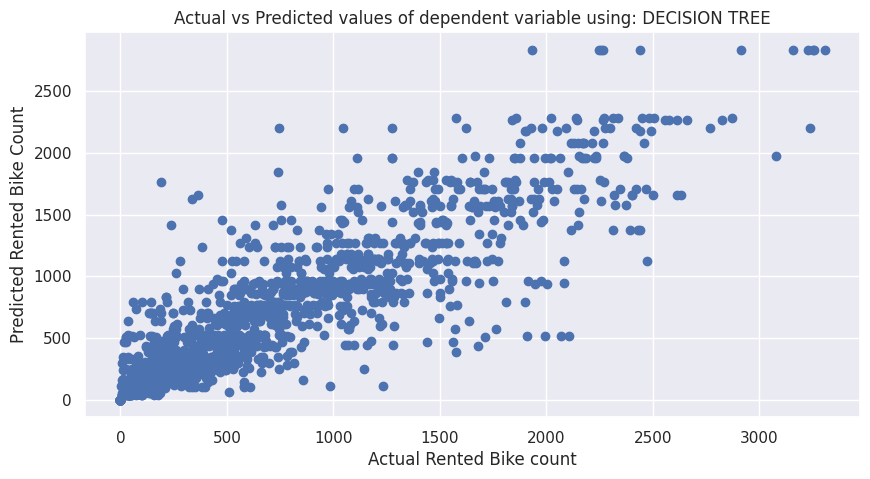

In [63]:
# predicted vs actual values of dependent variable
plt.figure(figsize=(10,5))
plt.scatter(x=np.square(y_test),y=np.square(dt_y_test_pred))
plt.xlabel('Actual Rented Bike count')
plt.ylabel('Predicted Rented Bike Count')
plt.title('Actual vs Predicted values of dependent variable using: DECISION TREE')

**Scatter plot of the actual and predicted values of the dependent variable on test data using decision tree.**

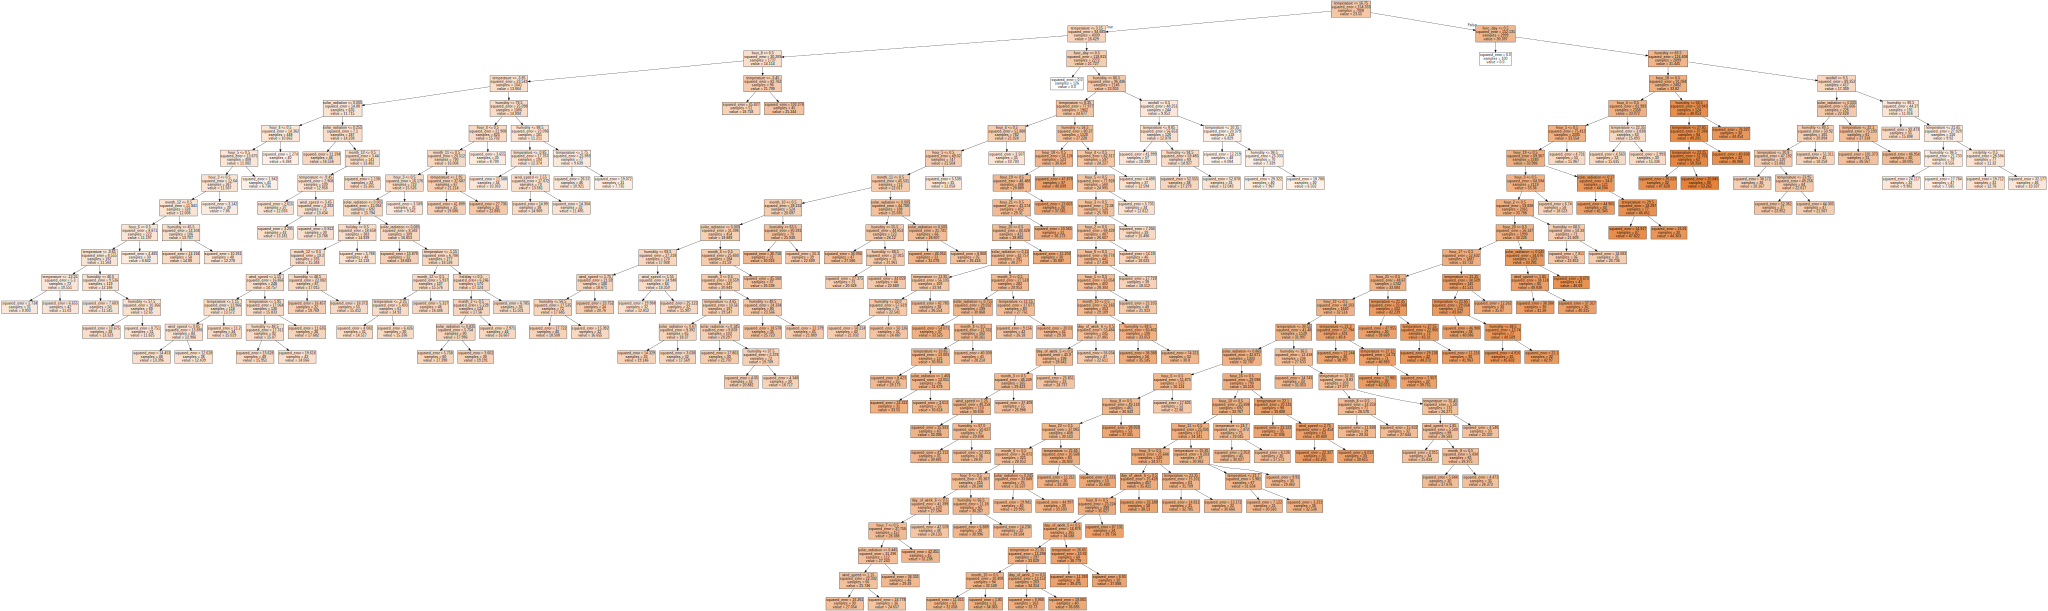

In [64]:
# Decision tree diagram


dot_data = tree.export_graphviz(dt_model, out_file=None,
                                feature_names=X_train.columns,
                                filled=True)
graph = graphviz.Source(dot_data)
display(SVG(graph.pipe(format='svg')))

**Decision tree model**

<Axes: title={'center': 'Feature Importances: DECISION TREE'}>

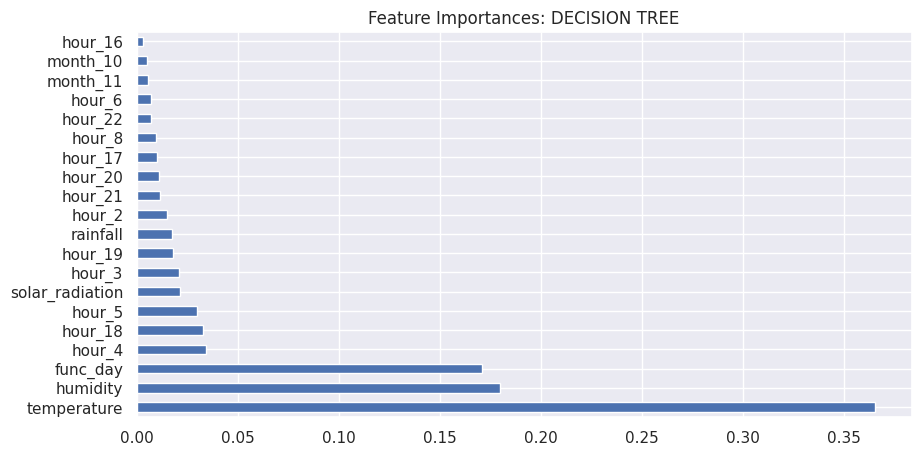

In [65]:
# Feature importances

dt_feat_imp = pd.Series(dt_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
plt.title('Feature Importances: DECISION TREE')
plt.xlabel('Relative Importance')
dt_feat_imp.nlargest(20).plot(kind='barh')

**Temperature is the most important feature considered to obtain the predictions using decision tree.**


## **8.2. Random Forests:**

In [66]:
# random forest model
rf_model = RandomForestRegressor(random_state=0)
rf_params = {'n_estimators':[500],                         # limited due to computational power availability
             'min_samples_leaf':np.arange(25,31)}         # Approximate range after fitting a decision tree model

In [67]:
# fitting a rf model with best parameters obtained from gridsearch
rf_gridsearch = GridSearchCV(rf_model,rf_params,cv=6,scoring='neg_root_mean_squared_error')
rf_gridsearch.fit(X_train,y_train)
rf_best_params = rf_gridsearch.best_params_

In [68]:
# best parameters for random forests
rf_best_params

{'min_samples_leaf': 25, 'n_estimators': 500}

In [69]:
# Fitting RF model with best parameters
rf_model = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
                                 min_samples_leaf=rf_best_params['min_samples_leaf'],
                                 random_state=0)

In [70]:
# fit
rf_model.fit(X_train,y_train)

RandomForestRegressor(min_samples_leaf=25, n_estimators=500, random_state=0)

In [71]:
# rf predictions on train data
rf_y_train_pred = rf_model.predict(X_train)

In [72]:
# rf predictions on test data
rf_y_test_pred = rf_model.predict(X_test)

In [73]:
# train score
rf_train_r2_score = r2_score(np.square(y_train),np.square(rf_y_train_pred))
rf_train_r2_score

0.8432435167367067

In [74]:
# test score
rf_test_r2_score = r2_score(np.square(y_test),np.square(rf_y_test_pred))
rf_test_r2_score

0.8136314152720869

In [75]:
# train rmse
rf_train_rmse = rmse(np.square(y_train),np.square(rf_y_train_pred))
rf_train_rmse

255.13140852412621

In [76]:
# test rmse
rf_test_rmse = rmse(np.square(y_test),np.square(rf_y_test_pred))
rf_test_rmse

279.2838385709083

<Axes: title={'center': 'Feature Importances: RANDOM FORESTS'}>

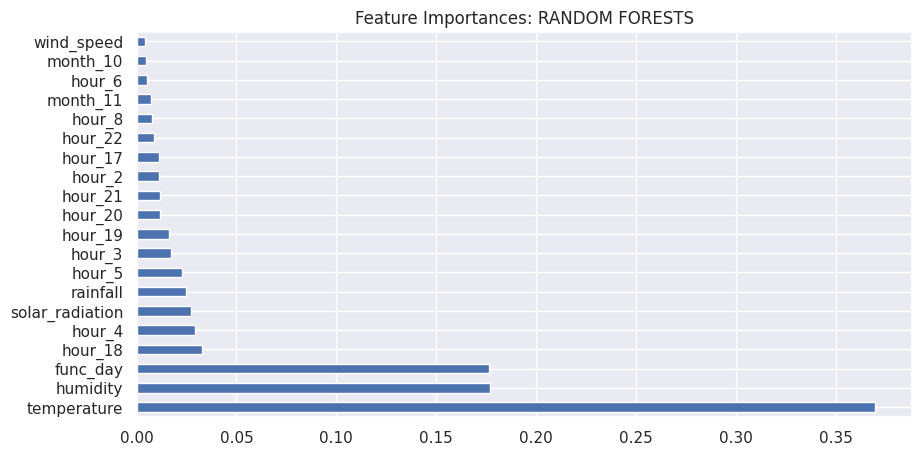

In [77]:
# Feature importance
rf_feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
plt.title('Feature Importances: RANDOM FORESTS')
plt.xlabel('Relative Importance')
rf_feat_imp.nlargest(20).plot(kind='barh')

**Temperature is the most important feature in predicting the value of the dependent variable for random forests, followed by humidity and func_day.**

Text(0.5, 1.0, 'Actual vs Predicted values of dependent variable using: RANDOM FOREST')

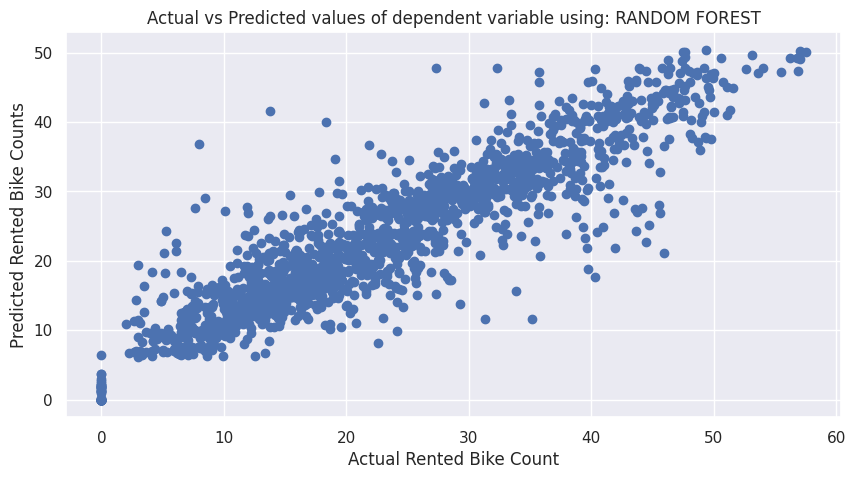

In [78]:
# Actual vs predicted values of dependent variables

plt.figure(figsize=(10,5))
plt.scatter(x=y_test,y=rf_y_test_pred)
plt.xlabel('Actual Rented Bike Count')
plt.ylabel('Predicted Rented Bike Counts')
plt.title('Actual vs Predicted values of dependent variable using: RANDOM FOREST')

**Scatter plot of the actual and predicted values of the dependent variable on test data using random forests.**

## **8.3. Gradient Boosting:**

In [79]:
# GBM model
gb_model = GradientBoostingRegressor(random_state=0)
gb_params = {'n_estimators':[500],
             'min_samples_leaf':np.arange(25,31)}

In [80]:
# finding best parameters
gb_gridsearch = GridSearchCV(gb_model,gb_params,cv=6,scoring='neg_root_mean_squared_error')
gb_gridsearch.fit(X_train,y_train)
gb_best_params = gb_gridsearch.best_params_

In [81]:
# GBM best parameters
gb_best_params

{'min_samples_leaf': 25, 'n_estimators': 500}

In [82]:
# Building GBM model with best parameters
gb_model = GradientBoostingRegressor(n_estimators=gb_best_params['n_estimators'],
                                     min_samples_leaf=gb_best_params['min_samples_leaf'],
                                     random_state=0)

In [83]:
# fit
gb_model.fit(X_train,y_train)

GradientBoostingRegressor(min_samples_leaf=25, n_estimators=500, random_state=0)

In [84]:
# gradient boosing train predictions
gb_y_train_pred = gb_model.predict(X_train)

In [85]:
# gradient boosting test predictions
gb_y_test_pred = gb_model.predict(X_test)

In [86]:
# train score
gb_train_r2_score = r2_score(np.square(y_train),np.square(gb_y_train_pred))
gb_train_r2_score

0.9291457378842602

In [87]:
# test score
gb_test_r2_score = r2_score(np.square(y_test),np.square(gb_y_test_pred))
gb_test_r2_score

0.9000722590251335

In [88]:
# train rmse
gb_train_rmse = rmse(np.square(y_train),np.square(gb_y_train_pred))
gb_train_rmse

171.52765907082392

In [89]:
# test rmse
gb_test_rmse = rmse(np.square(y_test),np.square(gb_y_test_pred))
gb_test_rmse

204.50431978615399

<Axes: title={'center': 'Feature Importances: Gradient Boosting Machine (GBM)'}>

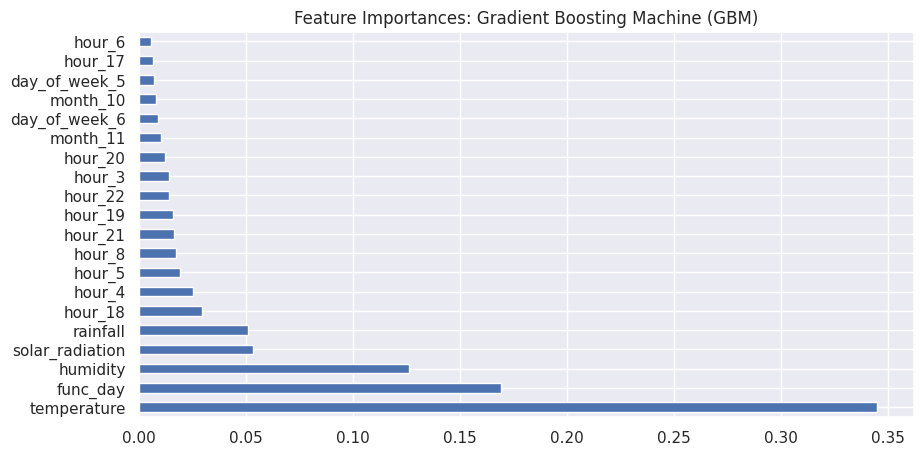

In [90]:
# gradient boosting feature importances
gbm_feat_imp = pd.Series(gb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
plt.title('Feature Importances: Gradient Boosting Machine (GBM)')
plt.xlabel('Relative Importance')
gbm_feat_imp.nlargest(20).plot(kind='barh')

## **8.4. XG Boost:**

In [91]:
X_train = X_train.astype('float')
X_test = X_test.astype('float')

In [92]:
# xg boost
xgb_model = xgb.XGBRegressor(random_state=0,
                             objective='reg:squarederror')
xgb_params = {'n_estimators':[500],
             'min_child_weight':np.arange(25,31)}


In [93]:
# finding best parameters
xgb_gridsearch = GridSearchCV(xgb_model,xgb_params,cv=6,scoring='neg_root_mean_squared_error')
xgb_gridsearch.fit(X_train,y_train)
xgb_best_params = xgb_gridsearch.best_params_

In [94]:
# xg boost best parameters
xgb_best_params

{'min_child_weight': 27, 'n_estimators': 500}

In [95]:
# Building a XG boost model with best parameters
xgb_model = xgb.XGBRegressor(n_estimators=xgb_best_params['n_estimators'],
                             min_child_weight=xgb_best_params['min_child_weight'],
                             random_state=0)

In [96]:
# fit
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=27, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [97]:
xgb_y_train_pred = xgb_model.predict(X_train)

In [98]:
xgb_y_test_pred = xgb_model.predict(X_test)

In [99]:
# train score
xgb_train_r2_score = r2_score(np.square(y_train),np.square(xgb_y_train_pred))
xgb_train_r2_score

0.9913710290952112

In [100]:
# test score
xgb_test_r2_score = r2_score(np.square(y_test),np.square(xgb_y_test_pred))
xgb_test_r2_score

0.929887938408654

In [101]:
# train rmse
xgb_train_rmse = rmse(np.square(y_train),np.square(xgb_y_train_pred))
xgb_train_rmse

59.859167581402964

In [102]:
# test rmse
xgb_test_rmse = rmse(np.square(y_test),np.square(xgb_y_test_pred))
xgb_test_rmse

171.29939141480145

<Axes: title={'center': 'Feature Importances: XG Boost'}>

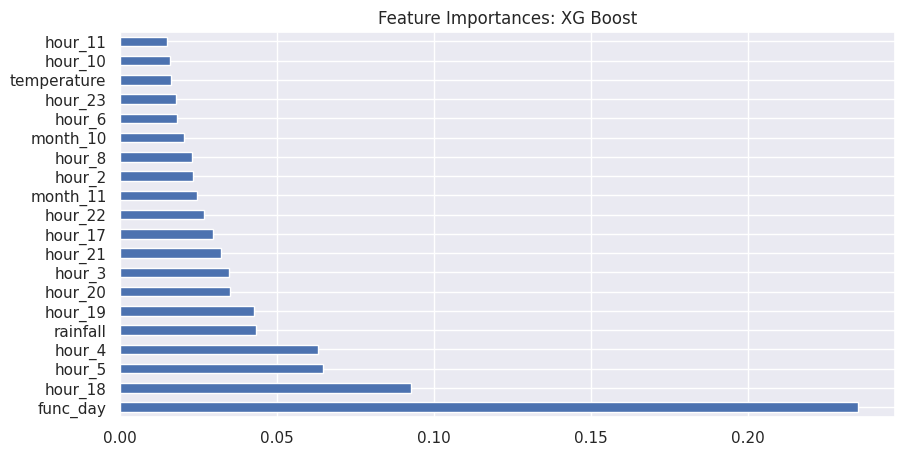

In [103]:
# feature importance
xgb_feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10,5))
plt.title('Feature Importances: XG Boost')
plt.xlabel('Relative Importance')
xgb_feat_imp.nlargest(20).plot(kind='barh')

**Func_day is the most important feature in predicting the value of the dependent variable follwed by hour_4 and temperature. Many features have a significant importance for XG boost model, rather than the top few features for other models.**

Text(0.5, 1.0, 'Actual vs Predicted values of dependent variable using: XG BOOST')

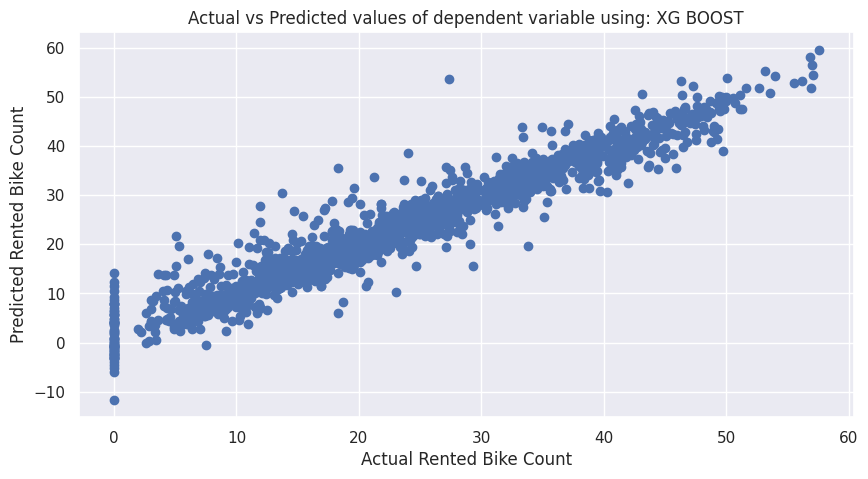

In [104]:
# Actual vs predicted values of dependent variables

plt.figure(figsize=(10,5))
plt.scatter(x=y_test,y=xgb_y_test_pred)
plt.xlabel('Actual Rented Bike Count')
plt.ylabel('Predicted Rented Bike Count')
plt.title('Actual vs Predicted values of dependent variable using: XG BOOST')

**Scatter plot of the actual and predicted values of the dependent variable on test data using XG boost.**

# **9. XG Boost model explainability using Shapley values:**

* To make black box models like XG boost explainable, we can use Shapley values.
* It shows the contribution or the importance of each feature on the prediction of the model. This makes it more explainable.

In [108]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 12.5 MB/s eta 0:00:00


In [109]:
# importing shap
import shap

In [110]:
#Get shap values
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

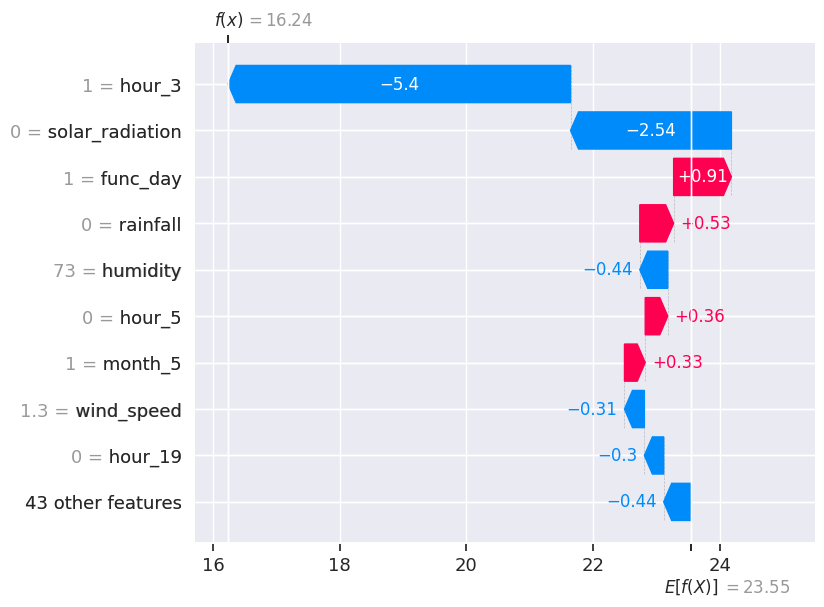

In [111]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

* Above is a waterfall plot for the first record in the test dataset.
* **They tell the contribution of each feature in increasing or decreasing the final prediction of the dependent variable.**
* **f(x) is the predicted value of the model E[f(x)] is the expected value of the target variable, or in other words, the mean of all predictions**
* **Note that these shapley values are valid for this observation only. With other data points the SHAP values will change.**

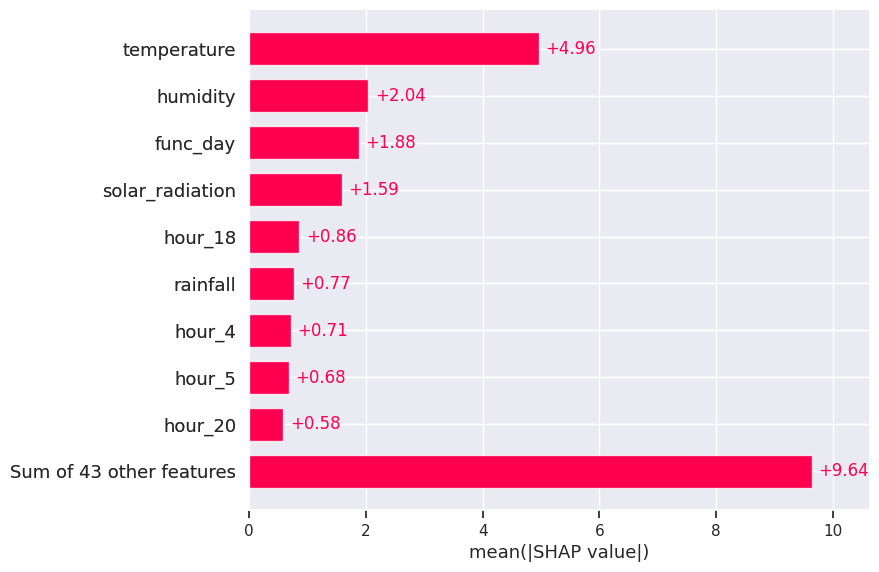

In [112]:
#Mean SHAP
shap.plots.bar(shap_values)

**The above plot gives the average feature shapley values.**

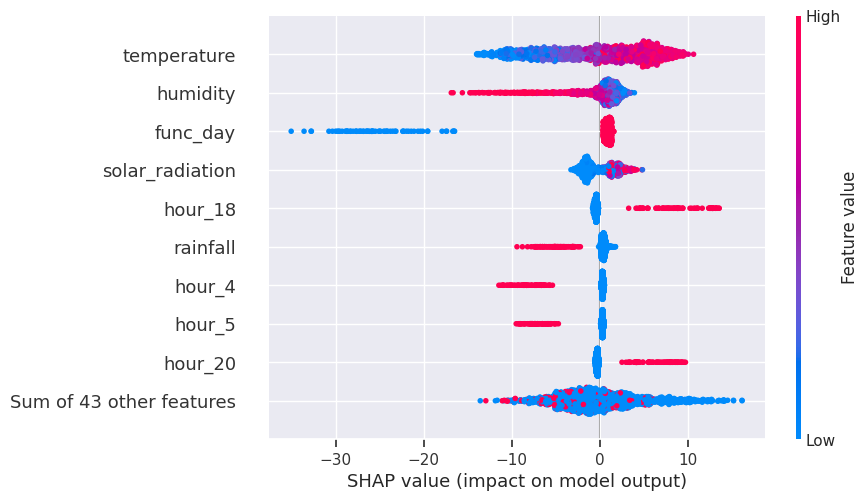

In [113]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)

**The above plot is called bee swarm plot, which helps us understand the global importance / contribution of each feature.**

# **10. Results:**

Train and test RMSEs and R2 scores for the models built are follows:

In [114]:
# Summarizing the results obtained
test = PrettyTable(['Sl. No.','Regression Model', 'Train RMSE','Test RMSE','Train R2 Score (%)','Test R2 Score (%)'])
test.add_row(['1','Decision Tree',dt_train_rmse,dt_test_rmse,dt_train_r2_score*100,dt_test_r2_score*100])
test.add_row(['2','Random Forests',rf_train_rmse,rf_test_rmse,rf_train_r2_score*100,rf_test_r2_score*100])
test.add_row(['3','Gradient Boosting Method',gb_train_rmse,gb_test_rmse,gb_train_r2_score*100,gb_test_r2_score*100])
test.add_row(['4','XG Boost',xgb_train_rmse,xgb_test_rmse,xgb_train_r2_score*100,xgb_test_r2_score*100])
print(test)

+---------+--------------------------+--------------------+--------------------+--------------------+-------------------+
| Sl. No. |     Regression Model     |     Train RMSE     |     Test RMSE      | Train R2 Score (%) | Test R2 Score (%) |
+---------+--------------------------+--------------------+--------------------+--------------------+-------------------+
|    1    |      Decision Tree       | 263.27343792572776 | 294.39739036199455 | 83.30787041043375  | 79.29148250467615 |
|    2    |      Random Forests      | 255.13140852412621 | 279.2838385709083  | 84.32435167367068  |  81.3631415272087 |
|    3    | Gradient Boosting Method | 171.52765907082392 | 204.50431978615399 | 92.91457378842603  | 90.00722590251335 |
|    4    |         XG Boost         | 59.859167581402964 | 171.29939141480145 | 99.13710290952112  |  92.9887938408654 |
+---------+--------------------------+--------------------+--------------------+--------------------+-------------------+


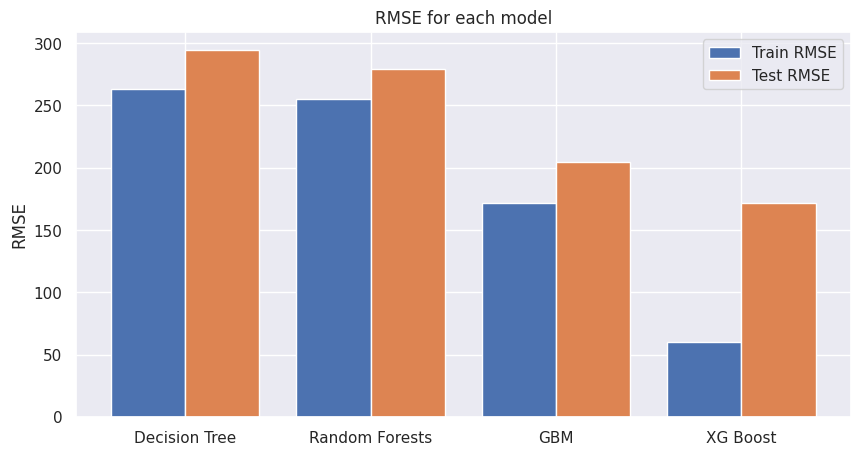

In [115]:
# Plotting RMSEs

ML_models = ['Decision Tree','Random Forests','GBM','XG Boost']
train_rmses = [dt_train_rmse,rf_train_rmse,gb_train_rmse,xgb_train_rmse]
test_rmses = [dt_test_rmse,rf_test_rmse,gb_test_rmse,xgb_test_rmse]

X_axis = np.arange(len(ML_models))

plt.figure(figsize=(10,5))
plt.bar(X_axis - 0.2, train_rmses, 0.4, label = 'Train RMSE')
plt.bar(X_axis + 0.2, test_rmses, 0.4, label = 'Test RMSE')

plt.xticks(X_axis,ML_models)
plt.ylabel("RMSE")
plt.title("RMSE for each model")
plt.legend()
plt.show()

**The XG boost model was able to predict the dependent variable with the lowest test RMSE.**

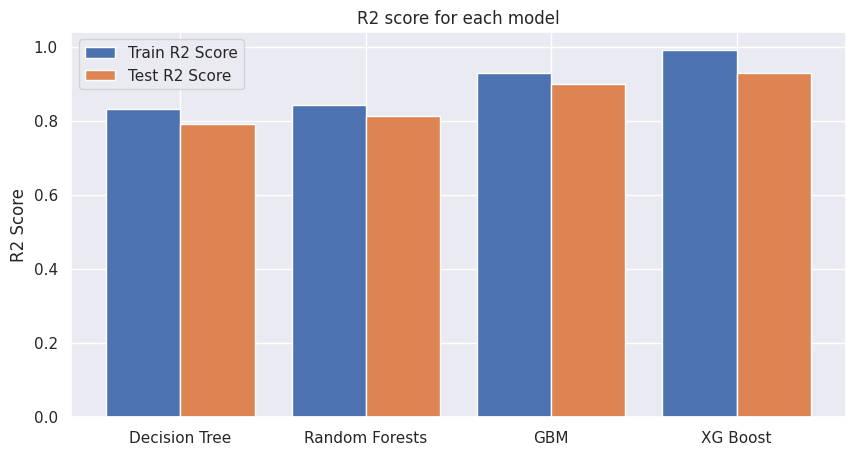

In [116]:
# Plotting R2 scores

ML_models = ['Decision Tree','Random Forests','GBM','XG Boost']
train_r2_scores = [dt_train_r2_score,rf_train_r2_score,gb_train_r2_score,xgb_train_r2_score]
test_r2_scores = [dt_test_r2_score,rf_test_r2_score,gb_test_r2_score,xgb_test_r2_score]

X_axis = np.arange(len(ML_models))

plt.figure(figsize=(10,5))
plt.bar(X_axis - 0.2, train_r2_scores, 0.4, label = 'Train R2 Score')
plt.bar(X_axis + 0.2, test_r2_scores, 0.4, label = 'Test R2 Score')

plt.xticks(X_axis,ML_models)
plt.ylabel("R2 Score")
plt.title("R2 score for each model")
plt.legend()
plt.show()

**The XG boost model was able to predict the dependent variable with the highest test R2 score.**

# **11. Summary and conclusions:**

* We trained 4 unique Machine Learning models using the training dataset, and the its respective performance was improved through hyperparameter tuning.
* We initially started with the decision tree model, mainly because it is easily explainable to the stakeholders, and its low training time.
* Once we were successfully able to fit a decision tree, it was necessary to improve the prediction accuracy, and reduce errors in the predictions.
* To achieve this, we fit a random forest model on the training data, and the final predictions showed less errors compared to that of decision tree model.
* To further improve the predictions of the model, we fit 2 boosting models namely; Gradient boosting machine (GBM) and Extreme gradient boost (XG Boost). The predictions obtained from these models showed errors in the same range, but the errors were lower than that of decision tree model.

The XG Boost model has the lowest RMSE, and the highest R2 score.

Final choice of model depends on:
* If it is absolutely necessary to have a model with the best accuracy, then XG boost will be the best choice, since it has the lowest RMSE than other models built.
* But as discussed above, higher the model complexity, lower is the model explainability. Hence if the predictions must be explained to stakeholers, then XG Boost is not an ideal choice.
* In this case decision tree can be used, since they are easier to explain. By choosing a simpler model, we will be compromising with the model accuracy (Accuracy vs Interpretability tradeoff).